<a href="https://colab.research.google.com/github/samuramirez/cellmigration/blob/master/segmentation_1_class_cell_indiv_tiff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Forked again from segmentation_keras_refactor; using segmentation_models, based on the code elizabeth shared with matt

# Init Segmentation

## Mount Google Drive, install load packages

### Mount Google Drive (Colab can see Drive files) and authenticate so that we can interact with GCP via SDK

In [1]:
try:
    in_colab = True
    from google.colab import drive
    drive.mount('/content/gdrive',force_remount=True);
except ImportError:
    in_colab = False

Mounted at /content/gdrive


### Installing and loading packages

In [ ]:
%pip show tensorflow

In [3]:
%%capture
%pip install segmentation-models
%pip install imageio --upgrade
%pip install json-tricks
%pip install ultraimport
%pip install joblib
%pip install ray

### Import libraries

In [4]:
import pandas as pd
from warnings import warn
import imageio
from skimage.io import imread, imsave, imshow
from skimage.exposure import rescale_intensity, adjust_gamma
from skimage.transform import resize
from typing import Callable,Dict,List,Tuple,Union,Any,Iterable
from tqdm import tqdm
import os
import numpy as np
from pathlib import Path
import re
import ntpath
import shutil
import stat
import json_tricks
import ultraimport
if in_colab:
    filenames = ultraimport('/content/gdrive/Othercomputers/UNC Laptop/libraries/filenames.py')
else:
    filename = ultraimport('libraries/filenames.py')

# fix for new segmentation_models error was taken from here: https://stackoverflow.com/questions/75433717/module-keras-utils-generic-utils-has-no-attribute-get-custom-objects-when-im
os.environ["SM_FRAMEWORK"] = "tf.keras"
from segmentation_models import Unet
from tensorflow.keras.preprocessing.image import load_img
from tensorflow import keras
import random



Segmentation Models: using `tf.keras` framework.


## Segmentation Parameters


### Basic Parameters
other shared settings between training and separation

In [34]:
#@markdown ### To specify a file in a bucket, prexis the path with gs://
#@markdown Whether input paths exist in a gcp bucket (will be autodetected if unset)
activate_gcp = False #@param {type:"boolean"}

def is_gcp_path(path:Path):
  return path.parts[0].lower() == "gs:";

#@markdown What object type you are segmenting
segmentation_target = "Cell" #@param ["Nucleus", "Cell", "Combined"]

#@markdown folder where processed images will be stored for training or segmentation
local_folder='local' #@param {type:"string"}
local_folder=Path(local_folder);

#@markdown folder where image processing metadata is stored
meta_folder = 'meta' #@param {type:"string"}
meta_folder = Path(meta_folder)

#@markdown folder where downloaded images will be stored temporarily for processing
temp_folder='temp' #@param {type:"string"}
temp_folder = Path(temp_folder);

#@markdown directory where models are stored and will be exported to
_modelsfolder = 'gs://optotaxisbucket/models/keras' #@param {type:"string"}
_modelsfolder = Path(_modelsfolder);
if is_gcp_path(_modelsfolder):
  activate_gcp = True;


training_images_folder = local_folder/"train_images"
training_masks_folder = local_folder/"train_masks"
segmentation_images_folder = local_folder/"segmentation_images"
segmentation_output_folder = local_folder/"segmentation_masks_out"
local_modelsfolder = local_folder/"models";


local_folders = [local_folder,
            training_images_folder,
            training_masks_folder,
            segmentation_images_folder,
            segmentation_output_folder,
            local_modelsfolder,
            temp_folder];

def on_rm_error( func, path, exc_info):
    # path contains the path of the file that couldn't be removed
    # let's just assume that it's read-only and unlink it.
    os.chmod( path, stat.S_IWRITE )

def cleardir(dir): #clears all files in dir without deleting dir
  print("dir cleared:",dir)
  for f in os.scandir(dir):
    if os.path.isdir(f): shutil.rmtree(f,onerror=on_rm_error); #just in case
    else: os.remove(f);


for d in local_folders:
  if not os.path.exists(d):
    os.makedirs(d);
  else:
    cleardir(d);


dir cleared: local
dir cleared: temp


### Image Preparation Settings
shared settings between training and segmentation image/mask processing

In [35]:
#@markdown ##Adjacent Image Stacking
#@markdown Whether to use several "adjacent" images as input instead of one
image_stacking = True #@param {type:"boolean"}
num_stacked_images = 3 #@param {type:"integer"}

#@markdown ### Mask stacking
#@markdown Whether to also train (and output) a mask for each input image, or just use the center.
#@markdown "Narrow" means only the center mask will be used. This cuts off the end and the beginning of the movie, depending on the width of stacking.
#@markdown "Wide" means a mask will be segmented for every image. This means there will be multiple corresponding masks per image! When segmenting in this notebook, they will be labeled by offset number in the output directory.
mask_stacking_type = "Narrow" #@param ["Narrow", "Wide"]
mask_stacking = (mask_stacking_type == "Wide")


#@markdown Scale factor - factor by which height and width will be multiplied, final dimensions rounded to nearest integer. (Default is 1, which does nothing)
scale_factor = 1 #@param {type:"number"}

do_scaling = scale_factor == 1


#@markdown ##Image Splitting and stitching
#@markdown Whether to split trained images into smaller chunks
do_splitting = False #@param {type:"boolean"}

#@markdown Number of slices (columns/rows) to divide input images into; for the math, please see https://www.desmos.com/calculator/xrqev2vluo
x_slices = 4 #@param {type:"integer"}
y_slices =  5 #@param {type:"integer"}
#@markdown dx, dy are the extra context around the segmented center in both directions
dx =  32#@param {type:"integer"}
dy =  32#@param {type:"integer"}
#@markdown x and y crop are how much to straight remove from the image to make the sizes able to be subdivided nicely
x_crop = 0 #@param {type:"integer"}
y_crop = 0 #@param {type:"integer"}

if not do_splitting:
  x_slices = 1;
  y_slices = 1;
  dx = 0;
  dy = 0;
  x_crop = 0;
  y_crop = 0;

context_bounds = [dy,dx]*2 #assuming x and y bounds are symmetrical to both sides of the image, which might not always true -- fix?
crop = [y_crop,x_crop]*2 #both of these are negative y, negative x, positive y, positive x

### Training-Specific Settings
parameters and paths only for training

In [36]:
#@markdown ## Training Source
#@markdown location - zip file or folder - where input images are stored
_training_images="/content/gdrive/Othercomputers/UNC Laptop/iter1/round11/wide_images" #@param {type:"string"}
_training_images=Path(_training_images);

#@markdown input folder where masks are stored (will not be edited)
_training_masks="/content/gdrive/Othercomputers/UNC Laptop/iter1/round11/masks" #@param {type:"string"}
_training_masks=Path(_training_masks);

if (is_gcp_path(_training_images) or is_gcp_path(_training_masks)):
  activate_gcp = True;

#@markdown UNET model that will be used to train from, relative to modelsfolder. if left blank, a new model will be created (customizable in the cell in training.)
inmodelname = '' #@param {type:"string"}
#@markdown Name of the output model will be exported to after training, in modelsfolder (if modelsfolder is gcp, will also update)
outmodelname = 'iter1_11_cell_3stack' #@param {type:"string"}

#@markdown ## Training Data Augmentation

#@markdown ### Gamma (avg brightness) adjustments
do_gamma = False #@param {type:"boolean"}
gamma_aug_list = [0.5,0.8,1,1.2,1.5] #@param {type:"raw"}

#@markdown whether to have the model output at half resolution (only applies to newly created models)
model_halfres = False #@param {type:"boolean"}

#@markdown Mask Scale Factor - if input mask needs to be scaled by a different factor than input image, add it here. Multiplies with the overall factor. 1 keeps default behavior.
train_mask_scale_factor = 1 #@param {type:"number"}


### Segmentation-Specific Settings
parameters and paths only for segmenting an experiment


In [37]:
#@markdown Path of the folder containing the movies in GCP bucket
_segmentation_images="gs://optotaxisbucket/movies/2023.4.7 OptoTiam Exp 56/2023.4.7 OptoTiam Exp 56"  #@param {type:"string"}
_segmentation_images=Path(_segmentation_images);

#@markdown name of the model used to segment
segment_model_name="iter1_11_cell_3stack" #@param {type:"string"}

#@markdown path of the folder where the output masks will be deposited. if in gcp bucket (prefix with gs://), will be exported
_segmentation_output_masks='gs://optotaxisbucket/movie_segmentation/out_testing/2023.4.7 OptoTiam Exp 56/Cell' #@param {type:"string"}
_segmentation_output_masks=Path(_segmentation_output_masks);

if is_gcp_path(_segmentation_images) or is_gcp_path(_segmentation_output_masks):
  activate_gcp = True;

#@markdown if the output of the segmentation needs to be scaled up/down by a certian factor, put it here.
segmentation_mask_scale_factor = 1 #@param {type:"number"}



### Activate GCP if necessary

In [38]:
if activate_gcp:
  from google.colab import auth
  #This allows SDK to see and edit Google Drive files
  #SDK is required to interact with GCP
  auth.authenticate_user()


## Shared helper functions

### Model Management

In [10]:
#### KERAS ####
if True:
    def create_UNET():
        return Unet('resnet34', encoder_weights='imagenet', classes=2, input_shape=(None,None,3), activation='softmax')

    def load_model(modelname:str|Path,fetch=True):
        json_name = local_modelsfolder/modelname/('model_config.json')
        weights_name = local_modelsfolder/modelname/('weights_only.h5')
        if fetch:
            fetch_modelsfolder()
        return load_keras_h5(json_name,weights_name)

    def load_keras_h5(config_path:Path,weights_path:Path):
        #load model as json
        with open(config_path) as json_file:
            json_config = json_file.read()
        loaded_model = keras.models.model_from_json(json_config)

        # Load weights
        loaded_model.load_weights(weights_path)

        return loaded_model

    def save_model(modelname:str|Path,model,push=True):
        json_name = local_modelsfolder/modelname/('model_config.json')
        weights_name = local_modelsfolder/modelname/('weights_only.h5')

        # Save model config
        json_config = model.to_json()
        with open(json_name, 'w') as json_file:
            json_file.write(json_config)

        # Save weights and architecture
        model.save_weights(weights_name)

        if push:
            push_modelsfolder()

#### PYTORCH ####
#idk if I'm ever gonna use this but this is where you'd implement similar functions
if False:
    pass

### File Transfer / Management

In [11]:
from collections import OrderedDict
from copy import deepcopy

def _fetch_gcp_files(in_path:Path,keyword:str,overwrite:bool)->Path: ##should not be called outside of other helper functions
  is_file = str(in_path).lower().endswith(('.zip','.tif','.tiff'));
  destination = temp_folder/keyword/in_path.stem;
  if not(os.path.exists(destination)):
    os.makedirs(destination);
  # copy_out = Path(destination)/in_path.name;
  command_output = None;
  if (is_gcp_path(in_path)): #first part is gs:, must be removed to work with gcloud
    in_path = Path(*in_path.parts[1:])
  if overwrite or len(os.listdir(destination)) == 0:
    if is_file:
      command_output = !gsutil -m cp -r "gs://{in_path}" "{destination}"
    else:
      command_output = !gsutil -m rsync -r "gs://{in_path}" "{destination}"
  if (command_output is not None and command_output[0].startswith("CommandException")):
    raise RuntimeError(f"Error while downloading {keyword} from bucket: " + '\n'.join(command_output));
  elif len(os.listdir(destination)) == 0:
    raise RuntimeError("Error: downloading failed for an unknown reason, 0 files in dest directory; Command Output:",command_output);
  if (not is_file):
    return destination; #we're done
  else:
    destination = destination/in_path.name;
  if (in_path.suffix == '.zip'):
    out_path = destination.with_suffix('');
    command_output = None;
    if (overwrite or not os.path.exists(out_path)):
      command_output = !unzip -o "{destination}" -d "{destination.parent}"
    if (command_output is not None and command_output[0].startswith("CommandException")):
      raise RuntimeError(f"Error while unzipping {keyword}: " + '\n'.join(command_output));
    elif not os.path.exists(out_path):
      raise RuntimeError(f"Error while unzipping (from GCP): zip file {destination.name} does not contain folder {destination.with_suffix('').name}");
    return out_path;
  elif (in_path.suffix.lower().startswith('.tif')):
    raise NotImplementedError("unstacking TIF files not yet supported");
  else:
    raise NameError("Invalid input suffix, input validation should have caught this >:(");

def _push_gcp_files(in_folder:Path,out_path:Path,keyword:str,overwrite:bool):
  print(in_folder,out_path)
#   breakpoint()
  assert os.path.isdir(in_folder);
  if (is_gcp_path(out_path)): #first part is gs:, must be removed to work with gcloud
    out_path = Path(*out_path.parts[1:])

  command_output = None;

  if (out_path.suffix != ''): #file
    in_file = None;
    if (out_path.suffix.lower() == '.zip'):
      command_output = !zip "{temp/keyword/zip/out_path.name}"  "{in_folder}"
      if (command_output is not None and command_output[0].startswith("CommandException")):
        raise RuntimeError(f"Error while zipping {keyword} folder {in_folder} to zip file: " + '\n'.join(command_output));
      in_file = temp_folder/keyword/zip/out_path.name;
    elif (out_path.suffix.lower().startswith('.tif')):
      raise NotImplementedError("stacking TIF files not yet supported");
    else:
      raise NameError("Invalid output suffix; can only zip or stack tiffs. If the output is a directory, please do not add a file suffix.")

    if overwrite:
      command_output = !gsutil -m cp -r "{in_file}" "gs://{out_path}"
    else:
      command_output = !gsutil -m cp -r -n "{in_file}" "gs://{out_path}"
  else: #upload entire directory
    command_output = !gsutil -m rsync -r "{in_folder}" "gs://{out_path}"

  if (command_output is not None and command_output[0].startswith("CommandException")):
    raise RuntimeError(f"Error while uploading {keyword} to bucket: " + '\n'.join(command_output));
  return


In [12]:
_keyword_map = {"models":(_modelsfolder,local_modelsfolder),
               "train_images":(_training_images,training_images_folder),
               "train_masks":(_training_masks,training_masks_folder),
               "segmentation_images":(_segmentation_images,segmentation_images_folder),
               "segmentation_masks":(_segmentation_output_masks,segmentation_output_folder)};

_keyword_sources:Dict[str,Union[None,Path]] = {name:None for name in _keyword_map};


In [13]:
def _fetch_sourcefolder(keyword,overwrite=True)->Path:
  """returns the folder with the raw files, after unzip and or download if necessary."""
  if (not overwrite and _keyword_sources[keyword] is not None):
    return _keyword_sources[keyword];
  source = _keyword_map[keyword][0];
  result = source;
  if (is_gcp_path(source)):
    result = _fetch_gcp_files(source,keyword,overwrite=True);
  elif (source.suffix == '.zip'):
    destination = temp_folder/keyword;
    os.mkdir(destination);
    command_output = !unzip -o "{source}" -d "{destination}"
    result = destination/source.stem;
    if (not os.path.exists(result)):
      raise RuntimeError(f"Error while unzipping: zip file {source} does not contain folder {source.stem}");
  if (_keyword_sources[keyword] is not None and _keyword_sources[keyword] != result):
    raise RuntimeError(f"Error fetching sourcefolder for keyword {keyword}: sourcefolder already exists in a different location - are you pushing before you fetch?");
  _keyword_sources[keyword] = result;
  return result;

def _push_sourcefolder(keyword,overwrite=True):
  """inverse of fetch_sourcefolder - zips sourcefolder to original location or pushes to gcp if appropriate, otherwise noop"""
  sourcefolder = _keyword_sources[keyword];
  if (sourcefolder is None):
    raise RuntimeError("")
  dest = _keyword_map[keyword][0];
  if (is_gcp_path(dest)):
    _push_gcp_files(sourcefolder,dest,keyword,overwrite=overwrite);
  elif (dest.suffix == '.zip'):
    raise NotImplementedError("local sourcefolder zipping not implemented");
  pass;



class Img:
    name:str
    img:np.ndarray
    metadata:dict[str,Any]

    def __init__(self,name:str,img:np.ndarray,metadata:dict[str,Any]):
        self.name = name
        self.img = img
        self.metadata = metadata

    def copy(self):
        return Img(*self)

    def asdict(self):
        return {"name":self.name,"img":self.img,"metadata":self.metadata}

    def astuple(self):
        return (self.name,self.img,self.metadata)

    def __iter__(self):
        return iter(self.astuple())

    def __str__(self):
        return f"Image {self.name} of shape {self.img.shape} and metadata {list(self.metadata.keys())}"

_single_proc = Callable[[Img],Union[Img,Iterable[Img]]]
# _multi_proc =
proc_type = Callable[[Union[Img,Iterable[Img]]],Union[Img,Iterable[Img]]]

from functools import wraps
def doublewrap(f):
    '''
    a decorator decorator, allowing the decorator to be used as:
    @decorator(with, arguments, and=kwargs)
    or
    @decorator
    '''
    @wraps(f)
    def new_dec(*args, **kwargs):
        if len(args) == 1 and len(kwargs) == 0 and callable(args[0]):
            # actual decorated function
            return f(args[0])
        else:
            # decorator arguments
            return lambda realf: f(realf, *args, **kwargs)

    return new_dec

from typing import DefaultDict,Dict,TypeVar
K = TypeVar('K')
V = TypeVar('V')
def merge_data(*dicts:Dict[K,V],require_all_present=True,require_all_equal=True)->Dict[K,V]:
    if not require_all_present:
        if not require_all_equal:
            dd = DefaultDict(list)
            for d in dicts: # you can list as many input dicts as you want here
                for key, value in d.items():
                    dd[key].append(value)
            return {k:v[0] for k,v in dd.items()}
        else:
            dd = {}
            null = object()
            for d in dicts:
                for key,value in d.items():
                    if key in dd:
                        if dd[key] is not null and dd[key] != value:
                            dd[key] = null
                    else:
                        dd[key] = value
            return {k:v for k,v in dd.items() if v is not null}

    else:
        if not require_all_equal:
            dd = {k:[] for k in dicts[0].keys()}
            for d in dicts:
                bad = []
                for key in dd.keys():
                    if key not in d:
                        bad.append(key)
                    else:
                        dd[key].append(d[key])
                [dd.pop(k) for k in bad]
            return {k:v[0] for k,v in dd.items()}
        else:
            dd = dicts[0].copy()
            for d in dicts:
                bad = []
                for key in dd.keys():
                    if key not in d:
                        bad.append(key)
                    else:
                        if dd[key] != d[key]:
                            bad.append(key)
                # print(bad)
                [dd.pop(k) for k in bad]
            return dd


#for both processing and deprocessing images
#this allows functions like splitting or stitching of images; splititng returns multiple images, stitching can return [] for all images concatenated into a larger one
@doublewrap
def proc_fn(fn:Union[_single_proc,proc_type],*,multi=False)->proc_type:
    if multi:
        assert isinstance(fn,proc_type)
    def new_proc(im:Union[Img,Iterable[Img]]):
        # print(im)
        if isinstance(im,Img) or multi:
            res = fn(im)
        else:
            r = (fn(i) for i in im)
            r = ([k] if isinstance(k,Img) else k for k in r)
            res = (x for l in r for x in l)
        # print(f"Result of applying function {fn}: {res}")
        return res
    return new_proc

def _decopy_local(keyword:str,push_source=True):
  dest = _keyword_sources[keyword] or temp_folder/keyword/_keyword_map[keyword][0].stem;
  _keyword_sources[keyword] = dest;
  local = _keyword_map[keyword][1];

  print(f"{local}->{dest}")
  command_out = !gsutil -m rsync -r "{local}" "{dest}"
  if (command_out[0].startswith("CommandException")):
    raise Exception("error copying",keyword,"files:",command_out);

  if push_source:
    _push_sourcefolder(keyword);

def _deprocess_images(keyword:str,deprocess_fn:proc_type,push_source=True,do_warn=True):
  dest = _keyword_sources[keyword]
  if dest is None:
    p_source = _keyword_map[keyword][0]; #p for prospective
    print("checking prospective source",p_source);
    if (is_gcp_path(p_source) or p_source.is_file()):
      print("file/gcp found: requires temp folder")
      dest = temp_folder/keyword/_keyword_map[keyword][0].stem;
      _keyword_sources[keyword] = dest;
      if not os.path.exists(dest):
        os.makedirs(dest);
    else:
      print("not file nor gcp: writing directly to source");
      _keyword_sources[keyword] = p_source;
      dest = p_source

  if not os.path.exists(dest):
    os.makedirs(dest)

  local = _keyword_map[keyword][1];

  for im in tqdm(os.listdir(local)):
    path = local/im;
    if (path.suffix not in (".tif",".tiff",".TIF",".TIFF")):
        if do_warn:
            warn(f"non-image file in {keyword} dir: {im}");
        continue;
    try:
      image = imread(path);
    except:
      raise RuntimeError("unable to read image",path);
    try:
        data = json_tricks.load(str(meta_folder/keyword/im))
    except:
        if keyword == "segmentation_masks":
            data = json_tricks.load(str(meta_folder/"segmentation_images"/im))
            data["keyword"] = keyword
            data["sourcefolder"] = dest
        else:
            warn(f"Unable to read image processing metadata for image {im}")
            data = {"keyword":keyword,"sourcefolder":dest}
    processed = deprocess_fn(Img(im,image,data));
    # print(deprocess_fn)
    if isinstance(processed,Img):
      processed = [processed];
    # print(f"deprocessed: {processed}")
    for name,p,data_dict in processed:
      imsave(dest/name,p,check_contrast=False);

  if push_source:
    _push_sourcefolder(keyword);

def _copy_local(keyword:str,overwrite_source=False):
  source = _fetch_sourcefolder(keyword,overwrite=overwrite_source);
  dest = _keyword_map[keyword][1];

  command_out = !gsutil -m rsync -r "{source}" "{dest}"
  if (command_out[0].startswith("CommandException")):
    raise Exception("error copying",keyword,"files:",command_out);
  return dest;

def _process_images(keyword:str,process_fn:proc_type,overwrite_source=False,do_warn=True):
  source = _fetch_sourcefolder(keyword,overwrite=overwrite_source);
  dest =_keyword_map[keyword][1];
  if any(os.scandir(dest)):
    cleardir(dest);

  for im in tqdm(os.listdir(source)):
    path = source/im;
    if (path.suffix not in (".tif",".tiff",".TIF",".TIFF")):
        warn(f"non-image file in {keyword} dir: {im}");
        continue;
    image = imread(path);
    data_dict = {"sourcefolder":source,"keyword":keyword,"history":[]}
    processed = process_fn(Img(im,image,data_dict));
    if (isinstance(processed,Img)):
      processed = [processed];
    os.makedirs(meta_folder/keyword,exist_ok=True)
    for name,p,data in processed:
      imsave(dest/name,p,check_contrast=False);
      json_tricks.dump(data,str(meta_folder/keyword/name))

  return dest;


@proc_fn
def no_op(i):
    return i

def process_train_images(process_fn:proc_type=no_op,overwrite_source=False):
  return _process_images("train_images",process_fn,overwrite_source=overwrite_source);

def process_segmentation_images(process_fn:proc_type=no_op,overwrite_source=False):
  return _process_images("segmentation_images",process_fn,overwrite_source=overwrite_source);

def process_train_masks(process_fn:proc_type=no_op,overwrite_source=False):
    # breakpoint()
    return _process_images("train_masks",process_fn,overwrite_source=overwrite_source);

def deprocess_segmentation_masks(process_fn:proc_type=no_op):
  _deprocess_images("segmentation_masks",process_fn,push_source=True);

def fetch_modelsfolder(overwrite=False):
  return _copy_local("models",overwrite_source=overwrite);

def push_modelsfolder(fetch=False):
  if (fetch):
    fetch_modelsfolder(overwrite=False);
  return _decopy_local("models",push_source=True);

def push_segmentation_folder():
  return _push_sourcefolder("segmentation_masks")

def _proc_wrap(func:proc_type):
  def wrapped(im:Union[Img,Iterable[Img]]):
    o = func(im);
    if (isinstance(o,Img)):
      o = [o];
    return o;
  return wrapped;

def _proc_compose(f1:proc_type,f2:proc_type)->proc_type:
  wf1 = _proc_wrap(f1);
  wf2 = _proc_wrap(f2);
  def composed(im:Union[Img,Iterable[Img]]):
    return (k for l in (wf2(i) for i in wf1(im)) for k in l)
  return composed;

def compose_proc_functions(funcs:List[proc_type]):
  return functools.reduce(_proc_compose,funcs);



def parallel_compose_proc_functions(funs:List[proc_type],n_jobs=-1):
    """ Parallel version of compose_proc_functions. Uses joblib to do each stage of the process
    in parallel. NOTE: At every branch of the function tree (each input image, functions that return multiple images)
    there is no guarantee that proc functions will be run in the same thread. THEREFORE, ANY STATEFUL PROCESS FUNCTIONS MUST BE MADE
    PROCESS-SAFE WITH RAY.
    """
    wrapped = [_proc_wrap(f) for f in funs]
    from joblib import Parallel, delayed

    from joblib import register_parallel_backend
    def register_ray():
        import ray
        """Register Ray Backend to be called with parallel_backend("ray")."""
        try:
            from ray.util.joblib.ray_backend import RayBackend
            RayBackend.supports_return_generator = True

            register_parallel_backend("ray", RayBackend)
        except ImportError:
            msg = (
                "To use the ray backend you must install ray."
                "Try running 'pip install ray'."
                "See https://docs.ray.io/en/master/installation.html"
                "for more information."
            )
            raise ImportError(msg)
    register_ray()

    def exec(im:Union[Img,Iterable[Img]]):
        if isinstance(im,Img):
            im = [im]
        # with Parallel(n_jobs=n_jobs,return_as='generator_unordered',backend="ray") as parallel:
        for func in wrapped:
            #im = Parallel(n_jobs=n_jobs,return_as='generator',backend="ray")(delayed(func)(i) for i in im)
            im = Parallel(n_jobs=n_jobs,backend="ray")(delayed(func)(i) for i in im)
        return im
    return exec



def print_res(fn,name):
    def f(*args,**kwargs):
        r = fn(*args,**kwargs)
        print(f"{name}: {r}")
        return r
    return f


### Enumerator

In [14]:
import ray
from builtins import dir
import types
### Using ray backend instead of loky for joblib, so that we can have shared classes (actors).
### However, ray.remote() on a class makes every function and attribute access **doubly** indirect,
### first by adding a .remote() to actually call it and returning an ObjectRef, then when calling ray.get() on that ObjectRef
### This is great if you want to have lots of async stuff or specify options when the task itself is completed,
### but the goal here is solely performance with limited interaction with Ray, so usually the .remote and the .get
### are totally useless! So this is a special wrapper that kind of un-does all the spcial methods ray adds by re-exposing them
class WrappedActor: #insert into the instance tree to detect wrapped actors
    pass
@doublewrap
def ray_remote_invisible(baseclass,/,attr_access=True,**kwargs):
    """takes the same arguments as ray.remote"""
    if issubclass(baseclass,WrappedActor):
        raise ValueError(f"Cannot wrapped already-wrapped actor class {baseclass}!");
    if attr_access:
        if hasattr(baseclass,"_get_actor_attr"):
            raise NameError(f"Name collision: cannot add actor attribute access to class {baseclass} with existing attribute _get_actor_attr.")
        def _get_actor_attr(self,name:str):
            print(f"getting actor attribute: {name}")
            return getattr(self,name)
        baseclass._get_actor_attr = _get_actor_attr

    if kwargs:
        actor = ray.remote(**kwargs)(baseclass)
    else:
        actor = ray.remote(baseclass)

    class ActorWrapper(baseclass,WrappedActor):
        _actorbase = actor
        def __init__(self,*args,**kwargs):
            self._handle = self._actorbase.remote(*args,**kwargs)

            ##since the handle methods are created at instantiation, we have to create ours at instantiation, too
            for name in dir(self._handle):
                try:
                    v = getattr(self._handle,name)
                except:
                    continue
                # print(name,type(v))
                if isinstance(v,ray.actor.ActorMethod):
                    # print("adding method:",name)
                    ##since we are adding a method at instantiation, we have to bind it ourselves
                    setattr(self,name,types.MethodType(unremote_method(v),self))
            print("wrapper instantiation complete")

        def __getstate__(self):
            print("Wrapper state called")
            return self.__dict__

        def __getattr__(self,name:str):
            """will only be called for attributes of the actor class that were not copied into the base actor as ActorMethods.
            The returned objects will be serialized copies, and not maintain their link with the original actor."""
            # print(f"getting attribute {name} for wrapper object {self}")
            if name == "__setstate__":
                raise AttributeError(name)
            if hasattr(self,"_get_actor_attr"):
                return self._get_actor_attr(name)
            else:
                raise Exception("Cannot use __getattr__; actor class does not implement _get_actor_attr")

    return ActorWrapper



def unremote_method(method:ray.actor.ActorMethod):
    def call(self,*args,**kwargs): #self input because method
        # print(f"remote method {method.remote.__name__} called")
        ref = method.remote(*args,**kwargs)
        # raise ValueError(f"Error while calling remote method {method.__name__} with args {args,kwargs}, returned ref {ref}")
        if isinstance(ref,ray.ObjectRefGenerator):
            # raise ValueError(ref)
            return (ray.get(r) for r in ref)
        elif isinstance(ref,ray.ObjectRef):
            return ray.get(ref)
        else:
            raise ValueError(f"Calling remote method {method} returned non-object-ref {ref}")

    call.__name__ = method.remote.__name__
    return call


In [15]:
from typing import DefaultDict, cast
class Enumerator: #simple in-out mapper for splitting/stitching like operations
    @classmethod
    def create(cls,process_fn:proc_type,enum_in:bool=False,multi=False)->proc_type:
        """creates an Enumerator class to process named images with a simple numbering scheme; returns processing function to give to process/deprocess images
        args:
        - process_fn: function that processes image (or ordered set of output images from another enumerator) and returns an image or list of images to be enumerated
        - enum_in (optional): whether process_fn inputs a single image or an enumerated list
        """
        enum = cls(process_fn,enum_in);
        return proc_fn(enum.process)

    def __init__(self,proc_fn:proc_type,enum_in:bool,delimiter:str='-',enumeration_name="enumeration"):
        self.name = enumeration_name
        self.proc = proc_fn;
        self.m_in = enum_in;
        self.delim = delimiter;
        self.queue:Dict[str,Union[Dict[int,Img],List[Union[Img,None]]]] = DefaultDict(dict);

    def process(self,im):
        assert isinstance(im,Img)
        name,ext = os.path.splitext(im.name);
        if (self.m_in):
            #accumulate images until we get a full set, then process them as a batch and release the result

            spl = name.rindex(self.delim)
            base = name[:spl];
            num = name[spl+len(self.delim):];
            final_im = num.endswith('f')
            num = int(num.rstrip("f"))


            if isinstance(self.queue[base],dict):
                #Check for metadata or final image to tell us how large this batch is
                if "enumeration" in im.metadata and self.name in im.metadata["enumeration"]:
                    #if metadata, use that and we're done
                    total:int = im.metadata["enumeration"][self.name]["total"]
                    assert num == im.metadata["enumeration"][self.name]["index"],f"{num} != {im.metadata['enumeration'][self.name]['index']}"
                    assert base == im.metadata["enumeration"][self.name]["basename"]
                    t:List[Img|None] = [None]*total
                    self.queue[base] = t
                elif final_im:
                    #otherwise, keep waiting for the final image
                    listed:List[Union[Img,None]] = [None for _ in range(num+1)];
                    q = self.queue[base]
                    assert isinstance(q,dict)
                    for n,im in q.items():
                        listed[n] = im;
                    self.queue[base] = listed

            self.queue[base][num] = im;
            im = im.copy()

            flush = self.flush_queue()

            ##yield all images from a generator of generators
            res = (k for x in (self._format_out(self.proc(t),n,ext) for n,t in flush) for k in x)
            yield from res
        else:
            #process image(s) in, enumerating the result and releasing as a batch
            if "enumeration" not in im.metadata:
                im.metadata["enumeration"] = OrderedDict()
            im.metadata["enumeration"][self.name] = {}
            yield from self._format_out(self.proc(im),im.name,ext)

    def _format_out(self,out:Union[Img,Iterable[Img]],name:str,ext:str):
        # print(f"formatting out:",out,"with name:",name)

        if (not isinstance(out,Img)):
            out = list(out)
            for i,im in enumerate(out):
                im.metadata["enumeration"][self.name]["index"] = i
                im.metadata["enumeration"][self.name]["total"] = len(out) #to ensure it can't be mistaken for an imagename; "/" is never allowed in a filename on any system
                im.metadata["enumeration"][self.name]["basename"] = name
                yield Img(f"{name}{self.delim}{i}" + ("f" if i == len(out)-1 else "") + ext,im.img,im.metadata)
        else:
            yield from [Img(name,out.img,out.metadata)];

    def flush_queue(self):
        complete = [];
        for name,tiles in self.queue.items():
            if isinstance(tiles,list) and all([t is not None for t in tiles]): #final found, all tiles full
                tiles = cast(List[Img],tiles)
                complete.append(name);
                # print("image complete:",name,tiles)
                yield (name,tiles);
        # print("complete:",complete)
        for n in complete:
            del self.queue[n];

Enumerator = ray_remote_invisible(Enumerator) #typing.ignore


### Image/Mask Processing

#### Get Images

In [16]:
from PIL import Image

exts = Image.registered_extensions()
supported_extensions = {ex for ex, f in exts.items() if f in Image.OPEN}

def get_image_files(path, recurse=True, folders=None):
    "Get image files in `path` recursively, only in `folders`, if specified."
    return get_files(path, extensions=supported_extensions, recurse=recurse, folders=folders)

def get_files(path, extensions=None, recurse=True, folders=None, followlinks=True):
    "Get all the files in `path` with optional `extensions`, optionally with `recurse`, only in `folders`, if specified."
    path = Path(path)
    folders = folders if folders else []
    extensions = {e.lower() for e in extensions} if extensions else set()
    if recurse:
        res = []
        for i,(p,d,f) in enumerate(os.walk(path, followlinks=followlinks)): # returns (dirpath, dirnames, filenames)
            if len(folders) !=0 and i==0: d[:] = [o for o in d if o in folders]
            else:                         d[:] = [o for o in d if not o.startswith('.')]
            if len(folders) !=0 and i==0 and '.' not in folders: continue
            res += _get_files(p, f, extensions)
    else:
        f = [o.name for o in os.scandir(path) if o.is_file()]
        res = _get_files(path, f, extensions)
    return res

def _get_files(p, fs, extensions=None):
    p = Path(p)
    res = [p/f for f in fs if not f.startswith('.')
           and ((not extensions) or f'.{f.split(".")[-1].lower()}' in extensions)]
    return res

#### Preparation

In [17]:
@proc_fn
def prepare_image(im:Img):
    name,image,data = im
    image = rescale_intensity(image);
    if (image.dtype != "uint8"):
        image = (image/256).astype('uint8');
    if (len(image.shape) != 3 or image.shape[2] != 3):
        image = np.stack((image,image,image),axis=2);
    return Img(name,image,data)

@proc_fn
def prepare_mask(im:Img):
    name,mask,data = im
    #TODO: update for combined masks
    if (len(mask.shape) == 3):
        mask = mask[:,:,0];
    mask = mask.copy()
    mask[mask>0] = 1;
    mask[mask<=0] = 0;
    mask = mask.astype('uint8');
    return Img(name,mask,data)


#### Splitting / Stitching

In [18]:
from tensorflow import Tensor
def create_split_image_process_fn(x_slices,y_slices,context_bounds,crop)->proc_type:
    @proc_fn
    def split_image(obj:Img):
        name,im,data = obj
        M = (im.shape[0]-context_bounds[0]-context_bounds[2]-crop[0]-crop[2])/y_slices;
        N = (im.shape[1]-context_bounds[1]-context_bounds[3]-crop[1]-crop[3])/x_slices;

        if int(M) != M or int(N) != N:
            raise Exception(f"ERROR: Image with size {im.shape[:2]} cannot be sliced into {x_slices} columns and {y_slices} rows\nwith context bounds of {context_bounds}; {M} and {N} not integers");
        else:
            M = int(M)
            N = int(N)
            tiles = [Img(name,im[y-context_bounds[0]:y+M+context_bounds[2],x-context_bounds[1]:x+N+context_bounds[3]],deepcopy(data))
                    for y in range(context_bounds[0]+crop[0],im.shape[0]-crop[0]-crop[2]-context_bounds[0]-context_bounds[2],M)
                    for x in range(context_bounds[1]+crop[1],im.shape[1]-crop[1]-crop[3]-context_bounds[1]-context_bounds[3],N)];
            return tiles
    return Enumerator.create(split_image)

def create_stitch_image_process_fn(x_slices,y_slices,context_bounds,crop)->proc_type:
    def stitch_image(tiles:Iterable[Img]):
        stitchMasks = []
        assert not isinstance(tiles,Img)
        for i,(_,m,_) in enumerate(tiles):
            if isinstance(m,Tensor):
                m = m.numpy().astype('uint8')
            y = i // x_slices;
            x = i % x_slices;
            imBounds = [crop[0]+context_bounds[0] if y != 0 else 0,m.shape[0]-crop[2]-context_bounds[2] if y != y_slices-1 else m.shape[0],crop[1]+context_bounds[1] if x != 0 else 0 ,m.shape[1]-crop[3]-context_bounds[3] if x != x_slices - 1 else m.shape[1]];
            stitchMasks.append(m[imBounds[0]:imBounds[1],imBounds[2]:imBounds[3]]);
        stitched = np.concatenate([np.concatenate(stitchMasks[i*x_slices:(i+1)*x_slices],axis=1) for i in range(y_slices)]);
        return Img("",stitched,merge_data(*(t.metadata for t in tiles)))
    return Enumerator.create(stitch_image,enum_in=True);

#### Stacking

In [19]:
import re,functools
regex = re.compile(r'(p[0-9]*)_s([0-9]+)_t([0-9]+).*(\.TIF|\.TIFF|\.tif|\.tiff)')
format = filenames.filename_format
default_regex = filenames.filename_regex_anybasename

def create_stack_adjacents(regex:str=default_regex):
    @proc_fn
    def stack_adjacents(image:Img): #should come before image preparation
        keyword = image.metadata["keyword"]
        if num_stacked_images != 3:
            if num_stacked_images == 1:
                raise Exception("Image stacking turned on, but only one image stack specified. Please just disable image stacking.")
            else:
                raise NotImplementedError("Because of fastai's UNET shape, only triple stacking (or no stacking) is supported at the moment. This is fixable if the model is edited, which is not implemented yet")
        m = re.match(regex,image.name);
        if not m:
            raise Exception("Improper regex / image name format")
        base,movie,frame,ext = m.groups()
        frame = int(frame)
        num_lower = int((num_stacked_images-1)/2)
        num_upper = num_stacked_images - num_lower - 1

        source = image.metadata["sourcefolder"]
        offsets = range(-num_lower,num_upper+1)
        assert 0 in offsets

        names = []
        final = []
        for off in offsets:
            if off == 0:
                im = image.img
            else:
                n = format.format(base,movie,frame+off,ext)
                if not os.path.exists(source/n):
                    tqdm.write(f"Skipping image {image.name} which is missing an image adjacency {n}.")
                    return []
                names.append(n)
                im = imread(source/n)
            final.append(im)
        f = np.stack(final,axis=2)
        meta = image.metadata.copy()
        meta["adjacency_names"] = names
        return Img(image.name,f,meta)
    return stack_adjacents

def unstack_adjacents(im:Img):
    raise Exception("adjacent image unstacking not implemented yet")



### Misc Processing Functions


In [20]:
def create_scale_image_process_fn(scale_factor:float)->proc_type:
    from skimage.util import img_as_bool
    @proc_fn
    def scale_image(im:Img):
        new_shape = [int(scale_factor*t) for t in im.img.shape[:2]] + [*im.img.shape[2:]]
        r = resize(im.img,new_shape,preserve_range=True).astype(im.img.dtype)
        # r = np.rint(),out=np.zeros(new_shape,im.img.dtype),casting='unsafe')
        return Img(im.name,r,deepcopy(im.metadata));
    return scale_image;

In [21]:
def create_gamma_image_process_fn(gammas:List[float])->proc_type:
    @proc_fn
    def gammafy_image(obj:Img):
        # image,data = obj
        return [Img(obj.name,adjust_gamma(obj.img,gamma),deepcopy(obj.metadata)) for gamma in gammas];
    return gammafy_image;


In [22]:
def create_duplicate_process_fn(num_duplicates:int)->proc_type:
    @proc_fn
    def duplicate_image(obj:Img):
        return [obj.copy() for _ in range(num_duplicates)]
    return duplicate_image

### Data Sequence, Batching, and Image Prep

In [23]:
import math
class TrainingSequence(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size:int, img_size:tuple[int,int], input_img_paths:list[str], target_img_paths:list[str]):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

        assert len(input_img_paths) == len(target_img_paths)

    def __len__(self):
        return math.ceil(len(self.target_img_paths) / self.batch_size)

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((len(batch_input_img_paths),) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode='rgb')
            x[j] = img
        y = np.zeros((len(batch_target_img_paths),) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
        return x, y

In [24]:
class SegmentationSequence(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""
    def __init__(self, batch_size:int, img_size:tuple[int,int], input_img_paths:list[str]):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths

    def __len__(self):
        return math.ceil(len(self.input_img_paths) / self.batch_size)

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        if self.img_size is None:
            ##hack
            self.img_size = imread(batch_input_img_paths[0]).shape[:2]
        x = np.zeros((len(batch_input_img_paths),) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode='rgb')
            x[j] = img
        return x,batch_input_img_paths

# Training

## Preparing data for trainining

### Prepare images and masks for training (see Image Preparation Settings)

In [39]:
ray.shutdown()
ray.init()
comp_fns = [];


## general comp functions
if do_splitting:
  comp_fns.append(create_split_image_process_fn(x_slices,y_slices,context_bounds,crop));

im_comp_fns:list[proc_type] = [prepare_image,*comp_fns];
mask_comp_fns:list[proc_type] = [prepare_mask,*comp_fns];


##mask/image specific comp functions
if do_scaling:
  im_comp_fns.append(create_scale_image_process_fn(scale_factor))

if scale_factor*train_mask_scale_factor != 1:
  mask_comp_fns.append(create_scale_image_process_fn(scale_factor*train_mask_scale_factor))

if do_gamma:
  im_comp_fns.append(create_gamma_image_process_fn(gamma_aug_list))
  mask_comp_fns.append(create_duplicate_process_fn(len(gamma_aug_list)))

if image_stacking:
    im_comp_fns.insert(0,create_stack_adjacents())
    if mask_stacking:
        mask_comp_fns.insert(0,create_stack_adjacents())

im_proc_fn = compose_proc_functions(im_comp_fns)
mask_proc_fn = compose_proc_functions(mask_comp_fns)


maskfolder = process_train_masks(mask_proc_fn)
imfolder = process_train_images(im_proc_fn);

2025-03-06 22:46:53,846	INFO worker.py:1841 -- Started a local Ray instance.
  1%|          | 1/99 [00:00<00:37,  2.64it/s]

Skipping image itsn1_s2_t99.TIF which is missing an image adjacency itsn1_s2_t98.TIF.
Skipping image itsn1_s2_t101.TIF which is missing an image adjacency itsn1_s2_t102.TIF.


  4%|▍         | 4/99 [00:00<00:17,  5.30it/s]

Skipping image itsn1_s3_t205.TIF which is missing an image adjacency itsn1_s3_t204.TIF.
Skipping image itsn1_s3_t207.TIF which is missing an image adjacency itsn1_s3_t208.TIF.


  7%|▋         | 7/99 [00:01<00:15,  6.01it/s]

Skipping image itsn1_s4_t276.TIF which is missing an image adjacency itsn1_s4_t275.TIF.
Skipping image itsn1_s4_t278.TIF which is missing an image adjacency itsn1_s4_t279.TIF.


 10%|█         | 10/99 [00:01<00:13,  6.41it/s]

Skipping image itsn2_s2_t46.TIF which is missing an image adjacency itsn2_s2_t45.TIF.
Skipping image itsn2_s2_t48.TIF which is missing an image adjacency itsn2_s2_t49.TIF.


 13%|█▎        | 13/99 [00:02<00:13,  6.52it/s]

Skipping image itsn2_s4_t163.TIF which is missing an image adjacency itsn2_s4_t162.TIF.
Skipping image itsn2_s4_t165.TIF which is missing an image adjacency itsn2_s4_t166.TIF.


 16%|█▌        | 16/99 [00:02<00:12,  6.64it/s]

Skipping image migration41_s10_t353.TIF which is missing an image adjacency migration41_s10_t352.TIF.
Skipping image migration41_s10_t355.TIF which is missing an image adjacency migration41_s10_t356.TIF.


 19%|█▉        | 19/99 [00:03<00:12,  6.65it/s]

Skipping image migration41_s11_t325.TIF which is missing an image adjacency migration41_s11_t324.TIF.
Skipping image migration41_s11_t327.TIF which is missing an image adjacency migration41_s11_t328.TIF.


 22%|██▏       | 22/99 [00:03<00:11,  6.85it/s]

Skipping image migration41_s5_t451.TIF which is missing an image adjacency migration41_s5_t450.TIF.
Skipping image migration41_s5_t453.TIF which is missing an image adjacency migration41_s5_t454.TIF.


 25%|██▌       | 25/99 [00:04<00:12,  5.78it/s]

Skipping image migration41_s7_t235.TIF which is missing an image adjacency migration41_s7_t234.TIF.
Skipping image migration41_s7_t237.TIF which is missing an image adjacency migration41_s7_t238.TIF.


 28%|██▊       | 28/99 [00:04<00:11,  6.16it/s]

Skipping image migration41_s7_t244.TIF which is missing an image adjacency migration41_s7_t243.TIF.
Skipping image migration41_s7_t246.TIF which is missing an image adjacency migration41_s7_t247.TIF.


 31%|███▏      | 31/99 [00:05<00:10,  6.37it/s]

Skipping image migration42_s4_t106.TIF which is missing an image adjacency migration42_s4_t105.TIF.
Skipping image migration42_s4_t108.TIF which is missing an image adjacency migration42_s4_t109.TIF.


 34%|███▍      | 34/99 [00:05<00:09,  6.59it/s]

Skipping image migration42_s4_t208.TIF which is missing an image adjacency migration42_s4_t207.TIF.
Skipping image migration42_s4_t210.TIF which is missing an image adjacency migration42_s4_t211.TIF.


 37%|███▋      | 37/99 [00:05<00:09,  6.52it/s]

Skipping image migration43_s1_t176.TIF which is missing an image adjacency migration43_s1_t175.TIF.
Skipping image migration43_s1_t178.TIF which is missing an image adjacency migration43_s1_t179.TIF.


 40%|████      | 40/99 [00:06<00:09,  6.53it/s]

Skipping image migration43_s4_t410.TIF which is missing an image adjacency migration43_s4_t409.TIF.
Skipping image migration43_s4_t412.TIF which is missing an image adjacency migration43_s4_t413.TIF.


 43%|████▎     | 43/99 [00:07<00:09,  5.77it/s]

Skipping image migration44_s3_t104.TIF which is missing an image adjacency migration44_s3_t103.TIF.
Skipping image migration44_s3_t106.TIF which is missing an image adjacency migration44_s3_t107.TIF.


 46%|████▋     | 46/99 [00:07<00:09,  5.39it/s]

Skipping image migration44_s7_t410.TIF which is missing an image adjacency migration44_s7_t409.TIF.
Skipping image migration44_s7_t412.TIF which is missing an image adjacency migration44_s7_t413.TIF.


 49%|████▉     | 49/99 [00:08<00:09,  5.15it/s]

Skipping image migration4_s11_t239.TIF which is missing an image adjacency migration4_s11_t238.TIF.
Skipping image migration4_s11_t241.TIF which is missing an image adjacency migration4_s11_t242.TIF.


 55%|█████▍    | 54/99 [00:10<00:11,  4.02it/s]

Skipping image migration4_s12_t57.TIF which is missing an image adjacency migration4_s12_t56.TIF.
Skipping image migration4_s12_t59.TIF which is missing an image adjacency migration4_s12_t60.TIF.


 56%|█████▌    | 55/99 [00:11<00:17,  2.45it/s]

Skipping image migration4_s13_t191.TIF which is missing an image adjacency migration4_s13_t190.TIF.
Skipping image migration4_s13_t193.TIF which is missing an image adjacency migration4_s13_t194.TIF.


 59%|█████▊    | 58/99 [00:12<00:15,  2.70it/s]

Skipping image migration5_s10_t237.TIF which is missing an image adjacency migration5_s10_t236.TIF.
Skipping image migration5_s10_t239.TIF which is missing an image adjacency migration5_s10_t240.TIF.


 64%|██████▎   | 63/99 [00:14<00:12,  2.77it/s]

Skipping image migration5_s16_t211.TIF which is missing an image adjacency migration5_s16_t210.TIF.
Skipping image migration5_s16_t213.TIF which is missing an image adjacency migration5_s16_t214.TIF.


 65%|██████▍   | 64/99 [00:15<00:17,  2.01it/s]

Skipping image migration5_s2_t177.TIF which is missing an image adjacency migration5_s2_t176.TIF.
Skipping image migration5_s2_t179.TIF which is missing an image adjacency migration5_s2_t180.TIF.


 68%|██████▊   | 67/99 [00:16<00:12,  2.53it/s]

Skipping image migration7_s10_t272.TIF which is missing an image adjacency migration7_s10_t271.TIF.
Skipping image migration7_s10_t274.TIF which is missing an image adjacency migration7_s10_t275.TIF.


 71%|███████   | 70/99 [00:16<00:08,  3.29it/s]

Skipping image migration7_s16_t190.TIF which is missing an image adjacency migration7_s16_t189.TIF.
Skipping image migration7_s16_t192.TIF which is missing an image adjacency migration7_s16_t193.TIF.


 74%|███████▎  | 73/99 [00:17<00:06,  3.98it/s]

Skipping image migration7_s3_t248.TIF which is missing an image adjacency migration7_s3_t247.TIF.
Skipping image migration7_s3_t250.TIF which is missing an image adjacency migration7_s3_t251.TIF.


 77%|███████▋  | 76/99 [00:17<00:04,  4.65it/s]

Skipping image migration8_s10_t192.TIF which is missing an image adjacency migration8_s10_t191.TIF.
Skipping image migration8_s10_t194.TIF which is missing an image adjacency migration8_s10_t195.TIF.


 80%|███████▉  | 79/99 [00:18<00:03,  5.23it/s]

Skipping image migration8_s11_t230.TIF which is missing an image adjacency migration8_s11_t229.TIF.
Skipping image migration8_s11_t232.TIF which is missing an image adjacency migration8_s11_t233.TIF.


 83%|████████▎ | 82/99 [00:18<00:02,  5.68it/s]

Skipping image migration8_s3_t125.TIF which is missing an image adjacency migration8_s3_t124.TIF.
Skipping image migration8_s3_t127.TIF which is missing an image adjacency migration8_s3_t128.TIF.


 86%|████████▌ | 85/99 [00:18<00:02,  6.05it/s]

Skipping image random2_s2_t194.TIF which is missing an image adjacency random2_s2_t193.TIF.
Skipping image random2_s2_t196.TIF which is missing an image adjacency random2_s2_t197.TIF.


 89%|████████▉ | 88/99 [00:19<00:01,  6.37it/s]

Skipping image random2_s8_t204.TIF which is missing an image adjacency random2_s8_t203.TIF.
Skipping image random2_s8_t206.TIF which is missing an image adjacency random2_s8_t207.TIF.


 92%|█████████▏| 91/99 [00:19<00:01,  6.46it/s]

Skipping image random_s10_t255.TIF which is missing an image adjacency random_s10_t254.TIF.
Skipping image random_s10_t257.TIF which is missing an image adjacency random_s10_t258.TIF.


 95%|█████████▍| 94/99 [00:20<00:00,  6.63it/s]

Skipping image random_s13_t20.TIF which is missing an image adjacency random_s13_t19.TIF.
Skipping image random_s13_t22.TIF which is missing an image adjacency random_s13_t23.TIF.


100%|██████████| 99/99 [00:20<00:00,  4.79it/s]

Skipping image random_s2_t46.TIF which is missing an image adjacency random_s2_t45.TIF.
Skipping image random_s2_t48.TIF which is missing an image adjacency random_s2_t49.TIF.


### Prepare keras data sequence

In [40]:
def get_shared_names(masksfolder,imagesfolder):
    sharedpaths = set(os.listdir(masksfolder)).intersection(set(os.listdir(imagesfolder)));
    return sharedpaths

def get_shared_image_files(masksfolder,imagesfolder):
    return [imagesfolder/p for p in get_shared_names(masksfolder,imagesfolder)]

In [41]:
sharedpaths = [(imfolder/p,maskfolder/p) for p in get_shared_names(imfolder,maskfolder)]

im_size = imread(sharedpaths[0][0]).shape
mask_size = imread(sharedpaths[0][1]).shape
if im_size[:2] != mask_size[:2]:
    raise NotImplementedError(im_size,mask_size)

random.shuffle(sharedpaths)
train_precent = 0.8
train_samples = int(len(sharedpaths)*0.8)
train,val = sharedpaths[:train_samples],sharedpaths[train_samples:]

train_sequence = TrainingSequence(8,im_size[:2],[p[0] for p in train],[p[1] for p in train])
val_sequence = TrainingSequence(8,im_size[:2],[p[0] for p in val],[p[1] for p in val])

## Training model

In [43]:
fetch_modelsfolder();

In [44]:
if inmodelname:
    model = load_model(inmodelname)
else:
    model = create_UNET()

model.summary()
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")
keras.backend.clear_session()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)         │ (None, None, None, 3)  │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_data                   │ (None, None, None, 3)  │              9 │ data[0][0]             │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, None, None, 3)  │              0 │ bn_data[0][0]          │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv0 (Conv2D)            │ (None, None, None, 64) │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn0 (BatchNormalization)  │ (None, None, None, 64) │            256 │ conv0[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ relu0 (Activation)        │ (None, None, None, 64) │              0 │ bn0[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, None, None, 64) │              0 │ relu0[0][0]            │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pooling0 (MaxPooling2D)   │ (None, None, None, 64) │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage1_unit1_bn1          │ (None, None, None, 64) │            256 │ pooling0[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage1_unit1_relu1        │ (None, None, None, 64) │              0 │ stage1_unit1_bn1[0][0] │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_2          │ (None, None, None, 64) │              0 │ stage1_unit1_relu1[0]… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage1_unit1_conv1        │ (None, None, None, 64) │         36,864 │ zero_padding2d_2[0][0] │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage1_unit1_bn2          │ (None, None, None, 64) │            256 │ stage1_unit1_conv1[0]… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage1_unit1_relu2        │ (None, None, None, 64) │              0 │ stage1_unit1_bn2[0][0] │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_3          │ (None, None, None, 64) │              0 │ stage1_unit1_relu2[0]… │
│ (ZeroPadding2D)      

 Total params: 24,456,299 (93.29 MB)

 Trainable params: 24,438,949 (93.23 MB)

 Non-trainable params: 17,350 (67.77 KB)

Common errors and solutions:
- cuDNN cuda not initialized: bad torch version
- memory issues (including no convolution algorithm) - check that images are being scaled to 8-bit
--- most memory issues come from high memory usage during single evaluations of the model with backpropagation, overloading ram or gpu memory. Might need to slice the images into smaller sections for this to work
([link](/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py))


In [45]:
train_sequence.img_size

(1024, 1344)

In [46]:
epochs = 5
model.fit(train_sequence, epochs=epochs, validation_data=val_sequence)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 322s 51s/step - loss: 0.3336 - val_loss: 0.3819
Epoch 2/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - loss: 0.1562 - val_loss: 0.2644
Epoch 3/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - loss: 0.1259 - val_loss: 0.3070
Epoch 4/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - loss: 0.0805 - val_loss: 0.5382
Epoch 5/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - loss: 0.0942 - val_loss: 0.2831


In [42]:
backup = model

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
0


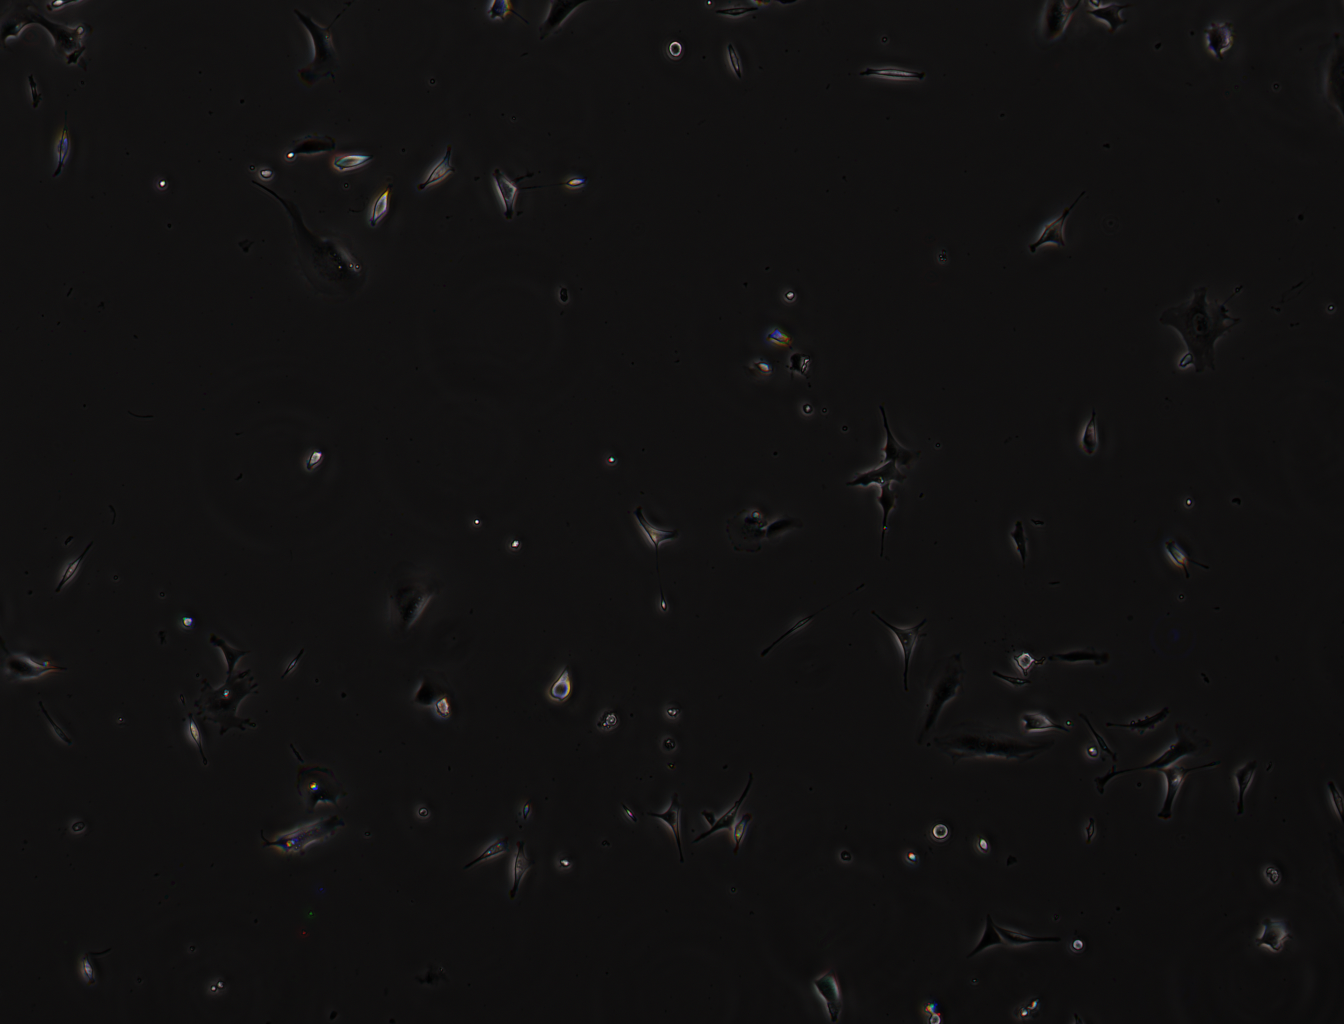

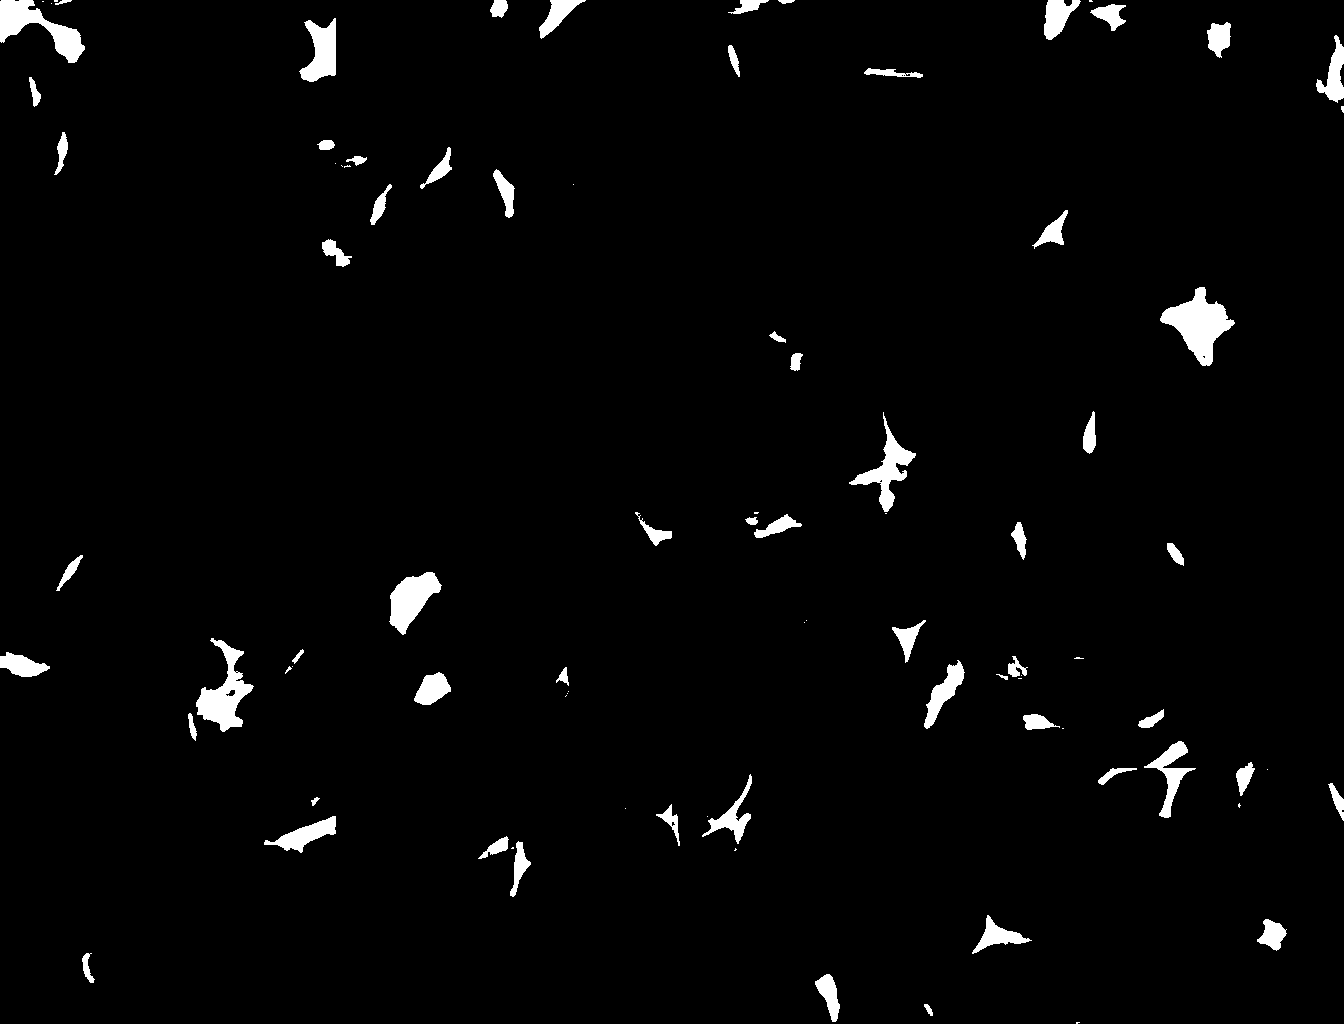

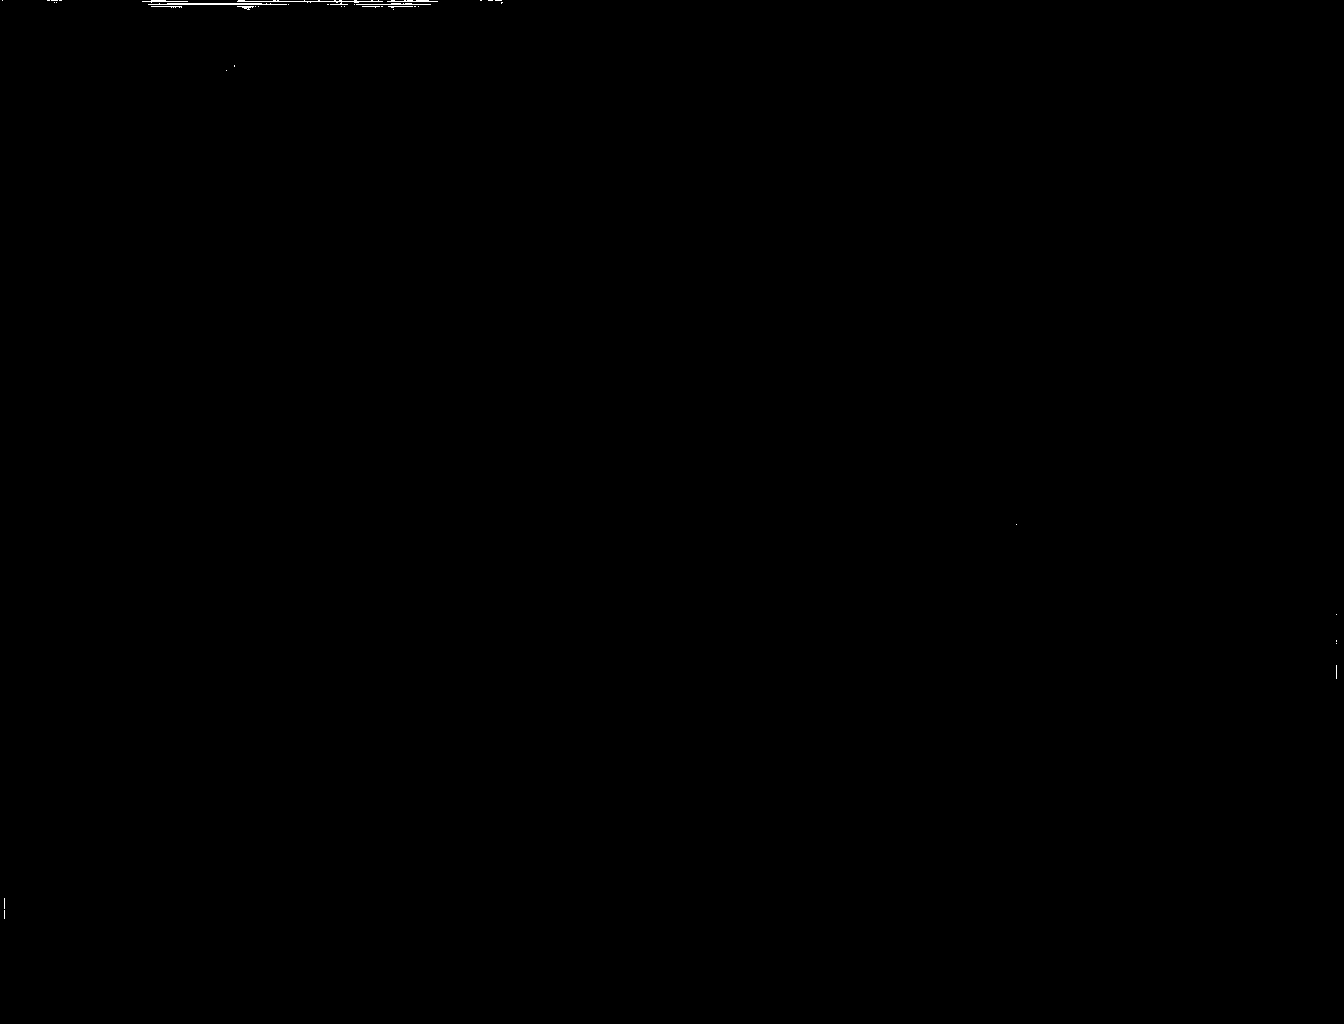

In [47]:
from PIL import ImageOps,Image

val_preds = model.predict(val_sequence)


def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


# Display results for validation image #i
i = random.randint(0,len(val_sequence.input_img_paths)-1)
i = 0
print(i)

# Display input image
display(ImageOps.autocontrast(Image.open(val_sequence.input_img_paths[i])))

# Display ground-truth target mask
img = ImageOps.autocontrast(load_img(val_sequence.target_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.

## Save Model weights, config

In [ ]:
save_model(outmodelname,model)

# Segment Experiment
Will process each folder and subfolder individually. Works great with large numbers of images split into subfolders (like stage positions) and with small numbers of images in the main folder. Pulls data from google drive.

### Loading a trained model

In [ ]:
model = load_model(segment_model_name)
model.compile(
    optimizer="rmsprop",
    loss=None,
)
model.summary()
keras.backend.clear_session()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 data (InputLayer)           [(None, None, None, 3)]      0         []                            
                                                                                                  
 bn_data (BatchNormalizatio  (None, None, None, 3)        9         ['data[0][0]']                
 n)                                                                                               
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, None, None, 3)        0         ['bn_data[0][0]']             
 g2D)                                                                                             
                                                                                            

### Prepare Images for segmentation

In [ ]:
comp_fns = [];

if do_splitting:
  comp_fns.append(create_split_image_process_fn(x_slices,y_slices,context_bounds,crop));

if do_scaling:
  comp_fns.append(create_scale_image_process_fn(scale_factor))

im_comp_fns = [prepare_image,*comp_fns];

if image_stacking:
    im_comp_fns.insert(0,create_stack_adjacents())

im_proc_fn = compose_proc_functions(im_comp_fns)
process_segmentation_images(im_proc_fn);

  3%|▎         | 117/3469 [01:15<48:03,  1.16it/s]

Skipping image p_s10_t1.TIF which is missing an image adjacency p_s10_t0.TIF.


  6%|▌         | 196/3469 [02:05<34:01,  1.60it/s]

Skipping image p_s6_t289.TIF which is missing an image adjacency p_s6_t290.TIF.


  8%|▊         | 265/3469 [02:49<47:16,  1.13it/s]

Skipping image p_s3_t1.TIF which is missing an image adjacency p_s3_t0.TIF.


 12%|█▏        | 399/3469 [04:13<28:19,  1.81it/s]

Skipping image p_s11_t1.TIF which is missing an image adjacency p_s11_t0.TIF.


 12%|█▏        | 409/3469 [04:18<35:08,  1.45it/s]

Skipping image p_s6_t1.TIF which is missing an image adjacency p_s6_t0.TIF.


 12%|█▏        | 418/3469 [04:25<33:14,  1.53it/s]

Skipping image p_s4_t1.TIF which is missing an image adjacency p_s4_t0.TIF.


 37%|███▋      | 1293/3469 [13:42<20:30,  1.77it/s]

Skipping image p_s4_t289.TIF which is missing an image adjacency p_s4_t290.TIF.


 41%|████      | 1420/3469 [15:05<29:49,  1.15it/s]

Skipping image p_s9_t289.TIF which is missing an image adjacency p_s9_t290.TIF.


 41%|████▏     | 1432/3469 [15:12<19:00,  1.79it/s]

Skipping image p_s1_t289.TIF which is missing an image adjacency p_s1_t290.TIF.


 42%|████▏     | 1443/3469 [15:18<24:59,  1.35it/s]

Skipping image p_s8_t289.TIF which is missing an image adjacency p_s8_t290.TIF.


 47%|████▋     | 1639/3469 [17:23<16:50,  1.81it/s]

Skipping image p_s5_t289.TIF which is missing an image adjacency p_s5_t290.TIF.


 53%|█████▎    | 1831/3469 [19:27<15:08,  1.80it/s]

Skipping image p_s2_t289.TIF which is missing an image adjacency p_s2_t290.TIF.


 55%|█████▍    | 1894/3469 [20:08<22:25,  1.17it/s]

Skipping image p_s7_t1.TIF which is missing an image adjacency p_s7_t0.TIF.


 56%|█████▌    | 1944/3469 [20:39<21:03,  1.21it/s]<ipython-input-83-6b7f6347bb2f>:227: UserWarning: non-image file in segmentation_images dir: p.nd
  warn(f"non-image file in {keyword} dir: {im}");
 57%|█████▋    | 1991/3469 [21:07<17:49,  1.38it/s]

Skipping image p_s11_t289.TIF which is missing an image adjacency p_s11_t290.TIF.


 65%|██████▌   | 2265/3469 [24:03<16:14,  1.23it/s]

Skipping image p_s12_t289.TIF which is missing an image adjacency p_s12_t290.TIF.


 66%|██████▌   | 2279/3469 [24:12<11:18,  1.75it/s]

Skipping image p_s5_t1.TIF which is missing an image adjacency p_s5_t0.TIF.


 70%|██████▉   | 2425/3469 [25:45<09:51,  1.77it/s]

Skipping image p_s3_t289.TIF which is missing an image adjacency p_s3_t290.TIF.


 72%|███████▏  | 2506/3469 [26:36<08:46,  1.83it/s]

Skipping image p_s7_t289.TIF which is missing an image adjacency p_s7_t290.TIF.


 84%|████████▍ | 2931/3469 [31:07<04:33,  1.97it/s]

Skipping image p_s12_t1.TIF which is missing an image adjacency p_s12_t0.TIF.


 85%|████████▍ | 2943/3469 [31:14<07:28,  1.17it/s]

Skipping image p_s2_t1.TIF which is missing an image adjacency p_s2_t0.TIF.


 89%|████████▊ | 3075/3469 [32:38<03:54,  1.68it/s]

Skipping image p_s1_t1.TIF which is missing an image adjacency p_s1_t0.TIF.


 89%|████████▉ | 3085/3469 [32:43<03:20,  1.92it/s]

Skipping image p_s9_t1.TIF which is missing an image adjacency p_s9_t0.TIF.


 92%|█████████▏| 3177/3469 [33:44<02:52,  1.69it/s]

Skipping image p_s8_t1.TIF which is missing an image adjacency p_s8_t0.TIF.


 97%|█████████▋| 3357/3469 [35:38<00:59,  1.87it/s]

Skipping image p_s10_t289.TIF which is missing an image adjacency p_s10_t290.TIF.


100%|██████████| 3469/3469 [36:51<00:00,  1.57it/s]


In [ ]:
#@title Prepare file paths and calculate remaining segmentation required
## Complicated procedure; ensures that the directory structure is fully copied from the input
## Has to broadcast over potentially multiple output folders

## prepare input file reading
subfolders = [ Path(f.path) if f.is_dir() else None for f in os.scandir(segmentation_images_folder)  ]
toplevel_images = False;
if None in subfolders:
  subfolders = [s for s in subfolders if s is not None];
  toplevel_images = True;
corresponding_outs = [segmentation_output_folder];
if len(subfolders) == 0:
  subfolders = [segmentation_images_folder];
  toplevel_images = True;
else:
  corresponding_outs = [segmentation_output_folder/f.name for f in subfolders];
  if toplevel_images:
    subfolders.append(segmentation_images_folder);
    corresponding_outs.append(segmentation_output_folder);
  for c in corresponding_outs:
    if not(os.path.exists(c)):
      os.mkdir(c);

batchSize = 32;

folderChunks = [];
for f,out in zip(subfolders,corresponding_outs):
  print("pulling files from",os.path.basename(f))
  files = get_image_files(f);
  completed_masks = os.listdir(out);
  print("input files:",len(files))
  print("output files:",len(completed_masks))
  files = [fi for fi in files if os.path.basename(fi) not in completed_masks];
  print("remaining files:",len(files))

  folderChunks.append(SegmentationSequence(batchSize,None,files));


pulling files from segmentation_images
input files: 68880
output files: 0
remaining files: 68880


### Segment images

In [ ]:
import tensorflow as tf
for fileChunks,outFolder,f in zip(folderChunks,corresponding_outs,subfolders):
    print("in:",os.path.basename(f),"out:",os.path.basename(outFolder),"count:",len(fileChunks));
    for chunk,paths in tqdm(fileChunks):
        predictions = tf.argmax(model.predict(chunk),-1) #convert parallel confidences to label index
        for path,prediction in zip(paths,predictions):
            basename = os.path.basename(path);
            im = prediction.numpy().astype('uint8');
            imsave(outFolder/basename,im,check_contrast=False);
    with open(outFolder/'segmentation_complete.flag','w') as f:
        pass;
    print("folder processing complete");

in: segmentation_images out: segmentation_masks_out count: 2153


  0%|          | 0/2153 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step


  0%|          | 1/2153 [00:02<1:29:23,  2.49s/it]

1/1 [==============================] - 0s 58ms/step


  0%|          | 2/2153 [00:03<54:07,  1.51s/it]  

1/1 [==============================] - 0s 61ms/step


  0%|          | 3/2153 [00:04<42:16,  1.18s/it]

1/1 [==============================] - 0s 62ms/step


  0%|          | 4/2153 [00:04<37:06,  1.04s/it]

1/1 [==============================] - 0s 59ms/step


  0%|          | 5/2153 [00:05<34:09,  1.05it/s]

1/1 [==============================] - 0s 59ms/step


  0%|          | 6/2153 [00:06<31:02,  1.15it/s]

1/1 [==============================] - 0s 59ms/step


  0%|          | 7/2153 [00:07<29:05,  1.23it/s]

1/1 [==============================] - 0s 62ms/step


  0%|          | 8/2153 [00:07<28:21,  1.26it/s]

1/1 [==============================] - 0s 61ms/step


  0%|          | 9/2153 [00:08<28:08,  1.27it/s]

1/1 [==============================] - 0s 66ms/step


  0%|          | 10/2153 [00:09<26:52,  1.33it/s]

1/1 [==============================] - 0s 57ms/step


  1%|          | 11/2153 [00:09<25:36,  1.39it/s]

1/1 [==============================] - 0s 78ms/step


  1%|          | 12/2153 [00:10<25:27,  1.40it/s]

1/1 [==============================] - 0s 80ms/step


  1%|          | 13/2153 [00:11<25:28,  1.40it/s]

1/1 [==============================] - 0s 79ms/step


  1%|          | 14/2153 [00:12<25:53,  1.38it/s]

1/1 [==============================] - 0s 78ms/step


  1%|          | 15/2153 [00:12<26:24,  1.35it/s]

1/1 [==============================] - 0s 80ms/step


  1%|          | 16/2153 [00:13<26:15,  1.36it/s]

1/1 [==============================] - 0s 80ms/step


  1%|          | 17/2153 [00:14<26:14,  1.36it/s]

1/1 [==============================] - 0s 84ms/step


  1%|          | 18/2153 [00:15<26:18,  1.35it/s]

1/1 [==============================] - 0s 57ms/step


  1%|          | 19/2153 [00:15<25:01,  1.42it/s]

1/1 [==============================] - 0s 60ms/step


  1%|          | 20/2153 [00:16<24:54,  1.43it/s]

1/1 [==============================] - 0s 60ms/step


  1%|          | 21/2153 [00:17<24:01,  1.48it/s]

1/1 [==============================] - 0s 66ms/step


  1%|          | 22/2153 [00:17<24:29,  1.45it/s]

1/1 [==============================] - 0s 59ms/step


  1%|          | 23/2153 [00:18<24:29,  1.45it/s]

1/1 [==============================] - 0s 57ms/step


  1%|          | 24/2153 [00:19<23:52,  1.49it/s]

1/1 [==============================] - 0s 60ms/step


  1%|          | 25/2153 [00:19<23:44,  1.49it/s]

1/1 [==============================] - 0s 59ms/step


  1%|          | 26/2153 [00:20<23:09,  1.53it/s]

1/1 [==============================] - 0s 58ms/step


  1%|▏         | 27/2153 [00:21<23:44,  1.49it/s]

1/1 [==============================] - 0s 58ms/step


  1%|▏         | 28/2153 [00:21<23:54,  1.48it/s]

1/1 [==============================] - 0s 59ms/step


  1%|▏         | 29/2153 [00:22<23:10,  1.53it/s]

1/1 [==============================] - 0s 65ms/step


  1%|▏         | 30/2153 [00:23<23:43,  1.49it/s]

1/1 [==============================] - 0s 57ms/step


  1%|▏         | 31/2153 [00:23<23:01,  1.54it/s]

1/1 [==============================] - 0s 58ms/step


  1%|▏         | 32/2153 [00:24<22:41,  1.56it/s]

1/1 [==============================] - 0s 63ms/step


  2%|▏         | 33/2153 [00:25<23:18,  1.52it/s]

1/1 [==============================] - 0s 82ms/step


  2%|▏         | 34/2153 [00:25<23:56,  1.47it/s]

1/1 [==============================] - 0s 76ms/step


  2%|▏         | 35/2153 [00:26<24:50,  1.42it/s]

1/1 [==============================] - 0s 79ms/step


  2%|▏         | 36/2153 [00:27<25:15,  1.40it/s]

1/1 [==============================] - 0s 85ms/step


  2%|▏         | 37/2153 [00:27<24:52,  1.42it/s]

1/1 [==============================] - 0s 78ms/step


  2%|▏         | 38/2153 [00:28<25:29,  1.38it/s]

1/1 [==============================] - 0s 84ms/step


  2%|▏         | 39/2153 [00:29<25:57,  1.36it/s]

1/1 [==============================] - 0s 81ms/step


  2%|▏         | 40/2153 [00:30<25:53,  1.36it/s]

1/1 [==============================] - 0s 63ms/step


  2%|▏         | 41/2153 [00:30<24:37,  1.43it/s]

1/1 [==============================] - 0s 63ms/step


  2%|▏         | 42/2153 [00:31<23:59,  1.47it/s]

1/1 [==============================] - 0s 58ms/step


  2%|▏         | 43/2153 [00:32<23:12,  1.52it/s]

1/1 [==============================] - 0s 60ms/step


  2%|▏         | 44/2153 [00:32<23:19,  1.51it/s]

1/1 [==============================] - 0s 56ms/step


  2%|▏         | 45/2153 [00:33<23:22,  1.50it/s]

1/1 [==============================] - 0s 60ms/step


  2%|▏         | 46/2153 [00:34<23:25,  1.50it/s]

1/1 [==============================] - 0s 60ms/step


  2%|▏         | 47/2153 [00:34<22:41,  1.55it/s]

1/1 [==============================] - 0s 57ms/step


  2%|▏         | 48/2153 [00:35<23:18,  1.51it/s]

1/1 [==============================] - 0s 63ms/step


  2%|▏         | 49/2153 [00:36<23:21,  1.50it/s]

1/1 [==============================] - 0s 61ms/step


  2%|▏         | 50/2153 [00:36<23:01,  1.52it/s]

1/1 [==============================] - 0s 57ms/step


  2%|▏         | 51/2153 [00:37<22:40,  1.55it/s]

1/1 [==============================] - 0s 60ms/step


  2%|▏         | 52/2153 [00:37<22:23,  1.56it/s]

1/1 [==============================] - 0s 60ms/step


  2%|▏         | 53/2153 [00:38<23:00,  1.52it/s]

1/1 [==============================] - 0s 66ms/step


  3%|▎         | 54/2153 [00:39<23:11,  1.51it/s]

1/1 [==============================] - 0s 60ms/step


  3%|▎         | 55/2153 [00:39<22:33,  1.55it/s]

1/1 [==============================] - 0s 80ms/step


  3%|▎         | 56/2153 [00:40<24:24,  1.43it/s]

1/1 [==============================] - 0s 82ms/step


  3%|▎         | 57/2153 [00:41<24:55,  1.40it/s]

1/1 [==============================] - 0s 84ms/step


  3%|▎         | 58/2153 [00:42<25:25,  1.37it/s]

1/1 [==============================] - 0s 86ms/step


  3%|▎         | 59/2153 [00:42<25:44,  1.36it/s]

1/1 [==============================] - 0s 80ms/step


  3%|▎         | 60/2153 [00:43<26:12,  1.33it/s]

1/1 [==============================] - 0s 107ms/step


  3%|▎         | 61/2153 [00:44<26:26,  1.32it/s]

1/1 [==============================] - 0s 86ms/step


  3%|▎         | 62/2153 [00:45<26:37,  1.31it/s]

1/1 [==============================] - 0s 65ms/step


  3%|▎         | 63/2153 [00:46<25:38,  1.36it/s]

1/1 [==============================] - 0s 59ms/step


  3%|▎         | 64/2153 [00:46<24:24,  1.43it/s]

1/1 [==============================] - 0s 61ms/step


  3%|▎         | 65/2153 [00:47<24:03,  1.45it/s]

1/1 [==============================] - 0s 59ms/step


  3%|▎         | 66/2153 [00:47<23:11,  1.50it/s]

1/1 [==============================] - 0s 58ms/step


  3%|▎         | 67/2153 [00:48<22:30,  1.54it/s]

1/1 [==============================] - 0s 59ms/step


  3%|▎         | 68/2153 [00:49<22:24,  1.55it/s]

1/1 [==============================] - 0s 57ms/step


  3%|▎         | 69/2153 [00:49<22:53,  1.52it/s]

1/1 [==============================] - 0s 59ms/step


  3%|▎         | 70/2153 [00:50<22:35,  1.54it/s]

1/1 [==============================] - 0s 60ms/step


  3%|▎         | 71/2153 [00:51<23:08,  1.50it/s]

1/1 [==============================] - 0s 59ms/step


  3%|▎         | 72/2153 [00:51<22:40,  1.53it/s]

1/1 [==============================] - 0s 61ms/step


  3%|▎         | 73/2153 [00:52<22:44,  1.52it/s]

1/1 [==============================] - 0s 63ms/step


  3%|▎         | 74/2153 [00:53<22:15,  1.56it/s]

1/1 [==============================] - 0s 56ms/step


  3%|▎         | 75/2153 [00:53<22:30,  1.54it/s]

1/1 [==============================] - 0s 58ms/step


  4%|▎         | 76/2153 [00:54<22:45,  1.52it/s]

1/1 [==============================] - 0s 61ms/step


  4%|▎         | 77/2153 [00:55<22:13,  1.56it/s]

1/1 [==============================] - 0s 77ms/step


  4%|▎         | 78/2153 [00:55<22:40,  1.53it/s]

1/1 [==============================] - 0s 81ms/step


  4%|▎         | 79/2153 [00:56<23:49,  1.45it/s]

1/1 [==============================] - 0s 82ms/step


  4%|▎         | 80/2153 [00:57<24:57,  1.38it/s]

1/1 [==============================] - 0s 83ms/step


  4%|▍         | 81/2153 [00:58<25:32,  1.35it/s]

1/1 [==============================] - 0s 82ms/step


  4%|▍         | 82/2153 [00:58<25:56,  1.33it/s]

1/1 [==============================] - 0s 86ms/step


  4%|▍         | 83/2153 [00:59<26:36,  1.30it/s]

1/1 [==============================] - 0s 98ms/step


  4%|▍         | 84/2153 [01:00<27:02,  1.28it/s]

1/1 [==============================] - 0s 64ms/step


  4%|▍         | 85/2153 [01:01<25:02,  1.38it/s]

1/1 [==============================] - 0s 59ms/step


  4%|▍         | 86/2153 [01:01<23:37,  1.46it/s]

1/1 [==============================] - 0s 60ms/step


  4%|▍         | 87/2153 [01:02<23:26,  1.47it/s]

1/1 [==============================] - 0s 59ms/step


  4%|▍         | 88/2153 [01:02<22:29,  1.53it/s]

1/1 [==============================] - 0s 61ms/step


  4%|▍         | 89/2153 [01:03<22:05,  1.56it/s]

1/1 [==============================] - 0s 59ms/step


  4%|▍         | 90/2153 [01:04<22:39,  1.52it/s]

1/1 [==============================] - 0s 60ms/step


  4%|▍         | 91/2153 [01:04<22:18,  1.54it/s]

1/1 [==============================] - 0s 64ms/step


  4%|▍         | 92/2153 [01:05<22:05,  1.55it/s]

1/1 [==============================] - 0s 67ms/step


  4%|▍         | 93/2153 [01:06<22:10,  1.55it/s]

1/1 [==============================] - 0s 60ms/step


  4%|▍         | 94/2153 [01:06<22:25,  1.53it/s]

1/1 [==============================] - 0s 58ms/step


  4%|▍         | 95/2153 [01:07<21:52,  1.57it/s]

1/1 [==============================] - 0s 57ms/step


  4%|▍         | 96/2153 [01:07<21:29,  1.59it/s]

1/1 [==============================] - 0s 65ms/step


  5%|▍         | 97/2153 [01:08<22:07,  1.55it/s]

1/1 [==============================] - 0s 63ms/step


  5%|▍         | 98/2153 [01:09<22:39,  1.51it/s]

1/1 [==============================] - 0s 60ms/step


  5%|▍         | 99/2153 [01:10<22:13,  1.54it/s]

1/1 [==============================] - 0s 78ms/step


  5%|▍         | 100/2153 [01:10<23:35,  1.45it/s]

1/1 [==============================] - 0s 82ms/step


  5%|▍         | 101/2153 [01:11<24:04,  1.42it/s]

1/1 [==============================] - 0s 85ms/step


  5%|▍         | 102/2153 [01:12<24:23,  1.40it/s]

1/1 [==============================] - 0s 82ms/step


  5%|▍         | 103/2153 [01:13<24:47,  1.38it/s]

1/1 [==============================] - 0s 80ms/step


  5%|▍         | 104/2153 [01:13<25:08,  1.36it/s]

1/1 [==============================] - 0s 103ms/step


  5%|▍         | 105/2153 [01:14<25:23,  1.34it/s]

1/1 [==============================] - 0s 79ms/step


  5%|▍         | 106/2153 [01:15<24:42,  1.38it/s]

1/1 [==============================] - 0s 57ms/step


  5%|▍         | 107/2153 [01:15<24:04,  1.42it/s]

1/1 [==============================] - 0s 63ms/step


  5%|▌         | 108/2153 [01:16<23:45,  1.43it/s]

1/1 [==============================] - 0s 59ms/step


  5%|▌         | 109/2153 [01:17<23:39,  1.44it/s]

1/1 [==============================] - 0s 64ms/step


  5%|▌         | 110/2153 [01:17<23:14,  1.47it/s]

1/1 [==============================] - 0s 59ms/step


  5%|▌         | 111/2153 [01:18<22:33,  1.51it/s]

1/1 [==============================] - 0s 59ms/step


  5%|▌         | 112/2153 [01:19<22:13,  1.53it/s]

1/1 [==============================] - 0s 61ms/step


  5%|▌         | 113/2153 [01:19<22:04,  1.54it/s]

1/1 [==============================] - 0s 66ms/step


  5%|▌         | 114/2153 [01:20<22:35,  1.50it/s]

1/1 [==============================] - 0s 60ms/step


  5%|▌         | 115/2153 [01:21<22:00,  1.54it/s]

1/1 [==============================] - 0s 62ms/step


  5%|▌         | 116/2153 [01:21<22:30,  1.51it/s]

1/1 [==============================] - 0s 61ms/step


  5%|▌         | 117/2153 [01:22<22:10,  1.53it/s]

1/1 [==============================] - 0s 59ms/step


  5%|▌         | 118/2153 [01:23<22:21,  1.52it/s]

1/1 [==============================] - 0s 66ms/step


  6%|▌         | 119/2153 [01:23<22:03,  1.54it/s]

1/1 [==============================] - 0s 58ms/step


  6%|▌         | 120/2153 [01:24<21:46,  1.56it/s]

1/1 [==============================] - 0s 60ms/step


  6%|▌         | 121/2153 [01:24<21:28,  1.58it/s]

1/1 [==============================] - 0s 85ms/step


  6%|▌         | 122/2153 [01:25<23:05,  1.47it/s]

1/1 [==============================] - 0s 77ms/step


  6%|▌         | 123/2153 [01:26<24:08,  1.40it/s]

1/1 [==============================] - 0s 90ms/step


  6%|▌         | 124/2153 [01:27<24:57,  1.36it/s]

1/1 [==============================] - 0s 83ms/step


  6%|▌         | 125/2153 [01:28<26:00,  1.30it/s]

1/1 [==============================] - 0s 82ms/step


  6%|▌         | 126/2153 [01:28<25:11,  1.34it/s]

1/1 [==============================] - 0s 89ms/step


  6%|▌         | 127/2153 [01:29<24:43,  1.37it/s]

1/1 [==============================] - 0s 80ms/step


  6%|▌         | 128/2153 [01:30<24:29,  1.38it/s]

1/1 [==============================] - 0s 60ms/step


  6%|▌         | 129/2153 [01:30<23:29,  1.44it/s]

1/1 [==============================] - 0s 61ms/step


  6%|▌         | 130/2153 [01:31<23:34,  1.43it/s]

1/1 [==============================] - 0s 65ms/step


  6%|▌         | 131/2153 [01:32<22:50,  1.48it/s]

1/1 [==============================] - 0s 62ms/step


  6%|▌         | 132/2153 [01:32<22:28,  1.50it/s]

1/1 [==============================] - 0s 61ms/step


  6%|▌         | 133/2153 [01:33<22:20,  1.51it/s]

1/1 [==============================] - 0s 70ms/step


  6%|▌         | 134/2153 [01:34<21:47,  1.54it/s]

1/1 [==============================] - 0s 59ms/step


  6%|▋         | 135/2153 [01:34<21:21,  1.57it/s]

1/1 [==============================] - 0s 60ms/step


  6%|▋         | 136/2153 [01:35<21:05,  1.59it/s]

1/1 [==============================] - 0s 60ms/step


  6%|▋         | 137/2153 [01:35<20:47,  1.62it/s]

1/1 [==============================] - 0s 60ms/step


  6%|▋         | 138/2153 [01:36<20:50,  1.61it/s]

1/1 [==============================] - 0s 70ms/step


  6%|▋         | 139/2153 [01:37<21:41,  1.55it/s]

1/1 [==============================] - 0s 64ms/step


  7%|▋         | 140/2153 [01:37<21:29,  1.56it/s]

1/1 [==============================] - 0s 60ms/step


  7%|▋         | 141/2153 [01:38<21:19,  1.57it/s]

1/1 [==============================] - 0s 64ms/step


  7%|▋         | 142/2153 [01:39<22:18,  1.50it/s]

1/1 [==============================] - 0s 92ms/step


  7%|▋         | 143/2153 [01:39<22:02,  1.52it/s]

1/1 [==============================] - 0s 93ms/step


  7%|▋         | 144/2153 [01:40<23:04,  1.45it/s]

1/1 [==============================] - 0s 80ms/step


  7%|▋         | 145/2153 [01:41<23:53,  1.40it/s]

1/1 [==============================] - 0s 80ms/step


  7%|▋         | 146/2153 [01:42<23:54,  1.40it/s]

1/1 [==============================] - 0s 81ms/step


  7%|▋         | 147/2153 [01:42<24:24,  1.37it/s]

1/1 [==============================] - 0s 78ms/step


  7%|▋         | 148/2153 [01:43<25:03,  1.33it/s]

1/1 [==============================] - 0s 83ms/step


  7%|▋         | 149/2153 [01:44<25:13,  1.32it/s]

1/1 [==============================] - 0s 61ms/step


  7%|▋         | 150/2153 [01:45<24:42,  1.35it/s]

1/1 [==============================] - 0s 63ms/step


  7%|▋         | 151/2153 [01:45<23:34,  1.42it/s]

1/1 [==============================] - 0s 64ms/step


  7%|▋         | 152/2153 [01:46<23:12,  1.44it/s]

1/1 [==============================] - 0s 60ms/step


  7%|▋         | 153/2153 [01:47<23:02,  1.45it/s]

1/1 [==============================] - 0s 61ms/step


  7%|▋         | 154/2153 [01:47<22:17,  1.49it/s]

1/1 [==============================] - 0s 59ms/step


  7%|▋         | 155/2153 [01:48<21:29,  1.55it/s]

1/1 [==============================] - 0s 60ms/step


  7%|▋         | 156/2153 [01:49<21:47,  1.53it/s]

1/1 [==============================] - 0s 59ms/step


  7%|▋         | 157/2153 [01:49<21:31,  1.55it/s]

1/1 [==============================] - 0s 64ms/step


  7%|▋         | 158/2153 [01:50<21:16,  1.56it/s]

1/1 [==============================] - 0s 62ms/step


  7%|▋         | 159/2153 [01:50<21:01,  1.58it/s]

1/1 [==============================] - 0s 61ms/step


  7%|▋         | 160/2153 [01:51<21:41,  1.53it/s]

1/1 [==============================] - 0s 61ms/step


  7%|▋         | 161/2153 [01:52<21:22,  1.55it/s]

1/1 [==============================] - 0s 60ms/step


  8%|▊         | 162/2153 [01:52<21:33,  1.54it/s]

1/1 [==============================] - 0s 74ms/step


  8%|▊         | 163/2153 [01:53<21:13,  1.56it/s]

1/1 [==============================] - 0s 61ms/step


  8%|▊         | 164/2153 [01:54<21:30,  1.54it/s]

1/1 [==============================] - 0s 65ms/step


  8%|▊         | 165/2153 [01:54<21:43,  1.52it/s]

1/1 [==============================] - 0s 86ms/step


  8%|▊         | 166/2153 [01:55<22:16,  1.49it/s]

1/1 [==============================] - 0s 82ms/step


  8%|▊         | 167/2153 [01:56<23:06,  1.43it/s]

1/1 [==============================] - 0s 82ms/step


  8%|▊         | 168/2153 [01:57<24:13,  1.37it/s]

1/1 [==============================] - 0s 82ms/step


  8%|▊         | 169/2153 [01:57<24:25,  1.35it/s]

1/1 [==============================] - 0s 82ms/step


  8%|▊         | 170/2153 [01:58<25:04,  1.32it/s]

1/1 [==============================] - 0s 82ms/step


  8%|▊         | 171/2153 [01:59<25:11,  1.31it/s]

1/1 [==============================] - 0s 60ms/step


  8%|▊         | 172/2153 [02:00<25:27,  1.30it/s]

1/1 [==============================] - 0s 62ms/step


  8%|▊         | 173/2153 [02:00<23:49,  1.39it/s]

1/1 [==============================] - 0s 58ms/step


  8%|▊         | 174/2153 [02:01<23:01,  1.43it/s]

1/1 [==============================] - 0s 59ms/step


  8%|▊         | 175/2153 [02:02<22:05,  1.49it/s]

1/1 [==============================] - 0s 56ms/step


  8%|▊         | 176/2153 [02:02<21:27,  1.54it/s]

1/1 [==============================] - 0s 60ms/step


  8%|▊         | 177/2153 [02:03<21:43,  1.52it/s]

1/1 [==============================] - 0s 65ms/step


  8%|▊         | 178/2153 [02:04<21:20,  1.54it/s]

1/1 [==============================] - 0s 59ms/step


  8%|▊         | 179/2153 [02:04<21:41,  1.52it/s]

1/1 [==============================] - 0s 60ms/step


  8%|▊         | 180/2153 [02:05<22:02,  1.49it/s]

1/1 [==============================] - 0s 58ms/step


  8%|▊         | 181/2153 [02:06<21:45,  1.51it/s]

1/1 [==============================] - 0s 60ms/step


  8%|▊         | 182/2153 [02:06<22:35,  1.45it/s]

1/1 [==============================] - 0s 58ms/step


  8%|▊         | 183/2153 [02:07<22:42,  1.45it/s]

1/1 [==============================] - 0s 59ms/step


  9%|▊         | 184/2153 [02:08<21:59,  1.49it/s]

1/1 [==============================] - 0s 57ms/step


  9%|▊         | 185/2153 [02:08<21:13,  1.55it/s]

1/1 [==============================] - 0s 60ms/step


  9%|▊         | 186/2153 [02:09<21:06,  1.55it/s]

1/1 [==============================] - 0s 59ms/step


  9%|▊         | 187/2153 [02:10<21:04,  1.56it/s]

1/1 [==============================] - 0s 77ms/step


  9%|▊         | 188/2153 [02:10<22:17,  1.47it/s]

1/1 [==============================] - 0s 86ms/step


  9%|▉         | 189/2153 [02:11<23:13,  1.41it/s]

1/1 [==============================] - 0s 81ms/step


  9%|▉         | 190/2153 [02:12<23:41,  1.38it/s]

1/1 [==============================] - 0s 79ms/step


  9%|▉         | 191/2153 [02:13<25:00,  1.31it/s]

1/1 [==============================] - 0s 80ms/step


  9%|▉         | 192/2153 [02:13<25:24,  1.29it/s]

1/1 [==============================] - 0s 80ms/step


  9%|▉         | 193/2153 [02:14<25:04,  1.30it/s]

1/1 [==============================] - 0s 58ms/step


  9%|▉         | 194/2153 [02:15<24:22,  1.34it/s]

1/1 [==============================] - 0s 69ms/step


  9%|▉         | 195/2153 [02:16<23:13,  1.40it/s]

1/1 [==============================] - 0s 59ms/step


  9%|▉         | 196/2153 [02:16<22:28,  1.45it/s]

1/1 [==============================] - 0s 58ms/step


  9%|▉         | 197/2153 [02:17<21:52,  1.49it/s]

1/1 [==============================] - 0s 60ms/step


  9%|▉         | 198/2153 [02:17<21:38,  1.51it/s]

1/1 [==============================] - 0s 60ms/step


  9%|▉         | 199/2153 [02:18<21:08,  1.54it/s]

1/1 [==============================] - 0s 59ms/step


  9%|▉         | 200/2153 [02:19<20:56,  1.55it/s]

1/1 [==============================] - 0s 60ms/step


  9%|▉         | 201/2153 [02:19<21:04,  1.54it/s]

1/1 [==============================] - 0s 58ms/step


  9%|▉         | 202/2153 [02:20<20:40,  1.57it/s]

1/1 [==============================] - 0s 57ms/step


  9%|▉         | 203/2153 [02:21<20:55,  1.55it/s]

1/1 [==============================] - 0s 58ms/step


  9%|▉         | 204/2153 [02:21<21:13,  1.53it/s]

1/1 [==============================] - 0s 58ms/step


 10%|▉         | 205/2153 [02:22<20:44,  1.57it/s]

1/1 [==============================] - 0s 64ms/step


 10%|▉         | 206/2153 [02:23<21:03,  1.54it/s]

1/1 [==============================] - 0s 69ms/step


 10%|▉         | 207/2153 [02:23<20:59,  1.54it/s]

1/1 [==============================] - 0s 60ms/step


 10%|▉         | 208/2153 [02:24<21:03,  1.54it/s]

1/1 [==============================] - 0s 59ms/step


 10%|▉         | 209/2153 [02:25<21:01,  1.54it/s]

1/1 [==============================] - 0s 105ms/step


 10%|▉         | 210/2153 [02:25<22:15,  1.46it/s]

1/1 [==============================] - 0s 84ms/step


 10%|▉         | 211/2153 [02:26<23:32,  1.37it/s]

1/1 [==============================] - 0s 84ms/step


 10%|▉         | 212/2153 [02:27<23:44,  1.36it/s]

1/1 [==============================] - 0s 81ms/step


 10%|▉         | 213/2153 [02:28<24:17,  1.33it/s]

1/1 [==============================] - 0s 82ms/step


 10%|▉         | 214/2153 [02:28<24:15,  1.33it/s]

1/1 [==============================] - 0s 85ms/step


 10%|▉         | 215/2153 [02:29<24:19,  1.33it/s]

1/1 [==============================] - 0s 60ms/step


 10%|█         | 216/2153 [02:30<24:12,  1.33it/s]

1/1 [==============================] - 0s 60ms/step


 10%|█         | 217/2153 [02:31<22:56,  1.41it/s]

1/1 [==============================] - 0s 62ms/step


 10%|█         | 218/2153 [02:31<22:05,  1.46it/s]

1/1 [==============================] - 0s 60ms/step


 10%|█         | 219/2153 [02:32<21:25,  1.50it/s]

1/1 [==============================] - 0s 59ms/step


 10%|█         | 220/2153 [02:32<21:12,  1.52it/s]

1/1 [==============================] - 0s 59ms/step


 10%|█         | 221/2153 [02:33<21:58,  1.47it/s]

1/1 [==============================] - 0s 57ms/step


 10%|█         | 222/2153 [02:34<21:27,  1.50it/s]

1/1 [==============================] - 0s 63ms/step


 10%|█         | 223/2153 [02:34<21:31,  1.49it/s]

1/1 [==============================] - 0s 60ms/step


 10%|█         | 224/2153 [02:35<21:01,  1.53it/s]

1/1 [==============================] - 0s 63ms/step


 10%|█         | 225/2153 [02:36<21:24,  1.50it/s]

1/1 [==============================] - 0s 61ms/step


 10%|█         | 226/2153 [02:36<21:01,  1.53it/s]

1/1 [==============================] - 0s 74ms/step


 11%|█         | 227/2153 [02:37<21:40,  1.48it/s]

1/1 [==============================] - 0s 58ms/step


 11%|█         | 228/2153 [02:38<21:13,  1.51it/s]

1/1 [==============================] - 0s 62ms/step


 11%|█         | 229/2153 [02:38<20:48,  1.54it/s]

1/1 [==============================] - 0s 63ms/step


 11%|█         | 230/2153 [02:39<20:46,  1.54it/s]

1/1 [==============================] - 0s 60ms/step


 11%|█         | 231/2153 [02:40<21:30,  1.49it/s]

1/1 [==============================] - 0s 80ms/step


 11%|█         | 232/2153 [02:41<22:31,  1.42it/s]

1/1 [==============================] - 0s 82ms/step


 11%|█         | 233/2153 [02:41<22:31,  1.42it/s]

1/1 [==============================] - 0s 86ms/step


 11%|█         | 234/2153 [02:42<22:44,  1.41it/s]

1/1 [==============================] - 0s 86ms/step


 11%|█         | 235/2153 [02:43<23:07,  1.38it/s]

1/1 [==============================] - 0s 78ms/step


 11%|█         | 236/2153 [02:43<23:08,  1.38it/s]

1/1 [==============================] - 0s 83ms/step


 11%|█         | 237/2153 [02:44<23:07,  1.38it/s]

1/1 [==============================] - 0s 60ms/step


 11%|█         | 238/2153 [02:45<22:53,  1.39it/s]

1/1 [==============================] - 0s 58ms/step


 11%|█         | 239/2153 [02:46<21:54,  1.46it/s]

1/1 [==============================] - 0s 60ms/step


 11%|█         | 240/2153 [02:46<21:27,  1.49it/s]

1/1 [==============================] - 0s 58ms/step


 11%|█         | 241/2153 [02:47<21:17,  1.50it/s]

1/1 [==============================] - 0s 62ms/step


 11%|█         | 242/2153 [02:47<20:43,  1.54it/s]

1/1 [==============================] - 0s 70ms/step


 11%|█▏        | 243/2153 [02:48<21:14,  1.50it/s]

1/1 [==============================] - 0s 62ms/step


 11%|█▏        | 244/2153 [02:49<20:48,  1.53it/s]

1/1 [==============================] - 0s 60ms/step


 11%|█▏        | 245/2153 [02:49<21:05,  1.51it/s]

1/1 [==============================] - 0s 60ms/step


 11%|█▏        | 246/2153 [02:50<20:45,  1.53it/s]

1/1 [==============================] - 0s 60ms/step


 11%|█▏        | 247/2153 [02:51<20:25,  1.55it/s]

1/1 [==============================] - 0s 59ms/step


 12%|█▏        | 248/2153 [02:51<20:18,  1.56it/s]

1/1 [==============================] - 0s 58ms/step


 12%|█▏        | 249/2153 [02:52<20:13,  1.57it/s]

1/1 [==============================] - 0s 60ms/step


 12%|█▏        | 250/2153 [02:53<20:55,  1.52it/s]

1/1 [==============================] - 0s 62ms/step


 12%|█▏        | 251/2153 [02:53<21:29,  1.48it/s]

1/1 [==============================] - 0s 59ms/step


 12%|█▏        | 252/2153 [02:54<21:06,  1.50it/s]

1/1 [==============================] - 0s 60ms/step


 12%|█▏        | 253/2153 [02:55<20:39,  1.53it/s]

1/1 [==============================] - 0s 88ms/step


 12%|█▏        | 254/2153 [02:55<21:51,  1.45it/s]

1/1 [==============================] - 0s 80ms/step


 12%|█▏        | 255/2153 [02:56<21:59,  1.44it/s]

1/1 [==============================] - 0s 78ms/step


 12%|█▏        | 256/2153 [02:57<22:00,  1.44it/s]

1/1 [==============================] - 0s 84ms/step


 12%|█▏        | 257/2153 [02:58<22:11,  1.42it/s]

1/1 [==============================] - 0s 77ms/step


 12%|█▏        | 258/2153 [02:58<23:13,  1.36it/s]

1/1 [==============================] - 0s 76ms/step


 12%|█▏        | 259/2153 [02:59<23:08,  1.36it/s]

1/1 [==============================] - 0s 81ms/step


 12%|█▏        | 260/2153 [03:00<23:30,  1.34it/s]

1/1 [==============================] - 0s 54ms/step


 12%|█▏        | 261/2153 [03:00<22:33,  1.40it/s]

1/1 [==============================] - 0s 58ms/step


 12%|█▏        | 262/2153 [03:01<21:21,  1.48it/s]

1/1 [==============================] - 0s 65ms/step


 12%|█▏        | 263/2153 [03:02<20:38,  1.53it/s]

1/1 [==============================] - 0s 60ms/step


 12%|█▏        | 264/2153 [03:02<20:06,  1.57it/s]

1/1 [==============================] - 0s 57ms/step


 12%|█▏        | 265/2153 [03:03<20:22,  1.54it/s]

1/1 [==============================] - 0s 55ms/step


 12%|█▏        | 266/2153 [03:04<20:01,  1.57it/s]

1/1 [==============================] - 0s 57ms/step


 12%|█▏        | 267/2153 [03:04<19:38,  1.60it/s]

1/1 [==============================] - 0s 62ms/step


 12%|█▏        | 268/2153 [03:05<19:41,  1.60it/s]

1/1 [==============================] - 0s 57ms/step


 12%|█▏        | 269/2153 [03:05<19:24,  1.62it/s]

1/1 [==============================] - 0s 58ms/step


 13%|█▎        | 270/2153 [03:06<20:19,  1.54it/s]

1/1 [==============================] - 0s 56ms/step


 13%|█▎        | 271/2153 [03:07<19:44,  1.59it/s]

1/1 [==============================] - 0s 57ms/step


 13%|█▎        | 272/2153 [03:07<19:21,  1.62it/s]

1/1 [==============================] - 0s 60ms/step


 13%|█▎        | 273/2153 [03:08<19:17,  1.62it/s]

1/1 [==============================] - 0s 59ms/step


 13%|█▎        | 274/2153 [03:09<19:18,  1.62it/s]

1/1 [==============================] - 0s 59ms/step


 13%|█▎        | 275/2153 [03:09<19:49,  1.58it/s]

1/1 [==============================] - 0s 56ms/step


 13%|█▎        | 276/2153 [03:10<20:29,  1.53it/s]

1/1 [==============================] - 0s 74ms/step


 13%|█▎        | 277/2153 [03:11<20:47,  1.50it/s]

1/1 [==============================] - 0s 73ms/step


 13%|█▎        | 278/2153 [03:11<21:48,  1.43it/s]

1/1 [==============================] - 0s 76ms/step


 13%|█▎        | 279/2153 [03:12<21:40,  1.44it/s]

1/1 [==============================] - 0s 78ms/step


 13%|█▎        | 280/2153 [03:13<23:10,  1.35it/s]

1/1 [==============================] - 0s 80ms/step


 13%|█▎        | 281/2153 [03:14<23:06,  1.35it/s]

1/1 [==============================] - 0s 72ms/step


 13%|█▎        | 282/2153 [03:14<22:48,  1.37it/s]

1/1 [==============================] - 0s 55ms/step


 13%|█▎        | 283/2153 [03:15<21:22,  1.46it/s]

1/1 [==============================] - 0s 59ms/step


 13%|█▎        | 284/2153 [03:16<21:05,  1.48it/s]

1/1 [==============================] - 0s 59ms/step


 13%|█▎        | 285/2153 [03:16<20:18,  1.53it/s]

1/1 [==============================] - 0s 58ms/step


 13%|█▎        | 286/2153 [03:17<19:52,  1.57it/s]

1/1 [==============================] - 0s 59ms/step


 13%|█▎        | 287/2153 [03:17<19:37,  1.59it/s]

1/1 [==============================] - 0s 56ms/step


 13%|█▎        | 288/2153 [03:18<20:18,  1.53it/s]

1/1 [==============================] - 0s 56ms/step


 13%|█▎        | 289/2153 [03:19<19:51,  1.56it/s]

1/1 [==============================] - 0s 60ms/step


 13%|█▎        | 290/2153 [03:19<20:44,  1.50it/s]

1/1 [==============================] - 0s 54ms/step


 14%|█▎        | 291/2153 [03:20<20:40,  1.50it/s]

1/1 [==============================] - 0s 55ms/step


 14%|█▎        | 292/2153 [03:21<20:37,  1.50it/s]

1/1 [==============================] - 0s 56ms/step


 14%|█▎        | 293/2153 [03:21<19:51,  1.56it/s]

1/1 [==============================] - 0s 58ms/step


 14%|█▎        | 294/2153 [03:22<20:00,  1.55it/s]

1/1 [==============================] - 0s 57ms/step


 14%|█▎        | 295/2153 [03:23<20:00,  1.55it/s]

1/1 [==============================] - 0s 61ms/step


 14%|█▎        | 296/2153 [03:23<19:34,  1.58it/s]

1/1 [==============================] - 0s 58ms/step


 14%|█▍        | 297/2153 [03:24<19:15,  1.61it/s]

1/1 [==============================] - 0s 55ms/step


 14%|█▍        | 298/2153 [03:25<20:05,  1.54it/s]

1/1 [==============================] - 0s 83ms/step


 14%|█▍        | 299/2153 [03:25<20:18,  1.52it/s]

1/1 [==============================] - 0s 80ms/step


 14%|█▍        | 300/2153 [03:26<22:47,  1.35it/s]

1/1 [==============================] - 0s 71ms/step


 14%|█▍        | 301/2153 [03:27<22:45,  1.36it/s]

1/1 [==============================] - 0s 82ms/step


 14%|█▍        | 302/2153 [03:28<22:35,  1.37it/s]

1/1 [==============================] - 0s 89ms/step


 14%|█▍        | 303/2153 [03:28<22:07,  1.39it/s]

1/1 [==============================] - 0s 78ms/step


 14%|█▍        | 304/2153 [03:29<22:32,  1.37it/s]

1/1 [==============================] - 0s 59ms/step


 14%|█▍        | 305/2153 [03:30<21:24,  1.44it/s]

1/1 [==============================] - 0s 60ms/step


 14%|█▍        | 306/2153 [03:30<20:40,  1.49it/s]

1/1 [==============================] - 0s 57ms/step


 14%|█▍        | 307/2153 [03:31<19:59,  1.54it/s]

1/1 [==============================] - 0s 70ms/step


 14%|█▍        | 308/2153 [03:32<19:36,  1.57it/s]

1/1 [==============================] - 0s 59ms/step


 14%|█▍        | 309/2153 [03:32<19:12,  1.60it/s]

1/1 [==============================] - 0s 57ms/step


 14%|█▍        | 310/2153 [03:33<20:06,  1.53it/s]

1/1 [==============================] - 0s 57ms/step


 14%|█▍        | 311/2153 [03:33<20:15,  1.51it/s]

1/1 [==============================] - 0s 57ms/step


 14%|█▍        | 312/2153 [03:34<19:37,  1.56it/s]

1/1 [==============================] - 0s 58ms/step


 15%|█▍        | 313/2153 [03:35<19:07,  1.60it/s]

1/1 [==============================] - 0s 55ms/step


 15%|█▍        | 314/2153 [03:35<18:47,  1.63it/s]

1/1 [==============================] - 0s 59ms/step


 15%|█▍        | 315/2153 [03:36<19:12,  1.59it/s]

1/1 [==============================] - 0s 55ms/step


 15%|█▍        | 316/2153 [03:37<18:57,  1.61it/s]

1/1 [==============================] - 0s 56ms/step


 15%|█▍        | 317/2153 [03:37<19:19,  1.58it/s]

1/1 [==============================] - 0s 56ms/step


 15%|█▍        | 318/2153 [03:38<19:29,  1.57it/s]

1/1 [==============================] - 0s 55ms/step


 15%|█▍        | 319/2153 [03:38<19:04,  1.60it/s]

1/1 [==============================] - 0s 65ms/step


 15%|█▍        | 320/2153 [03:39<19:51,  1.54it/s]

1/1 [==============================] - 0s 72ms/step


 15%|█▍        | 321/2153 [03:40<20:49,  1.47it/s]

1/1 [==============================] - 0s 106ms/step


 15%|█▍        | 322/2153 [03:41<21:10,  1.44it/s]

1/1 [==============================] - 0s 74ms/step


 15%|█▌        | 323/2153 [03:41<20:49,  1.46it/s]

1/1 [==============================] - 0s 77ms/step


 15%|█▌        | 324/2153 [03:42<20:54,  1.46it/s]

1/1 [==============================] - 0s 83ms/step


 15%|█▌        | 325/2153 [03:43<21:21,  1.43it/s]

1/1 [==============================] - 0s 78ms/step


 15%|█▌        | 326/2153 [03:43<21:58,  1.39it/s]

1/1 [==============================] - 0s 88ms/step


 15%|█▌        | 327/2153 [03:44<22:04,  1.38it/s]

1/1 [==============================] - 0s 56ms/step


 15%|█▌        | 328/2153 [03:45<22:02,  1.38it/s]

1/1 [==============================] - 0s 56ms/step


 15%|█▌        | 329/2153 [03:46<21:34,  1.41it/s]

1/1 [==============================] - 0s 90ms/step


 15%|█▌        | 330/2153 [03:46<21:39,  1.40it/s]

1/1 [==============================] - 0s 53ms/step


 15%|█▌        | 331/2153 [03:47<21:09,  1.44it/s]

1/1 [==============================] - 0s 56ms/step


 15%|█▌        | 332/2153 [03:48<20:11,  1.50it/s]

1/1 [==============================] - 0s 54ms/step


 15%|█▌        | 333/2153 [03:48<20:04,  1.51it/s]

1/1 [==============================] - 0s 56ms/step


 16%|█▌        | 334/2153 [03:49<19:30,  1.55it/s]

1/1 [==============================] - 0s 57ms/step


 16%|█▌        | 335/2153 [03:49<19:03,  1.59it/s]

1/1 [==============================] - 0s 62ms/step


 16%|█▌        | 336/2153 [03:50<18:51,  1.61it/s]

1/1 [==============================] - 0s 55ms/step


 16%|█▌        | 337/2153 [03:51<19:31,  1.55it/s]

1/1 [==============================] - 0s 56ms/step


 16%|█▌        | 338/2153 [03:51<19:13,  1.57it/s]

1/1 [==============================] - 0s 57ms/step


 16%|█▌        | 339/2153 [03:52<19:43,  1.53it/s]

1/1 [==============================] - 0s 56ms/step


 16%|█▌        | 340/2153 [03:53<20:31,  1.47it/s]

1/1 [==============================] - 0s 59ms/step


 16%|█▌        | 341/2153 [03:53<19:46,  1.53it/s]

1/1 [==============================] - 0s 54ms/step


 16%|█▌        | 342/2153 [03:54<20:14,  1.49it/s]

1/1 [==============================] - 0s 72ms/step


 16%|█▌        | 343/2153 [03:55<20:52,  1.45it/s]

1/1 [==============================] - 0s 74ms/step


 16%|█▌        | 344/2153 [03:56<20:58,  1.44it/s]

1/1 [==============================] - 0s 84ms/step


 16%|█▌        | 345/2153 [03:56<21:21,  1.41it/s]

1/1 [==============================] - 0s 76ms/step


 16%|█▌        | 346/2153 [03:57<21:33,  1.40it/s]

1/1 [==============================] - 0s 79ms/step


 16%|█▌        | 347/2153 [03:58<21:47,  1.38it/s]

1/1 [==============================] - 0s 74ms/step


 16%|█▌        | 348/2153 [03:59<22:39,  1.33it/s]

1/1 [==============================] - 0s 56ms/step


 16%|█▌        | 349/2153 [03:59<21:36,  1.39it/s]

1/1 [==============================] - 0s 56ms/step


 16%|█▋        | 350/2153 [04:00<20:36,  1.46it/s]

1/1 [==============================] - 0s 60ms/step


 16%|█▋        | 351/2153 [04:00<19:48,  1.52it/s]

1/1 [==============================] - 0s 54ms/step


 16%|█▋        | 352/2153 [04:01<19:06,  1.57it/s]

1/1 [==============================] - 0s 59ms/step


 16%|█▋        | 353/2153 [04:02<19:16,  1.56it/s]

1/1 [==============================] - 0s 56ms/step


 16%|█▋        | 354/2153 [04:02<20:03,  1.49it/s]

1/1 [==============================] - 0s 57ms/step


 16%|█▋        | 355/2153 [04:03<19:26,  1.54it/s]

1/1 [==============================] - 0s 55ms/step


 17%|█▋        | 356/2153 [04:04<19:16,  1.55it/s]

1/1 [==============================] - 0s 55ms/step


 17%|█▋        | 357/2153 [04:04<18:53,  1.58it/s]

1/1 [==============================] - 0s 55ms/step


 17%|█▋        | 358/2153 [04:05<18:49,  1.59it/s]

1/1 [==============================] - 0s 60ms/step


 17%|█▋        | 359/2153 [04:05<18:52,  1.58it/s]

1/1 [==============================] - 0s 59ms/step


 17%|█▋        | 360/2153 [04:06<19:05,  1.57it/s]

1/1 [==============================] - 0s 56ms/step


 17%|█▋        | 361/2153 [04:07<18:42,  1.60it/s]

1/1 [==============================] - 0s 56ms/step


 17%|█▋        | 362/2153 [04:07<18:51,  1.58it/s]

1/1 [==============================] - 0s 57ms/step


 17%|█▋        | 363/2153 [04:08<18:33,  1.61it/s]

1/1 [==============================] - 0s 65ms/step


 17%|█▋        | 364/2153 [04:09<19:02,  1.57it/s]

1/1 [==============================] - 0s 74ms/step


 17%|█▋        | 365/2153 [04:09<19:25,  1.53it/s]

1/1 [==============================] - 0s 73ms/step


 17%|█▋        | 366/2153 [04:10<20:15,  1.47it/s]

1/1 [==============================] - 0s 81ms/step


 17%|█▋        | 367/2153 [04:11<21:11,  1.40it/s]

1/1 [==============================] - 0s 75ms/step


 17%|█▋        | 368/2153 [04:12<21:51,  1.36it/s]

1/1 [==============================] - 0s 85ms/step


 17%|█▋        | 369/2153 [04:12<22:03,  1.35it/s]

1/1 [==============================] - 0s 80ms/step


 17%|█▋        | 370/2153 [04:13<21:39,  1.37it/s]

1/1 [==============================] - 0s 87ms/step


 17%|█▋        | 371/2153 [04:14<21:48,  1.36it/s]

1/1 [==============================] - 0s 56ms/step


 17%|█▋        | 372/2153 [04:14<20:33,  1.44it/s]

1/1 [==============================] - 0s 55ms/step


 17%|█▋        | 373/2153 [04:15<19:38,  1.51it/s]

1/1 [==============================] - 0s 54ms/step


 17%|█▋        | 374/2153 [04:16<19:09,  1.55it/s]

1/1 [==============================] - 0s 57ms/step


 17%|█▋        | 375/2153 [04:16<19:20,  1.53it/s]

1/1 [==============================] - 0s 56ms/step


 17%|█▋        | 376/2153 [04:17<19:15,  1.54it/s]

1/1 [==============================] - 0s 56ms/step


 18%|█▊        | 377/2153 [04:18<18:51,  1.57it/s]

1/1 [==============================] - 0s 57ms/step


 18%|█▊        | 378/2153 [04:18<19:01,  1.56it/s]

1/1 [==============================] - 0s 57ms/step


 18%|█▊        | 379/2153 [04:19<18:57,  1.56it/s]

1/1 [==============================] - 0s 57ms/step


 18%|█▊        | 380/2153 [04:20<19:07,  1.55it/s]

1/1 [==============================] - 0s 56ms/step


 18%|█▊        | 381/2153 [04:20<18:45,  1.57it/s]

1/1 [==============================] - 0s 57ms/step


 18%|█▊        | 382/2153 [04:21<19:05,  1.55it/s]

1/1 [==============================] - 0s 56ms/step


 18%|█▊        | 383/2153 [04:21<18:40,  1.58it/s]

1/1 [==============================] - 0s 64ms/step


 18%|█▊        | 384/2153 [04:22<18:20,  1.61it/s]

1/1 [==============================] - 0s 55ms/step


 18%|█▊        | 385/2153 [04:23<18:15,  1.61it/s]

1/1 [==============================] - 0s 55ms/step


 18%|█▊        | 386/2153 [04:23<18:19,  1.61it/s]

1/1 [==============================] - 0s 57ms/step


 18%|█▊        | 387/2153 [04:24<18:17,  1.61it/s]

1/1 [==============================] - 0s 73ms/step


 18%|█▊        | 388/2153 [04:25<19:57,  1.47it/s]

1/1 [==============================] - 0s 77ms/step


 18%|█▊        | 389/2153 [04:25<20:30,  1.43it/s]

1/1 [==============================] - 0s 80ms/step


 18%|█▊        | 390/2153 [04:26<20:57,  1.40it/s]

1/1 [==============================] - 0s 77ms/step


 18%|█▊        | 391/2153 [04:27<21:15,  1.38it/s]

1/1 [==============================] - 0s 80ms/step


 18%|█▊        | 392/2153 [04:28<20:53,  1.40it/s]

1/1 [==============================] - 0s 90ms/step


 18%|█▊        | 393/2153 [04:28<21:28,  1.37it/s]

1/1 [==============================] - 0s 60ms/step


 18%|█▊        | 394/2153 [04:29<20:59,  1.40it/s]

1/1 [==============================] - 0s 56ms/step


 18%|█▊        | 395/2153 [04:30<20:08,  1.45it/s]

1/1 [==============================] - 0s 61ms/step


 18%|█▊        | 396/2153 [04:30<19:51,  1.47it/s]

1/1 [==============================] - 0s 57ms/step


 18%|█▊        | 397/2153 [04:31<19:21,  1.51it/s]

1/1 [==============================] - 0s 59ms/step


 18%|█▊        | 398/2153 [04:32<19:43,  1.48it/s]

1/1 [==============================] - 0s 67ms/step


 19%|█▊        | 399/2153 [04:32<19:34,  1.49it/s]

1/1 [==============================] - 0s 57ms/step


 19%|█▊        | 400/2153 [04:33<19:14,  1.52it/s]

1/1 [==============================] - 0s 56ms/step


 19%|█▊        | 401/2153 [04:34<18:47,  1.55it/s]

1/1 [==============================] - 0s 57ms/step


 19%|█▊        | 402/2153 [04:34<19:05,  1.53it/s]

1/1 [==============================] - 0s 60ms/step


 19%|█▊        | 403/2153 [04:35<18:38,  1.57it/s]

1/1 [==============================] - 0s 59ms/step


 19%|█▉        | 404/2153 [04:35<18:38,  1.56it/s]

1/1 [==============================] - 0s 60ms/step


 19%|█▉        | 405/2153 [04:36<20:15,  1.44it/s]

1/1 [==============================] - 0s 60ms/step


 19%|█▉        | 406/2153 [04:37<19:44,  1.48it/s]

1/1 [==============================] - 0s 56ms/step


 19%|█▉        | 407/2153 [04:38<19:02,  1.53it/s]

1/1 [==============================] - 0s 58ms/step


 19%|█▉        | 408/2153 [04:38<19:33,  1.49it/s]

1/1 [==============================] - 0s 78ms/step


 19%|█▉        | 409/2153 [04:39<20:01,  1.45it/s]

1/1 [==============================] - 0s 83ms/step


 19%|█▉        | 410/2153 [04:40<21:01,  1.38it/s]

1/1 [==============================] - 0s 73ms/step


 19%|█▉        | 411/2153 [04:40<20:44,  1.40it/s]

1/1 [==============================] - 0s 74ms/step


 19%|█▉        | 412/2153 [04:41<21:25,  1.35it/s]

1/1 [==============================] - 0s 75ms/step


 19%|█▉        | 413/2153 [04:42<20:54,  1.39it/s]

1/1 [==============================] - 0s 100ms/step


 19%|█▉        | 414/2153 [04:43<21:11,  1.37it/s]

1/1 [==============================] - 0s 87ms/step


 19%|█▉        | 415/2153 [04:43<21:00,  1.38it/s]

1/1 [==============================] - 0s 57ms/step


 19%|█▉        | 416/2153 [04:44<20:52,  1.39it/s]

1/1 [==============================] - 0s 57ms/step


 19%|█▉        | 417/2153 [04:45<20:04,  1.44it/s]

1/1 [==============================] - 0s 58ms/step


 19%|█▉        | 418/2153 [04:45<19:29,  1.48it/s]

1/1 [==============================] - 0s 56ms/step


 19%|█▉        | 419/2153 [04:46<19:14,  1.50it/s]

1/1 [==============================] - 0s 55ms/step


 20%|█▉        | 420/2153 [04:47<19:53,  1.45it/s]

1/1 [==============================] - 0s 63ms/step


 20%|█▉        | 421/2153 [04:47<19:48,  1.46it/s]

1/1 [==============================] - 0s 58ms/step


 20%|█▉        | 422/2153 [04:48<19:05,  1.51it/s]

1/1 [==============================] - 0s 57ms/step


 20%|█▉        | 423/2153 [04:49<19:07,  1.51it/s]

1/1 [==============================] - 0s 59ms/step


 20%|█▉        | 424/2153 [04:49<18:44,  1.54it/s]

1/1 [==============================] - 0s 57ms/step


 20%|█▉        | 425/2153 [04:50<18:29,  1.56it/s]

1/1 [==============================] - 0s 58ms/step


 20%|█▉        | 426/2153 [04:51<18:34,  1.55it/s]

1/1 [==============================] - 0s 63ms/step


 20%|█▉        | 427/2153 [04:51<18:24,  1.56it/s]

1/1 [==============================] - 0s 64ms/step


 20%|█▉        | 428/2153 [04:52<18:43,  1.53it/s]

1/1 [==============================] - 0s 60ms/step


 20%|█▉        | 429/2153 [04:53<18:58,  1.51it/s]

1/1 [==============================] - 0s 58ms/step


 20%|█▉        | 430/2153 [04:53<18:51,  1.52it/s]

1/1 [==============================] - 0s 94ms/step


 20%|██        | 431/2153 [04:54<19:48,  1.45it/s]

1/1 [==============================] - 0s 119ms/step


 20%|██        | 432/2153 [04:55<20:34,  1.39it/s]

1/1 [==============================] - 0s 88ms/step


 20%|██        | 433/2153 [04:56<21:11,  1.35it/s]

1/1 [==============================] - 0s 82ms/step


 20%|██        | 434/2153 [04:56<21:42,  1.32it/s]

1/1 [==============================] - 0s 84ms/step


 20%|██        | 435/2153 [04:57<21:52,  1.31it/s]

1/1 [==============================] - 0s 78ms/step


 20%|██        | 436/2153 [04:58<22:15,  1.29it/s]

1/1 [==============================] - 0s 91ms/step


 20%|██        | 437/2153 [04:59<22:21,  1.28it/s]

1/1 [==============================] - 0s 65ms/step


 20%|██        | 438/2153 [05:00<21:50,  1.31it/s]

1/1 [==============================] - 0s 81ms/step


 20%|██        | 439/2153 [05:00<21:29,  1.33it/s]

1/1 [==============================] - 0s 57ms/step


 20%|██        | 440/2153 [05:01<20:56,  1.36it/s]

1/1 [==============================] - 0s 58ms/step


 20%|██        | 441/2153 [05:02<20:40,  1.38it/s]

1/1 [==============================] - 0s 61ms/step


 21%|██        | 442/2153 [05:02<19:42,  1.45it/s]

1/1 [==============================] - 0s 60ms/step


 21%|██        | 443/2153 [05:03<19:38,  1.45it/s]

1/1 [==============================] - 0s 56ms/step


 21%|██        | 444/2153 [05:04<19:33,  1.46it/s]

1/1 [==============================] - 0s 59ms/step


 21%|██        | 445/2153 [05:04<19:31,  1.46it/s]

1/1 [==============================] - 0s 60ms/step


 21%|██        | 446/2153 [05:05<19:05,  1.49it/s]

1/1 [==============================] - 0s 58ms/step


 21%|██        | 447/2153 [05:06<19:34,  1.45it/s]

1/1 [==============================] - 0s 60ms/step


 21%|██        | 448/2153 [05:06<19:49,  1.43it/s]

1/1 [==============================] - 0s 58ms/step


 21%|██        | 449/2153 [05:07<19:23,  1.47it/s]

1/1 [==============================] - 0s 58ms/step


 21%|██        | 450/2153 [05:08<18:58,  1.50it/s]

1/1 [==============================] - 0s 61ms/step


 21%|██        | 451/2153 [05:08<19:06,  1.48it/s]

1/1 [==============================] - 0s 89ms/step


 21%|██        | 452/2153 [05:09<19:46,  1.43it/s]

1/1 [==============================] - 0s 79ms/step


 21%|██        | 453/2153 [05:10<20:13,  1.40it/s]

1/1 [==============================] - 0s 91ms/step


 21%|██        | 454/2153 [05:11<21:00,  1.35it/s]

1/1 [==============================] - 0s 79ms/step


 21%|██        | 455/2153 [05:11<21:08,  1.34it/s]

1/1 [==============================] - 0s 82ms/step


 21%|██        | 456/2153 [05:12<22:00,  1.29it/s]

1/1 [==============================] - 0s 84ms/step


 21%|██        | 457/2153 [05:13<22:05,  1.28it/s]

1/1 [==============================] - 0s 76ms/step


 21%|██▏       | 458/2153 [05:14<22:21,  1.26it/s]

1/1 [==============================] - 0s 56ms/step


 21%|██▏       | 459/2153 [05:15<20:58,  1.35it/s]

1/1 [==============================] - 0s 56ms/step


 21%|██▏       | 460/2153 [05:15<19:47,  1.43it/s]

1/1 [==============================] - 0s 63ms/step


 21%|██▏       | 461/2153 [05:16<19:33,  1.44it/s]

1/1 [==============================] - 0s 56ms/step


 21%|██▏       | 462/2153 [05:16<18:48,  1.50it/s]

1/1 [==============================] - 0s 54ms/step


 22%|██▏       | 463/2153 [05:17<18:50,  1.49it/s]

1/1 [==============================] - 0s 56ms/step


 22%|██▏       | 464/2153 [05:18<18:24,  1.53it/s]

1/1 [==============================] - 0s 55ms/step


 22%|██▏       | 465/2153 [05:18<18:30,  1.52it/s]

1/1 [==============================] - 0s 57ms/step


 22%|██▏       | 466/2153 [05:19<18:18,  1.54it/s]

1/1 [==============================] - 0s 54ms/step


 22%|██▏       | 467/2153 [05:20<18:29,  1.52it/s]

1/1 [==============================] - 0s 57ms/step


 22%|██▏       | 468/2153 [05:20<19:18,  1.45it/s]

1/1 [==============================] - 0s 55ms/step


 22%|██▏       | 469/2153 [05:21<18:29,  1.52it/s]

1/1 [==============================] - 0s 59ms/step


 22%|██▏       | 470/2153 [05:22<18:17,  1.53it/s]

1/1 [==============================] - 0s 55ms/step


 22%|██▏       | 471/2153 [05:22<18:24,  1.52it/s]

1/1 [==============================] - 0s 63ms/step


 22%|██▏       | 472/2153 [05:23<18:08,  1.54it/s]

1/1 [==============================] - 0s 56ms/step


 22%|██▏       | 473/2153 [05:24<18:19,  1.53it/s]

1/1 [==============================] - 0s 95ms/step


 22%|██▏       | 474/2153 [05:24<19:45,  1.42it/s]

1/1 [==============================] - 0s 78ms/step


 22%|██▏       | 475/2153 [05:25<19:48,  1.41it/s]

1/1 [==============================] - 0s 87ms/step


 22%|██▏       | 476/2153 [05:26<20:40,  1.35it/s]

1/1 [==============================] - 0s 75ms/step


 22%|██▏       | 477/2153 [05:27<20:52,  1.34it/s]

1/1 [==============================] - 0s 78ms/step


 22%|██▏       | 478/2153 [05:28<22:08,  1.26it/s]

1/1 [==============================] - 0s 82ms/step


 22%|██▏       | 479/2153 [05:28<21:42,  1.28it/s]

1/1 [==============================] - 0s 56ms/step


 22%|██▏       | 480/2153 [05:29<20:48,  1.34it/s]

1/1 [==============================] - 0s 54ms/step


 22%|██▏       | 481/2153 [05:30<19:25,  1.43it/s]

1/1 [==============================] - 0s 54ms/step


 22%|██▏       | 482/2153 [05:30<18:55,  1.47it/s]

1/1 [==============================] - 0s 64ms/step


 22%|██▏       | 483/2153 [05:31<18:50,  1.48it/s]

1/1 [==============================] - 0s 55ms/step


 22%|██▏       | 484/2153 [05:32<18:55,  1.47it/s]

1/1 [==============================] - 0s 59ms/step


 23%|██▎       | 485/2153 [05:32<18:56,  1.47it/s]

1/1 [==============================] - 0s 57ms/step


 23%|██▎       | 486/2153 [05:33<18:40,  1.49it/s]

1/1 [==============================] - 0s 56ms/step


 23%|██▎       | 487/2153 [05:34<18:12,  1.53it/s]

1/1 [==============================] - 0s 60ms/step


 23%|██▎       | 488/2153 [05:34<18:40,  1.49it/s]

1/1 [==============================] - 0s 59ms/step


 23%|██▎       | 489/2153 [05:35<18:48,  1.47it/s]

1/1 [==============================] - 0s 61ms/step


 23%|██▎       | 490/2153 [05:36<19:04,  1.45it/s]

1/1 [==============================] - 0s 64ms/step


 23%|██▎       | 491/2153 [05:36<18:29,  1.50it/s]

1/1 [==============================] - 0s 58ms/step


 23%|██▎       | 492/2153 [05:37<18:01,  1.54it/s]

1/1 [==============================] - 0s 58ms/step


 23%|██▎       | 493/2153 [05:38<18:16,  1.51it/s]

1/1 [==============================] - 0s 59ms/step


 23%|██▎       | 494/2153 [05:38<18:29,  1.50it/s]

1/1 [==============================] - 0s 78ms/step


 23%|██▎       | 495/2153 [05:39<18:46,  1.47it/s]

1/1 [==============================] - 0s 75ms/step


 23%|██▎       | 496/2153 [05:40<19:35,  1.41it/s]

1/1 [==============================] - 0s 94ms/step


 23%|██▎       | 497/2153 [05:40<19:36,  1.41it/s]

1/1 [==============================] - 0s 72ms/step


 23%|██▎       | 498/2153 [05:41<20:41,  1.33it/s]

1/1 [==============================] - 0s 79ms/step


 23%|██▎       | 499/2153 [05:42<20:36,  1.34it/s]

1/1 [==============================] - 0s 80ms/step


 23%|██▎       | 500/2153 [05:43<20:15,  1.36it/s]

1/1 [==============================] - 0s 79ms/step


 23%|██▎       | 501/2153 [05:43<19:39,  1.40it/s]

1/1 [==============================] - 0s 55ms/step


 23%|██▎       | 502/2153 [05:44<19:15,  1.43it/s]

1/1 [==============================] - 0s 55ms/step


 23%|██▎       | 503/2153 [05:45<18:21,  1.50it/s]

1/1 [==============================] - 0s 55ms/step


 23%|██▎       | 504/2153 [05:45<18:33,  1.48it/s]

1/1 [==============================] - 0s 60ms/step


 23%|██▎       | 505/2153 [05:46<18:50,  1.46it/s]

1/1 [==============================] - 0s 58ms/step


 24%|██▎       | 506/2153 [05:47<18:41,  1.47it/s]

1/1 [==============================] - 0s 56ms/step


 24%|██▎       | 507/2153 [05:47<18:03,  1.52it/s]

1/1 [==============================] - 0s 58ms/step


 24%|██▎       | 508/2153 [05:48<18:11,  1.51it/s]

1/1 [==============================] - 0s 65ms/step


 24%|██▎       | 509/2153 [05:49<17:45,  1.54it/s]

1/1 [==============================] - 0s 58ms/step


 24%|██▎       | 510/2153 [05:49<17:35,  1.56it/s]

1/1 [==============================] - 0s 55ms/step


 24%|██▎       | 511/2153 [05:50<17:26,  1.57it/s]

1/1 [==============================] - 0s 55ms/step


 24%|██▍       | 512/2153 [05:51<17:18,  1.58it/s]

1/1 [==============================] - 0s 57ms/step


 24%|██▍       | 513/2153 [05:51<17:03,  1.60it/s]

1/1 [==============================] - 0s 61ms/step


 24%|██▍       | 514/2153 [05:52<17:41,  1.54it/s]

1/1 [==============================] - 0s 57ms/step


 24%|██▍       | 515/2153 [05:52<17:19,  1.58it/s]

1/1 [==============================] - 0s 54ms/step


 24%|██▍       | 516/2153 [05:53<17:08,  1.59it/s]

1/1 [==============================] - 0s 76ms/step


 24%|██▍       | 517/2153 [05:54<17:38,  1.55it/s]

1/1 [==============================] - 0s 75ms/step


 24%|██▍       | 518/2153 [05:55<19:32,  1.39it/s]

1/1 [==============================] - 0s 75ms/step


 24%|██▍       | 519/2153 [05:55<19:15,  1.41it/s]

1/1 [==============================] - 0s 98ms/step


 24%|██▍       | 520/2153 [05:56<19:32,  1.39it/s]

1/1 [==============================] - 0s 73ms/step


 24%|██▍       | 521/2153 [05:57<19:20,  1.41it/s]

1/1 [==============================] - 0s 85ms/step


 24%|██▍       | 522/2153 [05:57<19:16,  1.41it/s]

1/1 [==============================] - 0s 80ms/step


 24%|██▍       | 523/2153 [05:58<19:39,  1.38it/s]

1/1 [==============================] - 0s 57ms/step


 24%|██▍       | 524/2153 [05:59<19:00,  1.43it/s]

1/1 [==============================] - 0s 56ms/step


 24%|██▍       | 525/2153 [06:00<18:44,  1.45it/s]

1/1 [==============================] - 0s 57ms/step


 24%|██▍       | 526/2153 [06:00<18:16,  1.48it/s]

1/1 [==============================] - 0s 84ms/step


 24%|██▍       | 527/2153 [06:01<18:01,  1.50it/s]

1/1 [==============================] - 0s 59ms/step


 25%|██▍       | 528/2153 [06:02<18:14,  1.49it/s]

1/1 [==============================] - 0s 60ms/step


 25%|██▍       | 529/2153 [06:02<19:01,  1.42it/s]

1/1 [==============================] - 0s 60ms/step


 25%|██▍       | 530/2153 [06:03<18:52,  1.43it/s]

1/1 [==============================] - 0s 59ms/step


 25%|██▍       | 531/2153 [06:04<18:47,  1.44it/s]

1/1 [==============================] - 0s 60ms/step


 25%|██▍       | 532/2153 [06:04<18:15,  1.48it/s]

1/1 [==============================] - 0s 58ms/step


 25%|██▍       | 533/2153 [06:05<17:47,  1.52it/s]

1/1 [==============================] - 0s 60ms/step


 25%|██▍       | 534/2153 [06:06<17:46,  1.52it/s]

1/1 [==============================] - 0s 70ms/step


 25%|██▍       | 535/2153 [06:06<17:26,  1.55it/s]

1/1 [==============================] - 0s 61ms/step


 25%|██▍       | 536/2153 [06:07<18:19,  1.47it/s]

1/1 [==============================] - 0s 61ms/step


 25%|██▍       | 537/2153 [06:08<17:53,  1.51it/s]

1/1 [==============================] - 0s 65ms/step


 25%|██▍       | 538/2153 [06:08<18:31,  1.45it/s]

1/1 [==============================] - 0s 85ms/step


 25%|██▌       | 539/2153 [06:09<18:34,  1.45it/s]

1/1 [==============================] - 0s 78ms/step


 25%|██▌       | 540/2153 [06:10<18:47,  1.43it/s]

1/1 [==============================] - 0s 79ms/step


 25%|██▌       | 541/2153 [06:11<19:25,  1.38it/s]

1/1 [==============================] - 0s 81ms/step


 25%|██▌       | 542/2153 [06:11<19:47,  1.36it/s]

1/1 [==============================] - 0s 85ms/step


 25%|██▌       | 543/2153 [06:12<20:10,  1.33it/s]

1/1 [==============================] - 0s 86ms/step


 25%|██▌       | 544/2153 [06:13<20:28,  1.31it/s]

1/1 [==============================] - 0s 83ms/step


 25%|██▌       | 545/2153 [06:14<20:10,  1.33it/s]

1/1 [==============================] - 0s 60ms/step


 25%|██▌       | 546/2153 [06:14<19:49,  1.35it/s]

1/1 [==============================] - 0s 59ms/step


 25%|██▌       | 547/2153 [06:15<19:29,  1.37it/s]

1/1 [==============================] - 0s 65ms/step


 25%|██▌       | 548/2153 [06:16<19:21,  1.38it/s]

1/1 [==============================] - 0s 58ms/step


 25%|██▌       | 549/2153 [06:16<18:38,  1.43it/s]

1/1 [==============================] - 0s 56ms/step


 26%|██▌       | 550/2153 [06:17<17:51,  1.50it/s]

1/1 [==============================] - 0s 57ms/step


 26%|██▌       | 551/2153 [06:18<17:53,  1.49it/s]

1/1 [==============================] - 0s 56ms/step


 26%|██▌       | 552/2153 [06:18<17:46,  1.50it/s]

1/1 [==============================] - 0s 53ms/step


 26%|██▌       | 553/2153 [06:19<17:10,  1.55it/s]

1/1 [==============================] - 0s 56ms/step


 26%|██▌       | 554/2153 [06:19<16:54,  1.58it/s]

1/1 [==============================] - 0s 55ms/step


 26%|██▌       | 555/2153 [06:20<16:36,  1.60it/s]

1/1 [==============================] - 0s 65ms/step


 26%|██▌       | 556/2153 [06:21<17:27,  1.53it/s]

1/1 [==============================] - 0s 57ms/step


 26%|██▌       | 557/2153 [06:21<17:43,  1.50it/s]

1/1 [==============================] - 0s 59ms/step


 26%|██▌       | 558/2153 [06:22<18:06,  1.47it/s]

1/1 [==============================] - 0s 57ms/step


 26%|██▌       | 559/2153 [06:23<17:38,  1.51it/s]

1/1 [==============================] - 0s 58ms/step


 26%|██▌       | 560/2153 [06:24<18:02,  1.47it/s]

1/1 [==============================] - 0s 85ms/step


 26%|██▌       | 561/2153 [06:24<18:14,  1.45it/s]

1/1 [==============================] - 0s 84ms/step


 26%|██▌       | 562/2153 [06:25<19:04,  1.39it/s]

1/1 [==============================] - 0s 82ms/step


 26%|██▌       | 563/2153 [06:26<18:56,  1.40it/s]

1/1 [==============================] - 0s 108ms/step


 26%|██▌       | 564/2153 [06:27<22:22,  1.18it/s]

1/1 [==============================] - 0s 81ms/step


 26%|██▌       | 565/2153 [06:28<21:17,  1.24it/s]

1/1 [==============================] - 0s 89ms/step


 26%|██▋       | 566/2153 [06:28<20:50,  1.27it/s]

1/1 [==============================] - 0s 59ms/step


 26%|██▋       | 567/2153 [06:29<19:55,  1.33it/s]

1/1 [==============================] - 0s 58ms/step


 26%|██▋       | 568/2153 [06:30<19:57,  1.32it/s]

1/1 [==============================] - 0s 62ms/step


 26%|██▋       | 569/2153 [06:30<18:55,  1.40it/s]

1/1 [==============================] - 0s 60ms/step


 26%|██▋       | 570/2153 [06:31<18:53,  1.40it/s]

1/1 [==============================] - 0s 62ms/step


 27%|██▋       | 571/2153 [06:32<18:15,  1.44it/s]

1/1 [==============================] - 0s 59ms/step


 27%|██▋       | 572/2153 [06:32<17:50,  1.48it/s]

1/1 [==============================] - 0s 63ms/step


 27%|██▋       | 573/2153 [06:33<17:52,  1.47it/s]

1/1 [==============================] - 0s 57ms/step


 27%|██▋       | 574/2153 [06:34<17:41,  1.49it/s]

1/1 [==============================] - 0s 57ms/step


 27%|██▋       | 575/2153 [06:34<17:17,  1.52it/s]

1/1 [==============================] - 0s 59ms/step


 27%|██▋       | 576/2153 [06:35<17:13,  1.53it/s]

1/1 [==============================] - 0s 55ms/step


 27%|██▋       | 577/2153 [06:36<17:03,  1.54it/s]

1/1 [==============================] - 0s 56ms/step


 27%|██▋       | 578/2153 [06:36<17:11,  1.53it/s]

1/1 [==============================] - 0s 57ms/step


 27%|██▋       | 579/2153 [06:37<16:50,  1.56it/s]

1/1 [==============================] - 0s 56ms/step


 27%|██▋       | 580/2153 [06:38<16:39,  1.57it/s]

1/1 [==============================] - 0s 73ms/step


 27%|██▋       | 581/2153 [06:38<16:42,  1.57it/s]

1/1 [==============================] - 0s 59ms/step


 27%|██▋       | 582/2153 [06:39<17:28,  1.50it/s]

1/1 [==============================] - 0s 78ms/step


 27%|██▋       | 583/2153 [06:40<18:03,  1.45it/s]

1/1 [==============================] - 0s 82ms/step


 27%|██▋       | 584/2153 [06:41<19:14,  1.36it/s]

1/1 [==============================] - 0s 76ms/step


 27%|██▋       | 585/2153 [06:41<19:39,  1.33it/s]

1/1 [==============================] - 0s 78ms/step


 27%|██▋       | 586/2153 [06:42<20:11,  1.29it/s]

1/1 [==============================] - 0s 77ms/step


 27%|██▋       | 587/2153 [06:43<20:08,  1.30it/s]

1/1 [==============================] - 0s 84ms/step


 27%|██▋       | 588/2153 [06:44<20:04,  1.30it/s]

1/1 [==============================] - 0s 60ms/step


 27%|██▋       | 589/2153 [06:44<18:51,  1.38it/s]

1/1 [==============================] - 0s 57ms/step


 27%|██▋       | 590/2153 [06:45<18:31,  1.41it/s]

1/1 [==============================] - 0s 56ms/step


 27%|██▋       | 591/2153 [06:46<17:42,  1.47it/s]

1/1 [==============================] - 0s 59ms/step


 27%|██▋       | 592/2153 [06:46<17:15,  1.51it/s]

1/1 [==============================] - 0s 59ms/step


 28%|██▊       | 593/2153 [06:47<16:57,  1.53it/s]

1/1 [==============================] - 0s 59ms/step


 28%|██▊       | 594/2153 [06:48<17:48,  1.46it/s]

1/1 [==============================] - 0s 57ms/step


 28%|██▊       | 595/2153 [06:48<17:17,  1.50it/s]

1/1 [==============================] - 0s 61ms/step


 28%|██▊       | 596/2153 [06:49<17:21,  1.49it/s]

1/1 [==============================] - 0s 57ms/step


 28%|██▊       | 597/2153 [06:50<17:56,  1.45it/s]

1/1 [==============================] - 0s 60ms/step


 28%|██▊       | 598/2153 [06:50<17:41,  1.47it/s]

1/1 [==============================] - 0s 56ms/step


 28%|██▊       | 599/2153 [06:51<17:34,  1.47it/s]

1/1 [==============================] - 0s 57ms/step


 28%|██▊       | 600/2153 [06:52<17:41,  1.46it/s]

1/1 [==============================] - 0s 59ms/step


 28%|██▊       | 601/2153 [06:52<17:02,  1.52it/s]

1/1 [==============================] - 0s 58ms/step


 28%|██▊       | 602/2153 [06:53<16:40,  1.55it/s]

1/1 [==============================] - 0s 57ms/step


 28%|██▊       | 603/2153 [06:54<16:57,  1.52it/s]

1/1 [==============================] - 0s 77ms/step


 28%|██▊       | 604/2153 [06:54<17:38,  1.46it/s]

1/1 [==============================] - 0s 97ms/step


 28%|██▊       | 605/2153 [06:55<17:53,  1.44it/s]

1/1 [==============================] - 0s 94ms/step


 28%|██▊       | 606/2153 [06:56<18:57,  1.36it/s]

1/1 [==============================] - 0s 78ms/step


 28%|██▊       | 607/2153 [06:57<20:12,  1.27it/s]

1/1 [==============================] - 0s 78ms/step


 28%|██▊       | 608/2153 [06:57<19:40,  1.31it/s]

1/1 [==============================] - 0s 84ms/step


 28%|██▊       | 609/2153 [06:58<19:32,  1.32it/s]

1/1 [==============================] - 0s 74ms/step


 28%|██▊       | 610/2153 [06:59<19:05,  1.35it/s]

1/1 [==============================] - 0s 61ms/step


 28%|██▊       | 611/2153 [07:00<18:04,  1.42it/s]

1/1 [==============================] - 0s 57ms/step


 28%|██▊       | 612/2153 [07:00<17:55,  1.43it/s]

1/1 [==============================] - 0s 57ms/step


 28%|██▊       | 613/2153 [07:01<17:50,  1.44it/s]

1/1 [==============================] - 0s 55ms/step


 29%|██▊       | 614/2153 [07:02<17:40,  1.45it/s]

1/1 [==============================] - 0s 58ms/step


 29%|██▊       | 615/2153 [07:02<17:07,  1.50it/s]

1/1 [==============================] - 0s 64ms/step


 29%|██▊       | 616/2153 [07:03<17:03,  1.50it/s]

1/1 [==============================] - 0s 60ms/step


 29%|██▊       | 617/2153 [07:04<17:31,  1.46it/s]

1/1 [==============================] - 0s 59ms/step


 29%|██▊       | 618/2153 [07:04<17:00,  1.50it/s]

1/1 [==============================] - 0s 57ms/step


 29%|██▉       | 619/2153 [07:05<16:32,  1.55it/s]

1/1 [==============================] - 0s 55ms/step


 29%|██▉       | 620/2153 [07:06<16:53,  1.51it/s]

1/1 [==============================] - 0s 61ms/step


 29%|██▉       | 621/2153 [07:06<16:34,  1.54it/s]

1/1 [==============================] - 0s 57ms/step


 29%|██▉       | 622/2153 [07:07<16:27,  1.55it/s]

1/1 [==============================] - 0s 62ms/step


 29%|██▉       | 623/2153 [07:07<16:18,  1.56it/s]

1/1 [==============================] - 0s 63ms/step


 29%|██▉       | 624/2153 [07:08<16:25,  1.55it/s]

1/1 [==============================] - 0s 60ms/step


 29%|██▉       | 625/2153 [07:09<16:10,  1.58it/s]

1/1 [==============================] - 0s 83ms/step


 29%|██▉       | 626/2153 [07:09<17:17,  1.47it/s]

1/1 [==============================] - 0s 79ms/step


 29%|██▉       | 627/2153 [07:10<18:18,  1.39it/s]

1/1 [==============================] - 0s 78ms/step


 29%|██▉       | 628/2153 [07:11<18:53,  1.35it/s]

1/1 [==============================] - 0s 81ms/step


 29%|██▉       | 629/2153 [07:12<18:58,  1.34it/s]

1/1 [==============================] - 0s 77ms/step


 29%|██▉       | 630/2153 [07:13<18:47,  1.35it/s]

1/1 [==============================] - 0s 83ms/step


 29%|██▉       | 631/2153 [07:13<18:51,  1.34it/s]

1/1 [==============================] - 0s 80ms/step


 29%|██▉       | 632/2153 [07:14<19:02,  1.33it/s]

1/1 [==============================] - 0s 56ms/step


 29%|██▉       | 633/2153 [07:15<18:23,  1.38it/s]

1/1 [==============================] - 0s 57ms/step


 29%|██▉       | 634/2153 [07:15<18:20,  1.38it/s]

1/1 [==============================] - 0s 84ms/step


 29%|██▉       | 635/2153 [07:16<17:42,  1.43it/s]

1/1 [==============================] - 0s 61ms/step


 30%|██▉       | 636/2153 [07:17<17:33,  1.44it/s]

1/1 [==============================] - 0s 64ms/step


 30%|██▉       | 637/2153 [07:18<18:11,  1.39it/s]

1/1 [==============================] - 0s 58ms/step


 30%|██▉       | 638/2153 [07:18<17:36,  1.43it/s]

1/1 [==============================] - 0s 56ms/step


 30%|██▉       | 639/2153 [07:19<16:53,  1.49it/s]

1/1 [==============================] - 0s 58ms/step


 30%|██▉       | 640/2153 [07:19<16:56,  1.49it/s]

1/1 [==============================] - 0s 60ms/step


 30%|██▉       | 641/2153 [07:20<16:30,  1.53it/s]

1/1 [==============================] - 0s 55ms/step


 30%|██▉       | 642/2153 [07:21<16:42,  1.51it/s]

1/1 [==============================] - 0s 58ms/step


 30%|██▉       | 643/2153 [07:21<16:49,  1.50it/s]

1/1 [==============================] - 0s 59ms/step


 30%|██▉       | 644/2153 [07:22<17:00,  1.48it/s]

1/1 [==============================] - 0s 57ms/step


 30%|██▉       | 645/2153 [07:23<16:33,  1.52it/s]

1/1 [==============================] - 0s 59ms/step


 30%|███       | 646/2153 [07:24<17:05,  1.47it/s]

1/1 [==============================] - 0s 60ms/step


 30%|███       | 647/2153 [07:24<16:51,  1.49it/s]

1/1 [==============================] - 0s 85ms/step


 30%|███       | 648/2153 [07:25<17:48,  1.41it/s]

1/1 [==============================] - 0s 74ms/step


 30%|███       | 649/2153 [07:26<18:04,  1.39it/s]

1/1 [==============================] - 0s 74ms/step


 30%|███       | 650/2153 [07:27<18:46,  1.33it/s]

1/1 [==============================] - 0s 84ms/step


 30%|███       | 651/2153 [07:27<18:17,  1.37it/s]

1/1 [==============================] - 0s 78ms/step


 30%|███       | 652/2153 [07:28<18:56,  1.32it/s]

1/1 [==============================] - 0s 81ms/step


 30%|███       | 653/2153 [07:29<18:27,  1.35it/s]

1/1 [==============================] - 0s 57ms/step


 30%|███       | 654/2153 [07:29<17:55,  1.39it/s]

1/1 [==============================] - 0s 64ms/step


 30%|███       | 655/2153 [07:30<17:32,  1.42it/s]

1/1 [==============================] - 0s 56ms/step


 30%|███       | 656/2153 [07:31<17:04,  1.46it/s]

1/1 [==============================] - 0s 63ms/step


 31%|███       | 657/2153 [07:31<17:18,  1.44it/s]

1/1 [==============================] - 0s 61ms/step


 31%|███       | 658/2153 [07:32<17:15,  1.44it/s]

1/1 [==============================] - 0s 60ms/step


 31%|███       | 659/2153 [07:33<16:34,  1.50it/s]

1/1 [==============================] - 0s 56ms/step


 31%|███       | 660/2153 [07:33<16:36,  1.50it/s]

1/1 [==============================] - 0s 57ms/step


 31%|███       | 661/2153 [07:34<16:34,  1.50it/s]

1/1 [==============================] - 0s 56ms/step


 31%|███       | 662/2153 [07:35<16:14,  1.53it/s]

1/1 [==============================] - 0s 56ms/step


 31%|███       | 663/2153 [07:35<15:57,  1.56it/s]

1/1 [==============================] - 0s 59ms/step


 31%|███       | 664/2153 [07:36<15:58,  1.55it/s]

1/1 [==============================] - 0s 56ms/step


 31%|███       | 665/2153 [07:37<15:40,  1.58it/s]

1/1 [==============================] - 0s 68ms/step


 31%|███       | 666/2153 [07:37<15:38,  1.58it/s]

1/1 [==============================] - 0s 59ms/step


 31%|███       | 667/2153 [07:38<15:51,  1.56it/s]

1/1 [==============================] - 0s 57ms/step


 31%|███       | 668/2153 [07:38<15:42,  1.58it/s]

1/1 [==============================] - 0s 57ms/step


 31%|███       | 669/2153 [07:39<15:31,  1.59it/s]

1/1 [==============================] - 0s 85ms/step


 31%|███       | 670/2153 [07:40<16:22,  1.51it/s]

1/1 [==============================] - 0s 83ms/step


 31%|███       | 671/2153 [07:40<16:28,  1.50it/s]

1/1 [==============================] - 0s 78ms/step


 31%|███       | 672/2153 [07:41<17:27,  1.41it/s]

1/1 [==============================] - 0s 80ms/step


 31%|███▏      | 673/2153 [07:42<17:35,  1.40it/s]

1/1 [==============================] - 0s 101ms/step


 31%|███▏      | 674/2153 [07:43<18:16,  1.35it/s]

1/1 [==============================] - 0s 83ms/step


 31%|███▏      | 675/2153 [07:44<18:04,  1.36it/s]

1/1 [==============================] - 0s 75ms/step


 31%|███▏      | 676/2153 [07:44<17:59,  1.37it/s]

1/1 [==============================] - 0s 94ms/step


 31%|███▏      | 677/2153 [07:45<17:32,  1.40it/s]

1/1 [==============================] - 0s 56ms/step


 31%|███▏      | 678/2153 [07:46<16:53,  1.46it/s]

1/1 [==============================] - 0s 58ms/step


 32%|███▏      | 679/2153 [07:46<16:12,  1.52it/s]

1/1 [==============================] - 0s 57ms/step


 32%|███▏      | 680/2153 [07:47<15:53,  1.54it/s]

1/1 [==============================] - 0s 57ms/step


 32%|███▏      | 681/2153 [07:47<15:35,  1.57it/s]

1/1 [==============================] - 0s 54ms/step


 32%|███▏      | 682/2153 [07:48<15:18,  1.60it/s]

1/1 [==============================] - 0s 58ms/step


 32%|███▏      | 683/2153 [07:49<15:41,  1.56it/s]

1/1 [==============================] - 0s 57ms/step


 32%|███▏      | 684/2153 [07:49<16:19,  1.50it/s]

1/1 [==============================] - 0s 53ms/step


 32%|███▏      | 685/2153 [07:50<16:30,  1.48it/s]

1/1 [==============================] - 0s 54ms/step


 32%|███▏      | 686/2153 [07:51<16:13,  1.51it/s]

1/1 [==============================] - 0s 59ms/step


 32%|███▏      | 687/2153 [07:51<15:59,  1.53it/s]

1/1 [==============================] - 0s 56ms/step


 32%|███▏      | 688/2153 [07:52<15:46,  1.55it/s]

1/1 [==============================] - 0s 58ms/step


 32%|███▏      | 689/2153 [07:53<15:54,  1.53it/s]

1/1 [==============================] - 0s 64ms/step


 32%|███▏      | 690/2153 [07:53<15:46,  1.55it/s]

1/1 [==============================] - 0s 58ms/step


 32%|███▏      | 691/2153 [07:54<15:28,  1.57it/s]

1/1 [==============================] - 0s 78ms/step


 32%|███▏      | 692/2153 [07:55<16:42,  1.46it/s]

1/1 [==============================] - 0s 86ms/step


 32%|███▏      | 693/2153 [07:55<17:22,  1.40it/s]

1/1 [==============================] - 0s 80ms/step


 32%|███▏      | 694/2153 [07:56<17:51,  1.36it/s]

1/1 [==============================] - 0s 75ms/step


 32%|███▏      | 695/2153 [07:57<18:09,  1.34it/s]

1/1 [==============================] - 0s 80ms/step


 32%|███▏      | 696/2153 [07:58<18:35,  1.31it/s]

1/1 [==============================] - 0s 80ms/step


 32%|███▏      | 697/2153 [07:59<19:09,  1.27it/s]

1/1 [==============================] - 0s 58ms/step


 32%|███▏      | 698/2153 [07:59<18:32,  1.31it/s]

1/1 [==============================] - 0s 57ms/step


 32%|███▏      | 699/2153 [08:00<17:23,  1.39it/s]

1/1 [==============================] - 0s 57ms/step


 33%|███▎      | 700/2153 [08:01<16:35,  1.46it/s]

1/1 [==============================] - 0s 56ms/step


 33%|███▎      | 701/2153 [08:01<15:58,  1.51it/s]

1/1 [==============================] - 0s 56ms/step


 33%|███▎      | 702/2153 [08:02<15:38,  1.55it/s]

1/1 [==============================] - 0s 56ms/step


 33%|███▎      | 703/2153 [08:02<15:19,  1.58it/s]

1/1 [==============================] - 0s 65ms/step


 33%|███▎      | 704/2153 [08:03<15:22,  1.57it/s]

1/1 [==============================] - 0s 57ms/step


 33%|███▎      | 705/2153 [08:04<15:14,  1.58it/s]

1/1 [==============================] - 0s 55ms/step


 33%|███▎      | 706/2153 [08:04<15:39,  1.54it/s]

1/1 [==============================] - 0s 55ms/step


 33%|███▎      | 707/2153 [08:05<15:24,  1.56it/s]

1/1 [==============================] - 0s 55ms/step


 33%|███▎      | 708/2153 [08:06<15:09,  1.59it/s]

1/1 [==============================] - 0s 56ms/step


 33%|███▎      | 709/2153 [08:06<14:59,  1.60it/s]

1/1 [==============================] - 0s 56ms/step


 33%|███▎      | 710/2153 [08:07<14:45,  1.63it/s]

1/1 [==============================] - 0s 61ms/step


 33%|███▎      | 711/2153 [08:07<14:40,  1.64it/s]

1/1 [==============================] - 0s 55ms/step


 33%|███▎      | 712/2153 [08:08<15:23,  1.56it/s]

1/1 [==============================] - 0s 57ms/step


 33%|███▎      | 713/2153 [08:09<15:40,  1.53it/s]

1/1 [==============================] - 0s 81ms/step


 33%|███▎      | 714/2153 [08:10<16:51,  1.42it/s]

1/1 [==============================] - 0s 76ms/step


 33%|███▎      | 715/2153 [08:10<17:27,  1.37it/s]

1/1 [==============================] - 0s 76ms/step


 33%|███▎      | 716/2153 [08:11<18:28,  1.30it/s]

1/1 [==============================] - 0s 75ms/step


 33%|███▎      | 717/2153 [08:12<18:35,  1.29it/s]

1/1 [==============================] - 0s 85ms/step


 33%|███▎      | 718/2153 [08:13<17:57,  1.33it/s]

1/1 [==============================] - 0s 89ms/step


 33%|███▎      | 719/2153 [08:14<18:17,  1.31it/s]

1/1 [==============================] - 0s 79ms/step


 33%|███▎      | 720/2153 [08:14<18:07,  1.32it/s]

1/1 [==============================] - 0s 69ms/step


 33%|███▎      | 721/2153 [08:15<17:28,  1.37it/s]

1/1 [==============================] - 0s 58ms/step


 34%|███▎      | 722/2153 [08:16<16:58,  1.40it/s]

1/1 [==============================] - 0s 57ms/step


 34%|███▎      | 723/2153 [08:16<16:42,  1.43it/s]

1/1 [==============================] - 0s 59ms/step


 34%|███▎      | 724/2153 [08:17<16:15,  1.46it/s]

1/1 [==============================] - 0s 57ms/step


 34%|███▎      | 725/2153 [08:18<15:52,  1.50it/s]

1/1 [==============================] - 0s 57ms/step


 34%|███▎      | 726/2153 [08:18<16:00,  1.49it/s]

1/1 [==============================] - 0s 58ms/step


 34%|███▍      | 727/2153 [08:19<15:37,  1.52it/s]

1/1 [==============================] - 0s 59ms/step


 34%|███▍      | 728/2153 [08:20<16:10,  1.47it/s]

1/1 [==============================] - 0s 63ms/step


 34%|███▍      | 729/2153 [08:20<15:33,  1.53it/s]

1/1 [==============================] - 0s 57ms/step


 34%|███▍      | 730/2153 [08:21<15:56,  1.49it/s]

1/1 [==============================] - 0s 60ms/step


 34%|███▍      | 731/2153 [08:22<15:55,  1.49it/s]

1/1 [==============================] - 0s 58ms/step


 34%|███▍      | 732/2153 [08:22<15:32,  1.52it/s]

1/1 [==============================] - 0s 59ms/step


 34%|███▍      | 733/2153 [08:23<15:18,  1.55it/s]

1/1 [==============================] - 0s 66ms/step


 34%|███▍      | 734/2153 [08:24<15:23,  1.54it/s]

1/1 [==============================] - 0s 60ms/step


 34%|███▍      | 735/2153 [08:24<15:09,  1.56it/s]

1/1 [==============================] - 0s 74ms/step


 34%|███▍      | 736/2153 [08:25<16:27,  1.43it/s]

1/1 [==============================] - 0s 90ms/step


 34%|███▍      | 737/2153 [08:26<16:56,  1.39it/s]

1/1 [==============================] - 0s 96ms/step


 34%|███▍      | 738/2153 [08:26<17:03,  1.38it/s]

1/1 [==============================] - 0s 80ms/step


 34%|███▍      | 739/2153 [08:27<16:43,  1.41it/s]

1/1 [==============================] - 0s 71ms/step


 34%|███▍      | 740/2153 [08:28<16:27,  1.43it/s]

1/1 [==============================] - 0s 78ms/step


 34%|███▍      | 741/2153 [08:28<16:18,  1.44it/s]

1/1 [==============================] - 0s 78ms/step


 34%|███▍      | 742/2153 [08:29<16:35,  1.42it/s]

1/1 [==============================] - 0s 54ms/step


 35%|███▍      | 743/2153 [08:30<16:22,  1.44it/s]

1/1 [==============================] - 0s 56ms/step


 35%|███▍      | 744/2153 [08:31<15:55,  1.48it/s]

1/1 [==============================] - 0s 55ms/step


 35%|███▍      | 745/2153 [08:31<15:45,  1.49it/s]

1/1 [==============================] - 0s 56ms/step


 35%|███▍      | 746/2153 [08:32<15:53,  1.48it/s]

1/1 [==============================] - 0s 58ms/step


 35%|███▍      | 747/2153 [08:32<15:19,  1.53it/s]

1/1 [==============================] - 0s 58ms/step


 35%|███▍      | 748/2153 [08:33<15:07,  1.55it/s]

1/1 [==============================] - 0s 62ms/step


 35%|███▍      | 749/2153 [08:34<14:43,  1.59it/s]

1/1 [==============================] - 0s 60ms/step


 35%|███▍      | 750/2153 [08:34<15:06,  1.55it/s]

1/1 [==============================] - 0s 57ms/step


 35%|███▍      | 751/2153 [08:35<14:46,  1.58it/s]

1/1 [==============================] - 0s 66ms/step


 35%|███▍      | 752/2153 [08:36<14:39,  1.59it/s]

1/1 [==============================] - 0s 58ms/step


 35%|███▍      | 753/2153 [08:36<14:31,  1.61it/s]

1/1 [==============================] - 0s 58ms/step


 35%|███▌      | 754/2153 [08:37<14:41,  1.59it/s]

1/1 [==============================] - 0s 56ms/step


 35%|███▌      | 755/2153 [08:37<14:32,  1.60it/s]

1/1 [==============================] - 0s 62ms/step


 35%|███▌      | 756/2153 [08:38<14:55,  1.56it/s]

1/1 [==============================] - 0s 59ms/step


 35%|███▌      | 757/2153 [08:39<14:37,  1.59it/s]

1/1 [==============================] - 0s 56ms/step


 35%|███▌      | 758/2153 [08:39<14:34,  1.60it/s]

1/1 [==============================] - 0s 77ms/step


 35%|███▌      | 759/2153 [08:40<15:18,  1.52it/s]

1/1 [==============================] - 0s 75ms/step


 35%|███▌      | 760/2153 [08:41<15:29,  1.50it/s]

1/1 [==============================] - 0s 80ms/step


 35%|███▌      | 761/2153 [08:41<15:47,  1.47it/s]

1/1 [==============================] - 0s 78ms/step


 35%|███▌      | 762/2153 [08:42<16:15,  1.43it/s]

1/1 [==============================] - 0s 82ms/step


 35%|███▌      | 763/2153 [08:43<16:21,  1.42it/s]

1/1 [==============================] - 0s 91ms/step


 35%|███▌      | 764/2153 [08:44<17:03,  1.36it/s]

1/1 [==============================] - 0s 77ms/step


 36%|███▌      | 765/2153 [08:44<16:43,  1.38it/s]

1/1 [==============================] - 0s 59ms/step


 36%|███▌      | 766/2153 [08:45<16:30,  1.40it/s]

1/1 [==============================] - 0s 59ms/step


 36%|███▌      | 767/2153 [08:46<16:13,  1.42it/s]

1/1 [==============================] - 0s 66ms/step


 36%|███▌      | 768/2153 [08:46<15:45,  1.47it/s]

1/1 [==============================] - 0s 58ms/step


 36%|███▌      | 769/2153 [08:47<15:38,  1.48it/s]

1/1 [==============================] - 0s 58ms/step


 36%|███▌      | 770/2153 [08:48<15:03,  1.53it/s]

1/1 [==============================] - 0s 57ms/step


 36%|███▌      | 771/2153 [08:48<15:07,  1.52it/s]

1/1 [==============================] - 0s 58ms/step


 36%|███▌      | 772/2153 [08:49<14:55,  1.54it/s]

1/1 [==============================] - 0s 57ms/step


 36%|███▌      | 773/2153 [08:50<14:52,  1.55it/s]

1/1 [==============================] - 0s 60ms/step


 36%|███▌      | 774/2153 [08:50<14:44,  1.56it/s]

1/1 [==============================] - 0s 56ms/step


 36%|███▌      | 775/2153 [08:51<14:57,  1.54it/s]

1/1 [==============================] - 0s 63ms/step


 36%|███▌      | 776/2153 [08:52<15:05,  1.52it/s]

1/1 [==============================] - 0s 62ms/step


 36%|███▌      | 777/2153 [08:52<14:50,  1.55it/s]

1/1 [==============================] - 0s 56ms/step


 36%|███▌      | 778/2153 [08:53<15:00,  1.53it/s]

1/1 [==============================] - 0s 55ms/step


 36%|███▌      | 779/2153 [08:54<15:03,  1.52it/s]

1/1 [==============================] - 0s 57ms/step


 36%|███▌      | 780/2153 [08:54<14:44,  1.55it/s]

1/1 [==============================] - 0s 79ms/step


 36%|███▋      | 781/2153 [08:55<15:26,  1.48it/s]

1/1 [==============================] - 0s 74ms/step


 36%|███▋      | 782/2153 [08:56<16:15,  1.40it/s]

1/1 [==============================] - 0s 80ms/step


 36%|███▋      | 783/2153 [08:57<16:32,  1.38it/s]

1/1 [==============================] - 0s 76ms/step


 36%|███▋      | 784/2153 [08:57<17:08,  1.33it/s]

1/1 [==============================] - 0s 74ms/step


 36%|███▋      | 785/2153 [08:58<17:07,  1.33it/s]

1/1 [==============================] - 0s 82ms/step


 37%|███▋      | 786/2153 [08:59<17:41,  1.29it/s]

1/1 [==============================] - 0s 64ms/step


 37%|███▋      | 787/2153 [09:00<17:47,  1.28it/s]

1/1 [==============================] - 0s 55ms/step


 37%|███▋      | 788/2153 [09:00<16:27,  1.38it/s]

1/1 [==============================] - 0s 56ms/step


 37%|███▋      | 789/2153 [09:01<15:32,  1.46it/s]

1/1 [==============================] - 0s 54ms/step


 37%|███▋      | 790/2153 [09:01<14:58,  1.52it/s]

1/1 [==============================] - 0s 58ms/step


 37%|███▋      | 791/2153 [09:02<14:37,  1.55it/s]

1/1 [==============================] - 0s 57ms/step


 37%|███▋      | 792/2153 [09:03<15:01,  1.51it/s]

1/1 [==============================] - 0s 56ms/step


 37%|███▋      | 793/2153 [09:03<14:36,  1.55it/s]

1/1 [==============================] - 0s 66ms/step


 37%|███▋      | 794/2153 [09:04<14:41,  1.54it/s]

1/1 [==============================] - 0s 56ms/step


 37%|███▋      | 795/2153 [09:05<14:17,  1.58it/s]

1/1 [==============================] - 0s 59ms/step


 37%|███▋      | 796/2153 [09:05<14:44,  1.53it/s]

1/1 [==============================] - 0s 55ms/step


 37%|███▋      | 797/2153 [09:06<14:20,  1.58it/s]

1/1 [==============================] - 0s 54ms/step


 37%|███▋      | 798/2153 [09:07<14:38,  1.54it/s]

1/1 [==============================] - 0s 54ms/step


 37%|███▋      | 799/2153 [09:07<14:17,  1.58it/s]

1/1 [==============================] - 0s 59ms/step


 37%|███▋      | 800/2153 [09:08<14:04,  1.60it/s]

1/1 [==============================] - 0s 57ms/step


 37%|███▋      | 801/2153 [09:08<13:51,  1.63it/s]

1/1 [==============================] - 0s 54ms/step


 37%|███▋      | 802/2153 [09:09<14:32,  1.55it/s]

1/1 [==============================] - 0s 97ms/step


 37%|███▋      | 803/2153 [09:10<15:48,  1.42it/s]

1/1 [==============================] - 0s 85ms/step


 37%|███▋      | 804/2153 [09:11<16:33,  1.36it/s]

1/1 [==============================] - 0s 77ms/step


 37%|███▋      | 805/2153 [09:12<16:33,  1.36it/s]

1/1 [==============================] - 0s 80ms/step


 37%|███▋      | 806/2153 [09:12<16:38,  1.35it/s]

1/1 [==============================] - 0s 79ms/step


 37%|███▋      | 807/2153 [09:13<16:47,  1.34it/s]

1/1 [==============================] - 0s 79ms/step


 38%|███▊      | 808/2153 [09:14<16:15,  1.38it/s]

1/1 [==============================] - 0s 91ms/step


 38%|███▊      | 809/2153 [09:14<16:06,  1.39it/s]

1/1 [==============================] - 0s 81ms/step


 38%|███▊      | 810/2153 [09:15<16:34,  1.35it/s]

1/1 [==============================] - 0s 56ms/step


 38%|███▊      | 811/2153 [09:16<16:09,  1.38it/s]

1/1 [==============================] - 0s 58ms/step


 38%|███▊      | 812/2153 [09:17<15:44,  1.42it/s]

1/1 [==============================] - 0s 58ms/step


 38%|███▊      | 813/2153 [09:17<15:05,  1.48it/s]

1/1 [==============================] - 0s 59ms/step


 38%|███▊      | 814/2153 [09:18<15:17,  1.46it/s]

1/1 [==============================] - 0s 67ms/step


 38%|███▊      | 815/2153 [09:19<15:00,  1.49it/s]

1/1 [==============================] - 0s 56ms/step


 38%|███▊      | 816/2153 [09:19<14:54,  1.49it/s]

1/1 [==============================] - 0s 57ms/step


 38%|███▊      | 817/2153 [09:20<14:28,  1.54it/s]

1/1 [==============================] - 0s 62ms/step


 38%|███▊      | 818/2153 [09:20<14:09,  1.57it/s]

1/1 [==============================] - 0s 55ms/step


 38%|███▊      | 819/2153 [09:21<14:22,  1.55it/s]

1/1 [==============================] - 0s 58ms/step


 38%|███▊      | 820/2153 [09:22<14:12,  1.56it/s]

1/1 [==============================] - 0s 58ms/step


 38%|███▊      | 821/2153 [09:22<14:40,  1.51it/s]

1/1 [==============================] - 0s 55ms/step


 38%|███▊      | 822/2153 [09:23<14:32,  1.52it/s]

1/1 [==============================] - 0s 59ms/step


 38%|███▊      | 823/2153 [09:24<14:32,  1.52it/s]

1/1 [==============================] - 0s 64ms/step


 38%|███▊      | 824/2153 [09:24<14:46,  1.50it/s]

1/1 [==============================] - 0s 64ms/step


 38%|███▊      | 825/2153 [09:25<15:09,  1.46it/s]

1/1 [==============================] - 0s 82ms/step


 38%|███▊      | 826/2153 [09:26<15:44,  1.40it/s]

1/1 [==============================] - 0s 80ms/step


 38%|███▊      | 827/2153 [09:27<15:37,  1.41it/s]

1/1 [==============================] - 0s 81ms/step


 38%|███▊      | 828/2153 [09:27<16:03,  1.38it/s]

1/1 [==============================] - 0s 76ms/step


 39%|███▊      | 829/2153 [09:28<16:07,  1.37it/s]

1/1 [==============================] - 0s 79ms/step


 39%|███▊      | 830/2153 [09:29<16:12,  1.36it/s]

1/1 [==============================] - 0s 89ms/step


 39%|███▊      | 831/2153 [09:30<16:16,  1.35it/s]

1/1 [==============================] - 0s 76ms/step


 39%|███▊      | 832/2153 [09:30<16:17,  1.35it/s]

1/1 [==============================] - 0s 65ms/step


 39%|███▊      | 833/2153 [09:31<15:26,  1.42it/s]

1/1 [==============================] - 0s 57ms/step


 39%|███▊      | 834/2153 [09:32<15:05,  1.46it/s]

1/1 [==============================] - 0s 58ms/step


 39%|███▉      | 835/2153 [09:32<15:19,  1.43it/s]

1/1 [==============================] - 0s 59ms/step


 39%|███▉      | 836/2153 [09:33<14:45,  1.49it/s]

1/1 [==============================] - 0s 55ms/step


 39%|███▉      | 837/2153 [09:34<14:19,  1.53it/s]

1/1 [==============================] - 0s 59ms/step


 39%|███▉      | 838/2153 [09:34<14:04,  1.56it/s]

1/1 [==============================] - 0s 57ms/step


 39%|███▉      | 839/2153 [09:35<14:20,  1.53it/s]

1/1 [==============================] - 0s 58ms/step


 39%|███▉      | 840/2153 [09:35<14:05,  1.55it/s]

1/1 [==============================] - 0s 65ms/step


 39%|███▉      | 841/2153 [09:36<14:01,  1.56it/s]

1/1 [==============================] - 0s 56ms/step


 39%|███▉      | 842/2153 [09:37<13:51,  1.58it/s]

1/1 [==============================] - 0s 57ms/step


 39%|███▉      | 843/2153 [09:37<13:42,  1.59it/s]

1/1 [==============================] - 0s 54ms/step


 39%|███▉      | 844/2153 [09:38<14:16,  1.53it/s]

1/1 [==============================] - 0s 56ms/step


 39%|███▉      | 845/2153 [09:39<14:07,  1.54it/s]

1/1 [==============================] - 0s 60ms/step


 39%|███▉      | 846/2153 [09:39<14:27,  1.51it/s]

1/1 [==============================] - 0s 56ms/step


 39%|███▉      | 847/2153 [09:40<14:02,  1.55it/s]

1/1 [==============================] - 0s 78ms/step


 39%|███▉      | 848/2153 [09:41<14:19,  1.52it/s]

1/1 [==============================] - 0s 74ms/step


 39%|███▉      | 849/2153 [09:41<14:56,  1.45it/s]

1/1 [==============================] - 0s 77ms/step


 39%|███▉      | 850/2153 [09:42<14:59,  1.45it/s]

1/1 [==============================] - 0s 75ms/step


 40%|███▉      | 851/2153 [09:43<14:58,  1.45it/s]

1/1 [==============================] - 0s 80ms/step


 40%|███▉      | 852/2153 [09:44<15:37,  1.39it/s]

1/1 [==============================] - 0s 93ms/step


 40%|███▉      | 853/2153 [09:44<15:48,  1.37it/s]

1/1 [==============================] - 0s 76ms/step


 40%|███▉      | 854/2153 [09:45<16:14,  1.33it/s]

1/1 [==============================] - 0s 59ms/step


 40%|███▉      | 855/2153 [09:46<15:31,  1.39it/s]

1/1 [==============================] - 0s 59ms/step


 40%|███▉      | 856/2153 [09:47<15:30,  1.39it/s]

1/1 [==============================] - 0s 60ms/step


 40%|███▉      | 857/2153 [09:47<15:09,  1.42it/s]

1/1 [==============================] - 0s 58ms/step


 40%|███▉      | 858/2153 [09:48<14:30,  1.49it/s]

1/1 [==============================] - 0s 61ms/step


 40%|███▉      | 859/2153 [09:48<14:12,  1.52it/s]

1/1 [==============================] - 0s 56ms/step


 40%|███▉      | 860/2153 [09:49<13:55,  1.55it/s]

1/1 [==============================] - 0s 56ms/step


 40%|███▉      | 861/2153 [09:50<13:38,  1.58it/s]

1/1 [==============================] - 0s 57ms/step


 40%|████      | 862/2153 [09:50<13:47,  1.56it/s]

1/1 [==============================] - 0s 56ms/step


 40%|████      | 863/2153 [09:51<13:41,  1.57it/s]

1/1 [==============================] - 0s 79ms/step


 40%|████      | 864/2153 [09:52<14:15,  1.51it/s]

1/1 [==============================] - 0s 57ms/step


 40%|████      | 865/2153 [09:52<14:10,  1.51it/s]

1/1 [==============================] - 0s 56ms/step


 40%|████      | 866/2153 [09:53<13:56,  1.54it/s]

1/1 [==============================] - 0s 55ms/step


 40%|████      | 867/2153 [09:54<13:32,  1.58it/s]

1/1 [==============================] - 0s 59ms/step


 40%|████      | 868/2153 [09:54<13:25,  1.59it/s]

1/1 [==============================] - 0s 61ms/step


 40%|████      | 869/2153 [09:55<13:51,  1.54it/s]

1/1 [==============================] - 0s 80ms/step


 40%|████      | 870/2153 [09:56<14:08,  1.51it/s]

1/1 [==============================] - 0s 82ms/step


 40%|████      | 871/2153 [09:56<14:43,  1.45it/s]

1/1 [==============================] - 0s 82ms/step


 41%|████      | 872/2153 [09:57<15:28,  1.38it/s]

1/1 [==============================] - 0s 87ms/step


 41%|████      | 873/2153 [09:58<15:18,  1.39it/s]

1/1 [==============================] - 0s 77ms/step


 41%|████      | 874/2153 [09:59<15:48,  1.35it/s]

1/1 [==============================] - 0s 81ms/step


 41%|████      | 875/2153 [09:59<15:50,  1.34it/s]

1/1 [==============================] - 0s 76ms/step


 41%|████      | 876/2153 [10:00<16:04,  1.32it/s]

1/1 [==============================] - 0s 54ms/step


 41%|████      | 877/2153 [10:01<15:28,  1.37it/s]

1/1 [==============================] - 0s 61ms/step


 41%|████      | 878/2153 [10:01<14:45,  1.44it/s]

1/1 [==============================] - 0s 53ms/step


 41%|████      | 879/2153 [10:02<14:09,  1.50it/s]

1/1 [==============================] - 0s 59ms/step


 41%|████      | 880/2153 [10:03<14:07,  1.50it/s]

1/1 [==============================] - 0s 55ms/step


 41%|████      | 881/2153 [10:03<14:17,  1.48it/s]

1/1 [==============================] - 0s 55ms/step


 41%|████      | 882/2153 [10:04<14:15,  1.49it/s]

1/1 [==============================] - 0s 57ms/step


 41%|████      | 883/2153 [10:05<13:54,  1.52it/s]

1/1 [==============================] - 0s 62ms/step


 41%|████      | 884/2153 [10:05<14:14,  1.48it/s]

1/1 [==============================] - 0s 57ms/step


 41%|████      | 885/2153 [10:06<13:49,  1.53it/s]

1/1 [==============================] - 0s 56ms/step


 41%|████      | 886/2153 [10:07<13:31,  1.56it/s]

1/1 [==============================] - 0s 55ms/step


 41%|████      | 887/2153 [10:07<13:18,  1.59it/s]

1/1 [==============================] - 0s 55ms/step


 41%|████      | 888/2153 [10:08<13:10,  1.60it/s]

1/1 [==============================] - 0s 57ms/step


 41%|████▏     | 889/2153 [10:08<13:05,  1.61it/s]

1/1 [==============================] - 0s 56ms/step


 41%|████▏     | 890/2153 [10:09<13:01,  1.62it/s]

1/1 [==============================] - 0s 54ms/step


 41%|████▏     | 891/2153 [10:10<13:07,  1.60it/s]

1/1 [==============================] - 0s 56ms/step


 41%|████▏     | 892/2153 [10:10<14:06,  1.49it/s]

1/1 [==============================] - 0s 107ms/step


 41%|████▏     | 893/2153 [10:11<14:20,  1.46it/s]

1/1 [==============================] - 0s 74ms/step


 42%|████▏     | 894/2153 [10:12<15:31,  1.35it/s]

1/1 [==============================] - 0s 83ms/step


 42%|████▏     | 895/2153 [10:13<15:14,  1.38it/s]

1/1 [==============================] - 0s 72ms/step


 42%|████▏     | 896/2153 [10:13<15:33,  1.35it/s]

1/1 [==============================] - 0s 79ms/step


 42%|████▏     | 897/2153 [10:14<15:09,  1.38it/s]

1/1 [==============================] - 0s 77ms/step


 42%|████▏     | 898/2153 [10:15<15:01,  1.39it/s]

1/1 [==============================] - 0s 55ms/step


 42%|████▏     | 899/2153 [10:16<14:33,  1.44it/s]

1/1 [==============================] - 0s 61ms/step


 42%|████▏     | 900/2153 [10:16<14:03,  1.48it/s]

1/1 [==============================] - 0s 58ms/step


 42%|████▏     | 901/2153 [10:17<13:37,  1.53it/s]

1/1 [==============================] - 0s 67ms/step


 42%|████▏     | 902/2153 [10:17<13:41,  1.52it/s]

1/1 [==============================] - 0s 56ms/step


 42%|████▏     | 903/2153 [10:18<13:23,  1.56it/s]

1/1 [==============================] - 0s 58ms/step


 42%|████▏     | 904/2153 [10:19<13:42,  1.52it/s]

1/1 [==============================] - 0s 60ms/step


 42%|████▏     | 905/2153 [10:19<13:22,  1.56it/s]

1/1 [==============================] - 0s 56ms/step


 42%|████▏     | 906/2153 [10:20<13:11,  1.58it/s]

1/1 [==============================] - 0s 53ms/step


 42%|████▏     | 907/2153 [10:21<13:00,  1.60it/s]

1/1 [==============================] - 0s 56ms/step


 42%|████▏     | 908/2153 [10:21<12:51,  1.61it/s]

1/1 [==============================] - 0s 57ms/step


 42%|████▏     | 909/2153 [10:22<12:44,  1.63it/s]

1/1 [==============================] - 0s 58ms/step


 42%|████▏     | 910/2153 [10:22<13:17,  1.56it/s]

1/1 [==============================] - 0s 55ms/step


 42%|████▏     | 911/2153 [10:23<13:10,  1.57it/s]

1/1 [==============================] - 0s 65ms/step


 42%|████▏     | 912/2153 [10:24<13:38,  1.52it/s]

1/1 [==============================] - 0s 54ms/step


 42%|████▏     | 913/2153 [10:24<13:15,  1.56it/s]

1/1 [==============================] - 0s 59ms/step


 42%|████▏     | 914/2153 [10:25<13:49,  1.49it/s]

1/1 [==============================] - 0s 75ms/step


 42%|████▏     | 915/2153 [10:26<14:14,  1.45it/s]

1/1 [==============================] - 0s 77ms/step


 43%|████▎     | 916/2153 [10:27<14:43,  1.40it/s]

1/1 [==============================] - 0s 77ms/step


 43%|████▎     | 917/2153 [10:27<15:02,  1.37it/s]

1/1 [==============================] - 0s 100ms/step


 43%|████▎     | 918/2153 [10:28<15:00,  1.37it/s]

1/1 [==============================] - 0s 76ms/step


 43%|████▎     | 919/2153 [10:29<14:42,  1.40it/s]

1/1 [==============================] - 0s 79ms/step


 43%|████▎     | 920/2153 [10:30<15:07,  1.36it/s]

1/1 [==============================] - 0s 78ms/step


 43%|████▎     | 921/2153 [10:30<14:49,  1.38it/s]

1/1 [==============================] - 0s 59ms/step


 43%|████▎     | 922/2153 [10:31<14:44,  1.39it/s]

1/1 [==============================] - 0s 56ms/step


 43%|████▎     | 923/2153 [10:32<14:00,  1.46it/s]

1/1 [==============================] - 0s 82ms/step


 43%|████▎     | 924/2153 [10:32<14:21,  1.43it/s]

1/1 [==============================] - 0s 82ms/step


 43%|████▎     | 925/2153 [10:33<13:48,  1.48it/s]

1/1 [==============================] - 0s 59ms/step


 43%|████▎     | 926/2153 [10:34<13:47,  1.48it/s]

1/1 [==============================] - 0s 57ms/step


 43%|████▎     | 927/2153 [10:34<13:46,  1.48it/s]

1/1 [==============================] - 0s 57ms/step


 43%|████▎     | 928/2153 [10:35<13:45,  1.48it/s]

1/1 [==============================] - 0s 54ms/step


 43%|████▎     | 929/2153 [10:36<13:15,  1.54it/s]

1/1 [==============================] - 0s 59ms/step


 43%|████▎     | 930/2153 [10:36<13:15,  1.54it/s]

1/1 [==============================] - 0s 54ms/step


 43%|████▎     | 931/2153 [10:37<12:59,  1.57it/s]

1/1 [==============================] - 0s 55ms/step


 43%|████▎     | 932/2153 [10:37<13:08,  1.55it/s]

1/1 [==============================] - 0s 57ms/step


 43%|████▎     | 933/2153 [10:38<12:57,  1.57it/s]

1/1 [==============================] - 0s 55ms/step


 43%|████▎     | 934/2153 [10:39<13:31,  1.50it/s]

1/1 [==============================] - 0s 57ms/step


 43%|████▎     | 935/2153 [10:39<13:09,  1.54it/s]

1/1 [==============================] - 0s 58ms/step


 43%|████▎     | 936/2153 [10:40<12:48,  1.58it/s]

1/1 [==============================] - 0s 80ms/step


 44%|████▎     | 937/2153 [10:41<13:28,  1.50it/s]

1/1 [==============================] - 0s 78ms/step


 44%|████▎     | 938/2153 [10:41<13:36,  1.49it/s]

1/1 [==============================] - 0s 79ms/step


 44%|████▎     | 939/2153 [10:42<14:01,  1.44it/s]

1/1 [==============================] - 0s 81ms/step


 44%|████▎     | 940/2153 [10:43<14:34,  1.39it/s]

1/1 [==============================] - 0s 82ms/step


 44%|████▎     | 941/2153 [10:44<14:54,  1.35it/s]

1/1 [==============================] - 0s 80ms/step


 44%|████▍     | 942/2153 [10:45<15:05,  1.34it/s]

1/1 [==============================] - 0s 55ms/step


 44%|████▍     | 943/2153 [10:45<15:06,  1.34it/s]

1/1 [==============================] - 0s 55ms/step


 44%|████▍     | 944/2153 [10:46<14:43,  1.37it/s]

1/1 [==============================] - 0s 58ms/step


 44%|████▍     | 945/2153 [10:47<14:26,  1.39it/s]

1/1 [==============================] - 0s 56ms/step


 44%|████▍     | 946/2153 [10:47<14:06,  1.43it/s]

1/1 [==============================] - 0s 55ms/step


 44%|████▍     | 947/2153 [10:48<13:26,  1.50it/s]

1/1 [==============================] - 0s 56ms/step


 44%|████▍     | 948/2153 [10:49<12:58,  1.55it/s]

1/1 [==============================] - 0s 57ms/step


 44%|████▍     | 949/2153 [10:49<13:08,  1.53it/s]

1/1 [==============================] - 0s 57ms/step


 44%|████▍     | 950/2153 [10:50<13:20,  1.50it/s]

1/1 [==============================] - 0s 56ms/step


 44%|████▍     | 951/2153 [10:51<13:22,  1.50it/s]

1/1 [==============================] - 0s 58ms/step


 44%|████▍     | 952/2153 [10:51<13:00,  1.54it/s]

1/1 [==============================] - 0s 59ms/step


 44%|████▍     | 953/2153 [10:52<13:09,  1.52it/s]

1/1 [==============================] - 0s 63ms/step


 44%|████▍     | 954/2153 [10:53<13:44,  1.46it/s]

1/1 [==============================] - 0s 53ms/step


 44%|████▍     | 955/2153 [10:53<13:09,  1.52it/s]

1/1 [==============================] - 0s 55ms/step


 44%|████▍     | 956/2153 [10:54<12:54,  1.55it/s]

1/1 [==============================] - 0s 56ms/step


 44%|████▍     | 957/2153 [10:54<12:42,  1.57it/s]

1/1 [==============================] - 0s 56ms/step


 44%|████▍     | 958/2153 [10:55<13:00,  1.53it/s]

1/1 [==============================] - 0s 74ms/step


 45%|████▍     | 959/2153 [10:56<13:36,  1.46it/s]

1/1 [==============================] - 0s 85ms/step


 45%|████▍     | 960/2153 [10:57<14:06,  1.41it/s]

1/1 [==============================] - 0s 76ms/step


 45%|████▍     | 961/2153 [10:57<14:27,  1.37it/s]

1/1 [==============================] - 0s 78ms/step


 45%|████▍     | 962/2153 [10:58<14:41,  1.35it/s]

1/1 [==============================] - 0s 76ms/step


 45%|████▍     | 963/2153 [10:59<14:24,  1.38it/s]

1/1 [==============================] - 0s 77ms/step


 45%|████▍     | 964/2153 [11:00<15:14,  1.30it/s]

1/1 [==============================] - 0s 56ms/step


 45%|████▍     | 965/2153 [11:00<14:49,  1.34it/s]

1/1 [==============================] - 0s 57ms/step


 45%|████▍     | 966/2153 [11:01<14:31,  1.36it/s]

1/1 [==============================] - 0s 55ms/step


 45%|████▍     | 967/2153 [11:02<14:08,  1.40it/s]

1/1 [==============================] - 0s 56ms/step


 45%|████▍     | 968/2153 [11:02<13:28,  1.47it/s]

1/1 [==============================] - 0s 55ms/step


 45%|████▌     | 969/2153 [11:03<13:21,  1.48it/s]

1/1 [==============================] - 0s 56ms/step


 45%|████▌     | 970/2153 [11:04<13:24,  1.47it/s]

1/1 [==============================] - 0s 56ms/step


 45%|████▌     | 971/2153 [11:04<13:21,  1.47it/s]

1/1 [==============================] - 0s 58ms/step


 45%|████▌     | 972/2153 [11:05<13:27,  1.46it/s]

1/1 [==============================] - 0s 58ms/step


 45%|████▌     | 973/2153 [11:06<13:06,  1.50it/s]

1/1 [==============================] - 0s 59ms/step


 45%|████▌     | 974/2153 [11:06<13:20,  1.47it/s]

1/1 [==============================] - 0s 56ms/step


 45%|████▌     | 975/2153 [11:07<12:53,  1.52it/s]

1/1 [==============================] - 0s 54ms/step


 45%|████▌     | 976/2153 [11:08<12:32,  1.56it/s]

1/1 [==============================] - 0s 56ms/step


 45%|████▌     | 977/2153 [11:08<12:15,  1.60it/s]

1/1 [==============================] - 0s 56ms/step


 45%|████▌     | 978/2153 [11:09<12:29,  1.57it/s]

1/1 [==============================] - 0s 57ms/step


 45%|████▌     | 979/2153 [11:10<12:50,  1.52it/s]

1/1 [==============================] - 0s 75ms/step


 46%|████▌     | 980/2153 [11:10<13:10,  1.48it/s]

1/1 [==============================] - 0s 93ms/step


 46%|████▌     | 981/2153 [11:11<13:38,  1.43it/s]

1/1 [==============================] - 0s 71ms/step


 46%|████▌     | 982/2153 [11:12<14:15,  1.37it/s]

1/1 [==============================] - 0s 80ms/step


 46%|████▌     | 983/2153 [11:13<14:20,  1.36it/s]

1/1 [==============================] - 0s 77ms/step


 46%|████▌     | 984/2153 [11:14<19:43,  1.01s/it]

1/1 [==============================] - 0s 80ms/step


 46%|████▌     | 985/2153 [11:15<17:34,  1.11it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▌     | 986/2153 [11:15<15:17,  1.27it/s]

1/1 [==============================] - 0s 60ms/step


 46%|████▌     | 987/2153 [11:16<14:09,  1.37it/s]

1/1 [==============================] - 0s 61ms/step


 46%|████▌     | 988/2153 [11:17<13:22,  1.45it/s]

1/1 [==============================] - 0s 61ms/step


 46%|████▌     | 989/2153 [11:17<12:50,  1.51it/s]

1/1 [==============================] - 0s 60ms/step


 46%|████▌     | 990/2153 [11:18<12:23,  1.56it/s]

1/1 [==============================] - 0s 62ms/step


 46%|████▌     | 991/2153 [11:18<12:17,  1.58it/s]

1/1 [==============================] - 0s 57ms/step


 46%|████▌     | 992/2153 [11:19<11:43,  1.65it/s]

1/1 [==============================] - 0s 60ms/step


 46%|████▌     | 993/2153 [11:20<11:28,  1.69it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▌     | 994/2153 [11:20<11:33,  1.67it/s]

1/1 [==============================] - 0s 59ms/step


 46%|████▌     | 995/2153 [11:21<11:51,  1.63it/s]

1/1 [==============================] - 0s 65ms/step


 46%|████▋     | 996/2153 [11:22<12:05,  1.59it/s]

1/1 [==============================] - 0s 59ms/step


 46%|████▋     | 997/2153 [11:22<12:11,  1.58it/s]

1/1 [==============================] - 0s 59ms/step


 46%|████▋     | 998/2153 [11:23<11:51,  1.62it/s]

1/1 [==============================] - 0s 61ms/step


 46%|████▋     | 999/2153 [11:23<11:41,  1.65it/s]

1/1 [==============================] - 0s 60ms/step


 46%|████▋     | 1000/2153 [11:24<11:30,  1.67it/s]

1/1 [==============================] - 0s 67ms/step


 46%|████▋     | 1001/2153 [11:25<11:55,  1.61it/s]

1/1 [==============================] - 0s 53ms/step


 47%|████▋     | 1002/2153 [11:25<12:18,  1.56it/s]

1/1 [==============================] - 0s 109ms/step


 47%|████▋     | 1003/2153 [11:26<13:05,  1.46it/s]

1/1 [==============================] - 0s 78ms/step


 47%|████▋     | 1004/2153 [11:27<13:13,  1.45it/s]

1/1 [==============================] - 0s 77ms/step


 47%|████▋     | 1005/2153 [11:27<12:57,  1.48it/s]

1/1 [==============================] - 0s 69ms/step


 47%|████▋     | 1006/2153 [11:28<12:46,  1.50it/s]

1/1 [==============================] - 0s 87ms/step


 47%|████▋     | 1007/2153 [11:29<12:52,  1.48it/s]

1/1 [==============================] - 0s 81ms/step


 47%|████▋     | 1008/2153 [11:29<13:25,  1.42it/s]

1/1 [==============================] - 0s 60ms/step


 47%|████▋     | 1009/2153 [11:30<12:56,  1.47it/s]

1/1 [==============================] - 0s 61ms/step


 47%|████▋     | 1010/2153 [11:31<12:52,  1.48it/s]

1/1 [==============================] - 0s 60ms/step


 47%|████▋     | 1011/2153 [11:31<12:29,  1.52it/s]

1/1 [==============================] - 0s 59ms/step


 47%|████▋     | 1012/2153 [11:32<12:06,  1.57it/s]

1/1 [==============================] - 0s 58ms/step


 47%|████▋     | 1013/2153 [11:33<12:14,  1.55it/s]

1/1 [==============================] - 0s 58ms/step


 47%|████▋     | 1014/2153 [11:33<12:18,  1.54it/s]

1/1 [==============================] - 0s 60ms/step


 47%|████▋     | 1015/2153 [11:34<12:30,  1.52it/s]

1/1 [==============================] - 0s 61ms/step


 47%|████▋     | 1016/2153 [11:35<12:49,  1.48it/s]

1/1 [==============================] - 0s 63ms/step


 47%|████▋     | 1017/2153 [11:35<12:49,  1.48it/s]

1/1 [==============================] - 0s 58ms/step


 47%|████▋     | 1018/2153 [11:36<12:53,  1.47it/s]

1/1 [==============================] - 0s 58ms/step


 47%|████▋     | 1019/2153 [11:37<12:52,  1.47it/s]

1/1 [==============================] - 0s 61ms/step


 47%|████▋     | 1020/2153 [11:37<12:33,  1.50it/s]

1/1 [==============================] - 0s 66ms/step


 47%|████▋     | 1021/2153 [11:38<12:07,  1.56it/s]

1/1 [==============================] - 0s 62ms/step


 47%|████▋     | 1022/2153 [11:39<11:58,  1.57it/s]

1/1 [==============================] - 0s 100ms/step


 48%|████▊     | 1023/2153 [11:39<12:33,  1.50it/s]

1/1 [==============================] - 0s 55ms/step


 48%|████▊     | 1024/2153 [11:40<12:42,  1.48it/s]

1/1 [==============================] - 0s 77ms/step


 48%|████▊     | 1025/2153 [11:41<12:41,  1.48it/s]

1/1 [==============================] - 0s 78ms/step


 48%|████▊     | 1026/2153 [11:41<13:02,  1.44it/s]

1/1 [==============================] - 0s 93ms/step


 48%|████▊     | 1027/2153 [11:42<13:17,  1.41it/s]

1/1 [==============================] - 0s 74ms/step


 48%|████▊     | 1028/2153 [11:43<13:33,  1.38it/s]

1/1 [==============================] - 0s 83ms/step


 48%|████▊     | 1029/2153 [11:44<13:21,  1.40it/s]

1/1 [==============================] - 0s 79ms/step


 48%|████▊     | 1030/2153 [11:44<13:47,  1.36it/s]

1/1 [==============================] - 0s 58ms/step


 48%|████▊     | 1031/2153 [11:45<13:10,  1.42it/s]

1/1 [==============================] - 0s 57ms/step


 48%|████▊     | 1032/2153 [11:46<13:01,  1.43it/s]

1/1 [==============================] - 0s 58ms/step


 48%|████▊     | 1033/2153 [11:46<12:57,  1.44it/s]

1/1 [==============================] - 0s 61ms/step


 48%|████▊     | 1034/2153 [11:47<12:31,  1.49it/s]

1/1 [==============================] - 0s 58ms/step


 48%|████▊     | 1035/2153 [11:48<12:17,  1.51it/s]

1/1 [==============================] - 0s 57ms/step


 48%|████▊     | 1036/2153 [11:48<12:24,  1.50it/s]

1/1 [==============================] - 0s 58ms/step


 48%|████▊     | 1037/2153 [11:49<12:25,  1.50it/s]

1/1 [==============================] - 0s 58ms/step


 48%|████▊     | 1038/2153 [11:50<12:25,  1.50it/s]

1/1 [==============================] - 0s 57ms/step


 48%|████▊     | 1039/2153 [11:50<12:09,  1.53it/s]

1/1 [==============================] - 0s 57ms/step


 48%|████▊     | 1040/2153 [11:51<12:16,  1.51it/s]

1/1 [==============================] - 0s 57ms/step


 48%|████▊     | 1041/2153 [11:52<11:56,  1.55it/s]

1/1 [==============================] - 0s 55ms/step


 48%|████▊     | 1042/2153 [11:52<11:41,  1.58it/s]

1/1 [==============================] - 0s 56ms/step


 48%|████▊     | 1043/2153 [11:53<11:52,  1.56it/s]

1/1 [==============================] - 0s 65ms/step


 48%|████▊     | 1044/2153 [11:53<11:41,  1.58it/s]

1/1 [==============================] - 0s 63ms/step


 49%|████▊     | 1045/2153 [11:54<11:31,  1.60it/s]

1/1 [==============================] - 0s 62ms/step


 49%|████▊     | 1046/2153 [11:55<11:33,  1.60it/s]

1/1 [==============================] - 0s 79ms/step


 49%|████▊     | 1047/2153 [11:55<11:49,  1.56it/s]

1/1 [==============================] - 0s 71ms/step


 49%|████▊     | 1048/2153 [11:56<11:59,  1.54it/s]

1/1 [==============================] - 0s 76ms/step


 49%|████▊     | 1049/2153 [11:57<12:33,  1.47it/s]

1/1 [==============================] - 0s 80ms/step


 49%|████▉     | 1050/2153 [11:58<13:00,  1.41it/s]

1/1 [==============================] - 0s 98ms/step


 49%|████▉     | 1051/2153 [11:58<13:25,  1.37it/s]

1/1 [==============================] - 0s 83ms/step


 49%|████▉     | 1052/2153 [11:59<13:16,  1.38it/s]

1/1 [==============================] - 0s 82ms/step


 49%|████▉     | 1053/2153 [12:00<13:02,  1.41it/s]

1/1 [==============================] - 0s 56ms/step


 49%|████▉     | 1054/2153 [12:00<12:52,  1.42it/s]

1/1 [==============================] - 0s 57ms/step


 49%|████▉     | 1055/2153 [12:01<12:18,  1.49it/s]

1/1 [==============================] - 0s 56ms/step


 49%|████▉     | 1056/2153 [12:02<12:16,  1.49it/s]

1/1 [==============================] - 0s 56ms/step


 49%|████▉     | 1057/2153 [12:02<12:16,  1.49it/s]

1/1 [==============================] - 0s 57ms/step


 49%|████▉     | 1058/2153 [12:03<11:51,  1.54it/s]

1/1 [==============================] - 0s 55ms/step


 49%|████▉     | 1059/2153 [12:04<11:42,  1.56it/s]

1/1 [==============================] - 0s 57ms/step


 49%|████▉     | 1060/2153 [12:04<11:26,  1.59it/s]

1/1 [==============================] - 0s 53ms/step


 49%|████▉     | 1061/2153 [12:05<11:36,  1.57it/s]

1/1 [==============================] - 0s 54ms/step


 49%|████▉     | 1062/2153 [12:05<11:22,  1.60it/s]

1/1 [==============================] - 0s 54ms/step


 49%|████▉     | 1063/2153 [12:06<11:11,  1.62it/s]

1/1 [==============================] - 0s 56ms/step


 49%|████▉     | 1064/2153 [12:07<11:06,  1.63it/s]

1/1 [==============================] - 0s 55ms/step


 49%|████▉     | 1065/2153 [12:07<11:00,  1.65it/s]

1/1 [==============================] - 0s 56ms/step


 50%|████▉     | 1066/2153 [12:08<11:20,  1.60it/s]

1/1 [==============================] - 0s 54ms/step


 50%|████▉     | 1067/2153 [12:09<11:09,  1.62it/s]

1/1 [==============================] - 0s 55ms/step


 50%|████▉     | 1068/2153 [12:09<11:39,  1.55it/s]

1/1 [==============================] - 0s 56ms/step


 50%|████▉     | 1069/2153 [12:10<11:34,  1.56it/s]

1/1 [==============================] - 0s 73ms/step


 50%|████▉     | 1070/2153 [12:11<11:49,  1.53it/s]

1/1 [==============================] - 0s 78ms/step


 50%|████▉     | 1071/2153 [12:11<11:56,  1.51it/s]

1/1 [==============================] - 0s 80ms/step


 50%|████▉     | 1072/2153 [12:12<12:05,  1.49it/s]

1/1 [==============================] - 0s 75ms/step


 50%|████▉     | 1073/2153 [12:13<12:30,  1.44it/s]

1/1 [==============================] - 0s 81ms/step


 50%|████▉     | 1074/2153 [12:13<12:25,  1.45it/s]

1/1 [==============================] - 0s 77ms/step


 50%|████▉     | 1075/2153 [12:14<12:45,  1.41it/s]

1/1 [==============================] - 0s 73ms/step


 50%|████▉     | 1076/2153 [12:15<12:53,  1.39it/s]

1/1 [==============================] - 0s 56ms/step


 50%|█████     | 1077/2153 [12:15<12:13,  1.47it/s]

1/1 [==============================] - 0s 56ms/step


 50%|█████     | 1078/2153 [12:16<11:40,  1.53it/s]

1/1 [==============================] - 0s 54ms/step


 50%|█████     | 1079/2153 [12:17<11:26,  1.56it/s]

1/1 [==============================] - 0s 64ms/step


 50%|█████     | 1080/2153 [12:17<11:12,  1.60it/s]

1/1 [==============================] - 0s 56ms/step


 50%|█████     | 1081/2153 [12:18<11:04,  1.61it/s]

1/1 [==============================] - 0s 56ms/step


 50%|█████     | 1082/2153 [12:18<10:53,  1.64it/s]

1/1 [==============================] - 0s 57ms/step


 50%|█████     | 1083/2153 [12:19<10:46,  1.66it/s]

1/1 [==============================] - 0s 56ms/step


 50%|█████     | 1084/2153 [12:20<10:39,  1.67it/s]

1/1 [==============================] - 0s 56ms/step


 50%|█████     | 1085/2153 [12:20<10:35,  1.68it/s]

1/1 [==============================] - 0s 56ms/step


 50%|█████     | 1086/2153 [12:21<11:04,  1.61it/s]

1/1 [==============================] - 0s 55ms/step


 50%|█████     | 1087/2153 [12:21<10:56,  1.62it/s]

1/1 [==============================] - 0s 57ms/step


 51%|█████     | 1088/2153 [12:22<11:24,  1.56it/s]

1/1 [==============================] - 0s 58ms/step


 51%|█████     | 1089/2153 [12:23<11:12,  1.58it/s]

1/1 [==============================] - 0s 59ms/step


 51%|█████     | 1090/2153 [12:23<11:27,  1.55it/s]

1/1 [==============================] - 0s 58ms/step


 51%|█████     | 1091/2153 [12:24<11:13,  1.58it/s]

1/1 [==============================] - 0s 59ms/step


 51%|█████     | 1092/2153 [12:25<11:02,  1.60it/s]

1/1 [==============================] - 0s 78ms/step


 51%|█████     | 1093/2153 [12:25<11:20,  1.56it/s]

1/1 [==============================] - 0s 80ms/step


 51%|█████     | 1094/2153 [12:26<12:05,  1.46it/s]

1/1 [==============================] - 0s 83ms/step


 51%|█████     | 1095/2153 [12:27<12:28,  1.41it/s]

1/1 [==============================] - 0s 77ms/step


 51%|█████     | 1096/2153 [12:28<13:03,  1.35it/s]

1/1 [==============================] - 0s 92ms/step


 51%|█████     | 1097/2153 [12:29<13:30,  1.30it/s]

1/1 [==============================] - 0s 82ms/step


 51%|█████     | 1098/2153 [12:29<13:53,  1.27it/s]

1/1 [==============================] - 0s 78ms/step


 51%|█████     | 1099/2153 [12:30<13:11,  1.33it/s]

1/1 [==============================] - 0s 62ms/step


 51%|█████     | 1100/2153 [12:31<12:26,  1.41it/s]

1/1 [==============================] - 0s 59ms/step


 51%|█████     | 1101/2153 [12:31<11:51,  1.48it/s]

1/1 [==============================] - 0s 58ms/step


 51%|█████     | 1102/2153 [12:32<11:28,  1.53it/s]

1/1 [==============================] - 0s 59ms/step


 51%|█████     | 1103/2153 [12:32<11:12,  1.56it/s]

1/1 [==============================] - 0s 60ms/step


 51%|█████▏    | 1104/2153 [12:33<11:15,  1.55it/s]

1/1 [==============================] - 0s 63ms/step


 51%|█████▏    | 1105/2153 [12:34<11:17,  1.55it/s]

1/1 [==============================] - 0s 58ms/step


 51%|█████▏    | 1106/2153 [12:34<11:15,  1.55it/s]

1/1 [==============================] - 0s 57ms/step


 51%|█████▏    | 1107/2153 [12:35<11:01,  1.58it/s]

1/1 [==============================] - 0s 65ms/step


 51%|█████▏    | 1108/2153 [12:36<11:19,  1.54it/s]

1/1 [==============================] - 0s 55ms/step


 52%|█████▏    | 1109/2153 [12:36<11:25,  1.52it/s]

1/1 [==============================] - 0s 57ms/step


 52%|█████▏    | 1110/2153 [12:37<11:28,  1.52it/s]

1/1 [==============================] - 0s 57ms/step


 52%|█████▏    | 1111/2153 [12:38<11:09,  1.56it/s]

1/1 [==============================] - 0s 59ms/step


 52%|█████▏    | 1112/2153 [12:38<11:20,  1.53it/s]

1/1 [==============================] - 0s 63ms/step


 52%|█████▏    | 1113/2153 [12:39<11:03,  1.57it/s]

1/1 [==============================] - 0s 54ms/step


 52%|█████▏    | 1114/2153 [12:40<11:02,  1.57it/s]

1/1 [==============================] - 0s 59ms/step


 52%|█████▏    | 1115/2153 [12:40<11:21,  1.52it/s]

1/1 [==============================] - 0s 92ms/step


 52%|█████▏    | 1116/2153 [12:41<12:06,  1.43it/s]

1/1 [==============================] - 0s 76ms/step


 52%|█████▏    | 1117/2153 [12:42<12:24,  1.39it/s]

1/1 [==============================] - 0s 78ms/step


 52%|█████▏    | 1118/2153 [12:43<12:38,  1.36it/s]

1/1 [==============================] - 0s 78ms/step


 52%|█████▏    | 1119/2153 [12:43<12:43,  1.35it/s]

1/1 [==============================] - 0s 76ms/step


 52%|█████▏    | 1120/2153 [12:44<12:31,  1.37it/s]

1/1 [==============================] - 0s 80ms/step


 52%|█████▏    | 1121/2153 [12:45<12:35,  1.37it/s]

1/1 [==============================] - 0s 57ms/step


 52%|█████▏    | 1122/2153 [12:45<12:01,  1.43it/s]

1/1 [==============================] - 0s 54ms/step


 52%|█████▏    | 1123/2153 [12:46<11:27,  1.50it/s]

1/1 [==============================] - 0s 56ms/step


 52%|█████▏    | 1124/2153 [12:47<11:36,  1.48it/s]

1/1 [==============================] - 0s 56ms/step


 52%|█████▏    | 1125/2153 [12:47<11:15,  1.52it/s]

1/1 [==============================] - 0s 57ms/step


 52%|█████▏    | 1126/2153 [12:48<11:15,  1.52it/s]

1/1 [==============================] - 0s 58ms/step


 52%|█████▏    | 1127/2153 [12:49<11:03,  1.55it/s]

1/1 [==============================] - 0s 61ms/step


 52%|█████▏    | 1128/2153 [12:49<11:27,  1.49it/s]

1/1 [==============================] - 0s 55ms/step


 52%|█████▏    | 1129/2153 [12:50<11:02,  1.55it/s]

1/1 [==============================] - 0s 54ms/step


 52%|█████▏    | 1130/2153 [12:51<10:47,  1.58it/s]

1/1 [==============================] - 0s 55ms/step


 53%|█████▎    | 1131/2153 [12:51<10:37,  1.60it/s]

1/1 [==============================] - 0s 56ms/step


 53%|█████▎    | 1132/2153 [12:52<10:58,  1.55it/s]

1/1 [==============================] - 0s 63ms/step


 53%|█████▎    | 1133/2153 [12:53<11:07,  1.53it/s]

1/1 [==============================] - 0s 59ms/step


 53%|█████▎    | 1134/2153 [12:53<11:37,  1.46it/s]

1/1 [==============================] - 0s 58ms/step


 53%|█████▎    | 1135/2153 [12:54<11:16,  1.50it/s]

1/1 [==============================] - 0s 62ms/step


 53%|█████▎    | 1136/2153 [12:55<11:32,  1.47it/s]

1/1 [==============================] - 0s 85ms/step


 53%|█████▎    | 1137/2153 [12:55<11:42,  1.45it/s]

1/1 [==============================] - 0s 81ms/step


 53%|█████▎    | 1138/2153 [12:56<12:22,  1.37it/s]

1/1 [==============================] - 0s 84ms/step


 53%|█████▎    | 1139/2153 [12:57<12:33,  1.35it/s]

1/1 [==============================] - 0s 83ms/step


 53%|█████▎    | 1140/2153 [12:58<12:35,  1.34it/s]

1/1 [==============================] - 0s 94ms/step


 53%|█████▎    | 1141/2153 [12:58<12:39,  1.33it/s]

1/1 [==============================] - 0s 77ms/step


 53%|█████▎    | 1142/2153 [12:59<12:46,  1.32it/s]

1/1 [==============================] - 0s 81ms/step


 53%|█████▎    | 1143/2153 [13:00<12:49,  1.31it/s]

1/1 [==============================] - 0s 69ms/step


 53%|█████▎    | 1144/2153 [13:01<12:29,  1.35it/s]

1/1 [==============================] - 0s 59ms/step


 53%|█████▎    | 1145/2153 [13:01<11:50,  1.42it/s]

1/1 [==============================] - 0s 59ms/step


 53%|█████▎    | 1146/2153 [13:02<11:38,  1.44it/s]

1/1 [==============================] - 0s 60ms/step


 53%|█████▎    | 1147/2153 [13:03<11:27,  1.46it/s]

1/1 [==============================] - 0s 57ms/step


 53%|█████▎    | 1148/2153 [13:03<11:01,  1.52it/s]

1/1 [==============================] - 0s 57ms/step


 53%|█████▎    | 1149/2153 [13:04<11:03,  1.51it/s]

1/1 [==============================] - 0s 56ms/step


 53%|█████▎    | 1150/2153 [13:04<10:51,  1.54it/s]

1/1 [==============================] - 0s 56ms/step


 53%|█████▎    | 1151/2153 [13:05<10:29,  1.59it/s]

1/1 [==============================] - 0s 57ms/step


 54%|█████▎    | 1152/2153 [13:06<10:24,  1.60it/s]

1/1 [==============================] - 0s 56ms/step


 54%|█████▎    | 1153/2153 [13:06<10:20,  1.61it/s]

1/1 [==============================] - 0s 56ms/step


 54%|█████▎    | 1154/2153 [13:07<10:26,  1.59it/s]

1/1 [==============================] - 0s 57ms/step


 54%|█████▎    | 1155/2153 [13:08<10:48,  1.54it/s]

1/1 [==============================] - 0s 59ms/step


 54%|█████▎    | 1156/2153 [13:08<10:38,  1.56it/s]

1/1 [==============================] - 0s 74ms/step


 54%|█████▎    | 1157/2153 [13:09<10:40,  1.55it/s]

1/1 [==============================] - 0s 56ms/step


 54%|█████▍    | 1158/2153 [13:10<10:50,  1.53it/s]

1/1 [==============================] - 0s 57ms/step


 54%|█████▍    | 1159/2153 [13:10<10:36,  1.56it/s]

1/1 [==============================] - 0s 103ms/step


 54%|█████▍    | 1160/2153 [13:11<11:07,  1.49it/s]

1/1 [==============================] - 0s 80ms/step


 54%|█████▍    | 1161/2153 [13:12<11:26,  1.44it/s]

1/1 [==============================] - 0s 93ms/step


 54%|█████▍    | 1162/2153 [13:12<11:37,  1.42it/s]

1/1 [==============================] - 0s 78ms/step


 54%|█████▍    | 1163/2153 [13:13<11:47,  1.40it/s]

1/1 [==============================] - 0s 86ms/step


 54%|█████▍    | 1164/2153 [13:14<12:11,  1.35it/s]

1/1 [==============================] - 0s 79ms/step


 54%|█████▍    | 1165/2153 [13:15<11:58,  1.37it/s]

1/1 [==============================] - 0s 82ms/step


 54%|█████▍    | 1166/2153 [13:15<12:31,  1.31it/s]

1/1 [==============================] - 0s 59ms/step


 54%|█████▍    | 1167/2153 [13:16<11:56,  1.38it/s]

1/1 [==============================] - 0s 59ms/step


 54%|█████▍    | 1168/2153 [13:17<11:30,  1.43it/s]

1/1 [==============================] - 0s 58ms/step


 54%|█████▍    | 1169/2153 [13:17<11:03,  1.48it/s]

1/1 [==============================] - 0s 61ms/step


 54%|█████▍    | 1170/2153 [13:18<10:56,  1.50it/s]

1/1 [==============================] - 0s 59ms/step


 54%|█████▍    | 1171/2153 [13:19<10:43,  1.53it/s]

1/1 [==============================] - 0s 58ms/step


 54%|█████▍    | 1172/2153 [13:19<10:31,  1.55it/s]

1/1 [==============================] - 0s 59ms/step


 54%|█████▍    | 1173/2153 [13:20<10:42,  1.53it/s]

1/1 [==============================] - 0s 60ms/step


 55%|█████▍    | 1174/2153 [13:21<11:03,  1.47it/s]

1/1 [==============================] - 0s 57ms/step


 55%|█████▍    | 1175/2153 [13:21<10:44,  1.52it/s]

1/1 [==============================] - 0s 58ms/step


 55%|█████▍    | 1176/2153 [13:22<10:49,  1.50it/s]

1/1 [==============================] - 0s 66ms/step


 55%|█████▍    | 1177/2153 [13:23<11:12,  1.45it/s]

1/1 [==============================] - 0s 59ms/step


 55%|█████▍    | 1178/2153 [13:23<10:47,  1.51it/s]

1/1 [==============================] - 0s 57ms/step


 55%|█████▍    | 1179/2153 [13:24<10:29,  1.55it/s]

1/1 [==============================] - 0s 59ms/step


 55%|█████▍    | 1180/2153 [13:25<10:46,  1.51it/s]

1/1 [==============================] - 0s 62ms/step


 55%|█████▍    | 1181/2153 [13:25<10:32,  1.54it/s]

1/1 [==============================] - 0s 92ms/step


 55%|█████▍    | 1182/2153 [13:26<11:06,  1.46it/s]

1/1 [==============================] - 0s 86ms/step


 55%|█████▍    | 1183/2153 [13:27<11:29,  1.41it/s]

1/1 [==============================] - 0s 103ms/step


 55%|█████▍    | 1184/2153 [13:28<12:10,  1.33it/s]

1/1 [==============================] - 0s 78ms/step


 55%|█████▌    | 1185/2153 [13:29<13:19,  1.21it/s]

1/1 [==============================] - 0s 78ms/step


 55%|█████▌    | 1186/2153 [13:30<13:34,  1.19it/s]

1/1 [==============================] - 0s 88ms/step


 55%|█████▌    | 1187/2153 [13:30<13:41,  1.18it/s]

1/1 [==============================] - 0s 61ms/step


 55%|█████▌    | 1188/2153 [13:31<12:55,  1.24it/s]

1/1 [==============================] - 0s 62ms/step


 55%|█████▌    | 1189/2153 [13:32<12:18,  1.31it/s]

1/1 [==============================] - 0s 66ms/step


 55%|█████▌    | 1190/2153 [13:32<11:57,  1.34it/s]

1/1 [==============================] - 0s 60ms/step


 55%|█████▌    | 1191/2153 [13:33<11:38,  1.38it/s]

1/1 [==============================] - 0s 60ms/step


 55%|█████▌    | 1192/2153 [13:34<11:29,  1.39it/s]

1/1 [==============================] - 0s 59ms/step


 55%|█████▌    | 1193/2153 [13:34<10:58,  1.46it/s]

1/1 [==============================] - 0s 60ms/step


 55%|█████▌    | 1194/2153 [13:35<10:54,  1.46it/s]

1/1 [==============================] - 0s 57ms/step


 56%|█████▌    | 1195/2153 [13:36<10:35,  1.51it/s]

1/1 [==============================] - 0s 59ms/step


 56%|█████▌    | 1196/2153 [13:36<10:35,  1.51it/s]

1/1 [==============================] - 0s 63ms/step


 56%|█████▌    | 1197/2153 [13:37<10:37,  1.50it/s]

1/1 [==============================] - 0s 66ms/step


 56%|█████▌    | 1198/2153 [13:38<10:32,  1.51it/s]

1/1 [==============================] - 0s 59ms/step


 56%|█████▌    | 1199/2153 [13:38<10:16,  1.55it/s]

1/1 [==============================] - 0s 62ms/step


 56%|█████▌    | 1200/2153 [13:39<10:23,  1.53it/s]

1/1 [==============================] - 0s 59ms/step


 56%|█████▌    | 1201/2153 [13:40<10:43,  1.48it/s]

1/1 [==============================] - 0s 63ms/step


 56%|█████▌    | 1202/2153 [13:40<10:32,  1.50it/s]

1/1 [==============================] - 0s 92ms/step


 56%|█████▌    | 1203/2153 [13:41<10:45,  1.47it/s]

1/1 [==============================] - 0s 83ms/step


 56%|█████▌    | 1204/2153 [13:42<11:29,  1.38it/s]

1/1 [==============================] - 0s 80ms/step


 56%|█████▌    | 1205/2153 [13:43<11:45,  1.34it/s]

1/1 [==============================] - 0s 77ms/step


 56%|█████▌    | 1206/2153 [13:44<12:02,  1.31it/s]

1/1 [==============================] - 0s 82ms/step


 56%|█████▌    | 1207/2153 [13:44<12:25,  1.27it/s]

1/1 [==============================] - 0s 83ms/step


 56%|█████▌    | 1208/2153 [13:45<12:06,  1.30it/s]

1/1 [==============================] - 0s 87ms/step


 56%|█████▌    | 1209/2153 [13:46<12:07,  1.30it/s]

1/1 [==============================] - 0s 63ms/step


 56%|█████▌    | 1210/2153 [13:47<11:50,  1.33it/s]

1/1 [==============================] - 0s 58ms/step


 56%|█████▌    | 1211/2153 [13:47<11:28,  1.37it/s]

1/1 [==============================] - 0s 59ms/step


 56%|█████▋    | 1212/2153 [13:48<10:55,  1.43it/s]

1/1 [==============================] - 0s 63ms/step


 56%|█████▋    | 1213/2153 [13:49<10:58,  1.43it/s]

1/1 [==============================] - 0s 60ms/step


 56%|█████▋    | 1214/2153 [13:49<10:53,  1.44it/s]

1/1 [==============================] - 0s 58ms/step


 56%|█████▋    | 1215/2153 [13:50<10:31,  1.48it/s]

1/1 [==============================] - 0s 59ms/step


 56%|█████▋    | 1216/2153 [13:51<10:22,  1.50it/s]

1/1 [==============================] - 0s 59ms/step


 57%|█████▋    | 1217/2153 [13:51<10:20,  1.51it/s]

1/1 [==============================] - 0s 59ms/step


 57%|█████▋    | 1218/2153 [13:52<10:02,  1.55it/s]

1/1 [==============================] - 0s 69ms/step


 57%|█████▋    | 1219/2153 [13:52<09:59,  1.56it/s]

1/1 [==============================] - 0s 59ms/step


 57%|█████▋    | 1220/2153 [13:53<10:06,  1.54it/s]

1/1 [==============================] - 0s 57ms/step


 57%|█████▋    | 1221/2153 [13:54<10:02,  1.55it/s]

1/1 [==============================] - 0s 61ms/step


 57%|█████▋    | 1222/2153 [13:54<10:19,  1.50it/s]

1/1 [==============================] - 0s 58ms/step


 57%|█████▋    | 1223/2153 [13:55<10:02,  1.54it/s]

1/1 [==============================] - 0s 60ms/step


 57%|█████▋    | 1224/2153 [13:56<10:09,  1.52it/s]

1/1 [==============================] - 0s 75ms/step


 57%|█████▋    | 1225/2153 [13:56<10:05,  1.53it/s]

1/1 [==============================] - 0s 80ms/step


 57%|█████▋    | 1226/2153 [13:57<10:28,  1.48it/s]

1/1 [==============================] - 0s 78ms/step


 57%|█████▋    | 1227/2153 [13:58<10:44,  1.44it/s]

1/1 [==============================] - 0s 80ms/step


 57%|█████▋    | 1228/2153 [13:59<10:46,  1.43it/s]

1/1 [==============================] - 0s 81ms/step


 57%|█████▋    | 1229/2153 [13:59<10:52,  1.42it/s]

1/1 [==============================] - 0s 84ms/step


 57%|█████▋    | 1230/2153 [14:00<10:51,  1.42it/s]

1/1 [==============================] - 0s 78ms/step


 57%|█████▋    | 1231/2153 [14:01<10:44,  1.43it/s]

1/1 [==============================] - 0s 81ms/step


 57%|█████▋    | 1232/2153 [14:01<10:52,  1.41it/s]

1/1 [==============================] - 0s 58ms/step


 57%|█████▋    | 1233/2153 [14:02<10:49,  1.42it/s]

1/1 [==============================] - 0s 65ms/step


 57%|█████▋    | 1234/2153 [14:03<10:33,  1.45it/s]

1/1 [==============================] - 0s 61ms/step


 57%|█████▋    | 1235/2153 [14:03<10:17,  1.49it/s]

1/1 [==============================] - 0s 68ms/step


 57%|█████▋    | 1236/2153 [14:04<10:48,  1.41it/s]

1/1 [==============================] - 0s 58ms/step


 57%|█████▋    | 1237/2153 [14:05<10:44,  1.42it/s]

1/1 [==============================] - 0s 60ms/step


 58%|█████▊    | 1238/2153 [14:06<10:41,  1.43it/s]

1/1 [==============================] - 0s 61ms/step


 58%|█████▊    | 1239/2153 [14:06<10:18,  1.48it/s]

1/1 [==============================] - 0s 61ms/step


 58%|█████▊    | 1240/2153 [14:07<09:59,  1.52it/s]

1/1 [==============================] - 0s 61ms/step


 58%|█████▊    | 1241/2153 [14:07<09:47,  1.55it/s]

1/1 [==============================] - 0s 63ms/step


 58%|█████▊    | 1242/2153 [14:08<10:09,  1.49it/s]

1/1 [==============================] - 0s 59ms/step


 58%|█████▊    | 1243/2153 [14:09<10:14,  1.48it/s]

1/1 [==============================] - 0s 61ms/step


 58%|█████▊    | 1244/2153 [14:10<10:26,  1.45it/s]

1/1 [==============================] - 0s 56ms/step


 58%|█████▊    | 1245/2153 [14:10<10:25,  1.45it/s]

1/1 [==============================] - 0s 59ms/step


 58%|█████▊    | 1246/2153 [14:11<10:38,  1.42it/s]

1/1 [==============================] - 0s 59ms/step


 58%|█████▊    | 1247/2153 [14:12<10:33,  1.43it/s]

1/1 [==============================] - 0s 84ms/step


 58%|█████▊    | 1248/2153 [14:12<10:58,  1.37it/s]

1/1 [==============================] - 0s 85ms/step


 58%|█████▊    | 1249/2153 [14:13<11:05,  1.36it/s]

1/1 [==============================] - 0s 83ms/step


 58%|█████▊    | 1250/2153 [14:14<11:25,  1.32it/s]

1/1 [==============================] - 0s 79ms/step


 58%|█████▊    | 1251/2153 [14:15<11:19,  1.33it/s]

1/1 [==============================] - 0s 75ms/step


 58%|█████▊    | 1252/2153 [14:16<11:13,  1.34it/s]

1/1 [==============================] - 0s 91ms/step


 58%|█████▊    | 1253/2153 [14:16<11:16,  1.33it/s]

1/1 [==============================] - 0s 81ms/step


 58%|█████▊    | 1254/2153 [14:17<11:15,  1.33it/s]

1/1 [==============================] - 0s 62ms/step


 58%|█████▊    | 1255/2153 [14:18<10:57,  1.37it/s]

1/1 [==============================] - 0s 63ms/step


 58%|█████▊    | 1256/2153 [14:18<10:42,  1.40it/s]

1/1 [==============================] - 0s 59ms/step


 58%|█████▊    | 1257/2153 [14:19<10:35,  1.41it/s]

1/1 [==============================] - 0s 61ms/step


 58%|█████▊    | 1258/2153 [14:20<10:29,  1.42it/s]

1/1 [==============================] - 0s 59ms/step


 58%|█████▊    | 1259/2153 [14:20<10:08,  1.47it/s]

1/1 [==============================] - 0s 57ms/step


 59%|█████▊    | 1260/2153 [14:21<09:46,  1.52it/s]

1/1 [==============================] - 0s 58ms/step


 59%|█████▊    | 1261/2153 [14:22<09:31,  1.56it/s]

1/1 [==============================] - 0s 57ms/step


 59%|█████▊    | 1262/2153 [14:22<09:41,  1.53it/s]

1/1 [==============================] - 0s 59ms/step


 59%|█████▊    | 1263/2153 [14:23<09:30,  1.56it/s]

1/1 [==============================] - 0s 58ms/step


 59%|█████▊    | 1264/2153 [14:24<09:50,  1.51it/s]

1/1 [==============================] - 0s 60ms/step


 59%|█████▉    | 1265/2153 [14:24<10:00,  1.48it/s]

1/1 [==============================] - 0s 59ms/step


 59%|█████▉    | 1266/2153 [14:25<10:28,  1.41it/s]

1/1 [==============================] - 0s 61ms/step


 59%|█████▉    | 1267/2153 [14:26<10:22,  1.42it/s]

1/1 [==============================] - 0s 58ms/step


 59%|█████▉    | 1268/2153 [14:26<10:15,  1.44it/s]

1/1 [==============================] - 0s 59ms/step


 59%|█████▉    | 1269/2153 [14:27<09:55,  1.48it/s]

1/1 [==============================] - 0s 81ms/step


 59%|█████▉    | 1270/2153 [14:28<10:00,  1.47it/s]

1/1 [==============================] - 0s 80ms/step


 59%|█████▉    | 1271/2153 [14:29<10:19,  1.42it/s]

1/1 [==============================] - 0s 77ms/step


 59%|█████▉    | 1272/2153 [14:29<10:25,  1.41it/s]

1/1 [==============================] - 0s 88ms/step


 59%|█████▉    | 1273/2153 [14:30<10:42,  1.37it/s]

1/1 [==============================] - 0s 88ms/step


 59%|█████▉    | 1274/2153 [14:31<10:56,  1.34it/s]

1/1 [==============================] - 0s 79ms/step


 59%|█████▉    | 1275/2153 [14:32<11:04,  1.32it/s]

1/1 [==============================] - 0s 82ms/step


 59%|█████▉    | 1276/2153 [14:32<11:30,  1.27it/s]

1/1 [==============================] - 0s 64ms/step


 59%|█████▉    | 1277/2153 [14:33<10:44,  1.36it/s]

1/1 [==============================] - 0s 60ms/step


 59%|█████▉    | 1278/2153 [14:34<10:34,  1.38it/s]

1/1 [==============================] - 0s 58ms/step


 59%|█████▉    | 1279/2153 [14:34<10:20,  1.41it/s]

1/1 [==============================] - 0s 58ms/step


 59%|█████▉    | 1280/2153 [14:35<10:17,  1.41it/s]

1/1 [==============================] - 0s 58ms/step


 59%|█████▉    | 1281/2153 [14:36<09:51,  1.47it/s]

1/1 [==============================] - 0s 62ms/step


 60%|█████▉    | 1282/2153 [14:36<09:35,  1.51it/s]

1/1 [==============================] - 0s 59ms/step


 60%|█████▉    | 1283/2153 [14:37<09:44,  1.49it/s]

1/1 [==============================] - 0s 60ms/step


 60%|█████▉    | 1284/2153 [14:38<09:33,  1.51it/s]

1/1 [==============================] - 0s 59ms/step


 60%|█████▉    | 1285/2153 [14:38<09:28,  1.53it/s]

1/1 [==============================] - 0s 91ms/step


 60%|█████▉    | 1286/2153 [14:39<09:41,  1.49it/s]

1/1 [==============================] - 0s 58ms/step


 60%|█████▉    | 1287/2153 [14:40<09:48,  1.47it/s]

1/1 [==============================] - 0s 61ms/step


 60%|█████▉    | 1288/2153 [14:40<09:30,  1.52it/s]

1/1 [==============================] - 0s 63ms/step


 60%|█████▉    | 1289/2153 [14:41<09:16,  1.55it/s]

1/1 [==============================] - 0s 60ms/step


 60%|█████▉    | 1290/2153 [14:42<09:10,  1.57it/s]

1/1 [==============================] - 0s 60ms/step


 60%|█████▉    | 1291/2153 [14:42<09:31,  1.51it/s]

1/1 [==============================] - 0s 77ms/step


 60%|██████    | 1292/2153 [14:43<10:10,  1.41it/s]

1/1 [==============================] - 0s 91ms/step


 60%|██████    | 1293/2153 [14:44<10:31,  1.36it/s]

1/1 [==============================] - 0s 84ms/step


 60%|██████    | 1294/2153 [14:45<11:26,  1.25it/s]

1/1 [==============================] - 0s 82ms/step


 60%|██████    | 1295/2153 [14:46<11:20,  1.26it/s]

1/1 [==============================] - 0s 80ms/step


 60%|██████    | 1296/2153 [14:47<11:26,  1.25it/s]

1/1 [==============================] - 0s 82ms/step


 60%|██████    | 1297/2153 [14:47<11:09,  1.28it/s]

1/1 [==============================] - 0s 87ms/step


 60%|██████    | 1298/2153 [14:48<10:43,  1.33it/s]

1/1 [==============================] - 0s 58ms/step


 60%|██████    | 1299/2153 [14:49<10:24,  1.37it/s]

1/1 [==============================] - 0s 60ms/step


 60%|██████    | 1300/2153 [14:49<09:54,  1.43it/s]

1/1 [==============================] - 0s 61ms/step


 60%|██████    | 1301/2153 [14:50<09:36,  1.48it/s]

1/1 [==============================] - 0s 59ms/step


 60%|██████    | 1302/2153 [14:51<09:27,  1.50it/s]

1/1 [==============================] - 0s 60ms/step


 61%|██████    | 1303/2153 [14:51<09:17,  1.53it/s]

1/1 [==============================] - 0s 60ms/step


 61%|██████    | 1304/2153 [14:52<09:13,  1.53it/s]

1/1 [==============================] - 0s 60ms/step


 61%|██████    | 1305/2153 [14:52<09:14,  1.53it/s]

1/1 [==============================] - 0s 60ms/step


 61%|██████    | 1306/2153 [14:53<09:02,  1.56it/s]

1/1 [==============================] - 0s 59ms/step


 61%|██████    | 1307/2153 [14:54<08:57,  1.57it/s]

1/1 [==============================] - 0s 57ms/step


 61%|██████    | 1308/2153 [14:54<09:08,  1.54it/s]

1/1 [==============================] - 0s 58ms/step


 61%|██████    | 1309/2153 [14:55<09:15,  1.52it/s]

1/1 [==============================] - 0s 59ms/step


 61%|██████    | 1310/2153 [14:56<09:27,  1.49it/s]

1/1 [==============================] - 0s 59ms/step


 61%|██████    | 1311/2153 [14:56<09:16,  1.51it/s]

1/1 [==============================] - 0s 59ms/step


 61%|██████    | 1312/2153 [14:57<09:09,  1.53it/s]

1/1 [==============================] - 0s 64ms/step


 61%|██████    | 1313/2153 [14:58<09:17,  1.51it/s]

1/1 [==============================] - 0s 81ms/step


 61%|██████    | 1314/2153 [14:58<09:38,  1.45it/s]

1/1 [==============================] - 0s 87ms/step


 61%|██████    | 1315/2153 [14:59<10:16,  1.36it/s]

1/1 [==============================] - 0s 76ms/step


 61%|██████    | 1316/2153 [15:00<10:23,  1.34it/s]

1/1 [==============================] - 0s 78ms/step


 61%|██████    | 1317/2153 [15:01<10:15,  1.36it/s]

1/1 [==============================] - 0s 125ms/step


 61%|██████    | 1318/2153 [15:02<10:22,  1.34it/s]

1/1 [==============================] - 0s 84ms/step


 61%|██████▏   | 1319/2153 [15:02<10:20,  1.34it/s]

1/1 [==============================] - 0s 86ms/step


 61%|██████▏   | 1320/2153 [15:03<10:06,  1.37it/s]

1/1 [==============================] - 0s 57ms/step


 61%|██████▏   | 1321/2153 [15:04<09:33,  1.45it/s]

1/1 [==============================] - 0s 59ms/step


 61%|██████▏   | 1322/2153 [15:04<09:37,  1.44it/s]

1/1 [==============================] - 0s 56ms/step


 61%|██████▏   | 1323/2153 [15:05<09:13,  1.50it/s]

1/1 [==============================] - 0s 56ms/step


 61%|██████▏   | 1324/2153 [15:06<09:02,  1.53it/s]

1/1 [==============================] - 0s 58ms/step


 62%|██████▏   | 1325/2153 [15:06<08:57,  1.54it/s]

1/1 [==============================] - 0s 60ms/step


 62%|██████▏   | 1326/2153 [15:07<09:06,  1.51it/s]

1/1 [==============================] - 0s 56ms/step


 62%|██████▏   | 1327/2153 [15:07<08:51,  1.55it/s]

1/1 [==============================] - 0s 61ms/step


 62%|██████▏   | 1328/2153 [15:08<08:38,  1.59it/s]

1/1 [==============================] - 0s 56ms/step


 62%|██████▏   | 1329/2153 [15:09<08:46,  1.56it/s]

1/1 [==============================] - 0s 59ms/step


 62%|██████▏   | 1330/2153 [15:09<08:45,  1.57it/s]

1/1 [==============================] - 0s 55ms/step


 62%|██████▏   | 1331/2153 [15:10<08:35,  1.59it/s]

1/1 [==============================] - 0s 56ms/step


 62%|██████▏   | 1332/2153 [15:11<08:51,  1.55it/s]

1/1 [==============================] - 0s 58ms/step


 62%|██████▏   | 1333/2153 [15:11<08:57,  1.53it/s]

1/1 [==============================] - 0s 61ms/step


 62%|██████▏   | 1334/2153 [15:12<08:52,  1.54it/s]

1/1 [==============================] - 0s 56ms/step


 62%|██████▏   | 1335/2153 [15:13<09:03,  1.51it/s]

1/1 [==============================] - 0s 74ms/step


 62%|██████▏   | 1336/2153 [15:13<09:10,  1.48it/s]

1/1 [==============================] - 0s 77ms/step


 62%|██████▏   | 1337/2153 [15:14<09:27,  1.44it/s]

1/1 [==============================] - 0s 73ms/step


 62%|██████▏   | 1338/2153 [15:15<09:22,  1.45it/s]

1/1 [==============================] - 0s 84ms/step


 62%|██████▏   | 1339/2153 [15:16<09:39,  1.41it/s]

1/1 [==============================] - 0s 77ms/step


 62%|██████▏   | 1340/2153 [15:16<09:51,  1.37it/s]

1/1 [==============================] - 0s 78ms/step


 62%|██████▏   | 1341/2153 [15:17<09:58,  1.36it/s]

1/1 [==============================] - 0s 79ms/step


 62%|██████▏   | 1342/2153 [15:18<10:19,  1.31it/s]

1/1 [==============================] - 0s 57ms/step


 62%|██████▏   | 1343/2153 [15:19<10:03,  1.34it/s]

1/1 [==============================] - 0s 57ms/step


 62%|██████▏   | 1344/2153 [15:19<09:41,  1.39it/s]

1/1 [==============================] - 0s 58ms/step


 62%|██████▏   | 1345/2153 [15:20<09:21,  1.44it/s]

1/1 [==============================] - 0s 63ms/step


 63%|██████▎   | 1346/2153 [15:21<09:11,  1.46it/s]

1/1 [==============================] - 0s 56ms/step


 63%|██████▎   | 1347/2153 [15:21<08:50,  1.52it/s]

1/1 [==============================] - 0s 58ms/step


 63%|██████▎   | 1348/2153 [15:22<08:37,  1.55it/s]

1/1 [==============================] - 0s 63ms/step


 63%|██████▎   | 1349/2153 [15:22<08:29,  1.58it/s]

1/1 [==============================] - 0s 65ms/step


 63%|██████▎   | 1350/2153 [15:23<08:28,  1.58it/s]

1/1 [==============================] - 0s 68ms/step


 63%|██████▎   | 1351/2153 [15:24<08:40,  1.54it/s]

1/1 [==============================] - 0s 59ms/step


 63%|██████▎   | 1352/2153 [15:24<08:53,  1.50it/s]

1/1 [==============================] - 0s 56ms/step


 63%|██████▎   | 1353/2153 [15:25<08:40,  1.54it/s]

1/1 [==============================] - 0s 71ms/step


 63%|██████▎   | 1354/2153 [15:26<08:34,  1.55it/s]

1/1 [==============================] - 0s 62ms/step


 63%|██████▎   | 1355/2153 [15:26<08:48,  1.51it/s]

1/1 [==============================] - 0s 56ms/step


 63%|██████▎   | 1356/2153 [15:27<08:37,  1.54it/s]

1/1 [==============================] - 0s 59ms/step


 63%|██████▎   | 1357/2153 [15:28<08:26,  1.57it/s]

1/1 [==============================] - 0s 60ms/step


 63%|██████▎   | 1358/2153 [15:28<08:38,  1.53it/s]

1/1 [==============================] - 0s 76ms/step


 63%|██████▎   | 1359/2153 [15:29<08:44,  1.51it/s]

1/1 [==============================] - 0s 82ms/step


 63%|██████▎   | 1360/2153 [15:30<09:17,  1.42it/s]

1/1 [==============================] - 0s 85ms/step


 63%|██████▎   | 1361/2153 [15:30<09:35,  1.38it/s]

1/1 [==============================] - 0s 77ms/step


 63%|██████▎   | 1362/2153 [15:31<09:58,  1.32it/s]

1/1 [==============================] - 0s 78ms/step


 63%|██████▎   | 1363/2153 [15:32<09:45,  1.35it/s]

1/1 [==============================] - 0s 78ms/step


 63%|██████▎   | 1364/2153 [15:33<09:48,  1.34it/s]

1/1 [==============================] - 0s 83ms/step


 63%|██████▎   | 1365/2153 [15:34<09:56,  1.32it/s]

1/1 [==============================] - 0s 60ms/step


 63%|██████▎   | 1366/2153 [15:34<09:23,  1.40it/s]

1/1 [==============================] - 0s 57ms/step


 63%|██████▎   | 1367/2153 [15:35<08:56,  1.47it/s]

1/1 [==============================] - 0s 59ms/step


 64%|██████▎   | 1368/2153 [15:35<08:47,  1.49it/s]

1/1 [==============================] - 0s 67ms/step


 64%|██████▎   | 1369/2153 [15:36<08:49,  1.48it/s]

1/1 [==============================] - 0s 59ms/step


 64%|██████▎   | 1370/2153 [15:37<08:32,  1.53it/s]

1/1 [==============================] - 0s 59ms/step


 64%|██████▎   | 1371/2153 [15:37<08:23,  1.55it/s]

1/1 [==============================] - 0s 60ms/step


 64%|██████▎   | 1372/2153 [15:38<08:45,  1.49it/s]

1/1 [==============================] - 0s 57ms/step


 64%|██████▍   | 1373/2153 [15:39<08:44,  1.49it/s]

1/1 [==============================] - 0s 59ms/step


 64%|██████▍   | 1374/2153 [15:39<08:41,  1.49it/s]

1/1 [==============================] - 0s 59ms/step


 64%|██████▍   | 1375/2153 [15:40<08:51,  1.46it/s]

1/1 [==============================] - 0s 60ms/step


 64%|██████▍   | 1376/2153 [15:41<08:41,  1.49it/s]

1/1 [==============================] - 0s 57ms/step


 64%|██████▍   | 1377/2153 [15:41<08:25,  1.53it/s]

1/1 [==============================] - 0s 57ms/step


 64%|██████▍   | 1378/2153 [15:42<08:15,  1.56it/s]

1/1 [==============================] - 0s 59ms/step


 64%|██████▍   | 1379/2153 [15:43<08:05,  1.59it/s]

1/1 [==============================] - 0s 55ms/step


 64%|██████▍   | 1380/2153 [15:43<07:57,  1.62it/s]

1/1 [==============================] - 0s 78ms/step


 64%|██████▍   | 1381/2153 [15:44<08:04,  1.59it/s]

1/1 [==============================] - 0s 79ms/step


 64%|██████▍   | 1382/2153 [15:45<08:49,  1.46it/s]

1/1 [==============================] - 0s 92ms/step


 64%|██████▍   | 1383/2153 [15:45<09:04,  1.41it/s]

1/1 [==============================] - 0s 81ms/step


 64%|██████▍   | 1384/2153 [15:46<09:24,  1.36it/s]

1/1 [==============================] - 0s 82ms/step


 64%|██████▍   | 1385/2153 [15:47<09:45,  1.31it/s]

1/1 [==============================] - 0s 109ms/step


 64%|██████▍   | 1386/2153 [15:48<10:16,  1.24it/s]

1/1 [==============================] - 0s 73ms/step


 64%|██████▍   | 1387/2153 [15:49<10:09,  1.26it/s]

1/1 [==============================] - 0s 68ms/step


 64%|██████▍   | 1388/2153 [15:49<09:31,  1.34it/s]

1/1 [==============================] - 0s 58ms/step


 65%|██████▍   | 1389/2153 [15:50<09:02,  1.41it/s]

1/1 [==============================] - 0s 62ms/step


 65%|██████▍   | 1390/2153 [15:51<08:56,  1.42it/s]

1/1 [==============================] - 0s 57ms/step


 65%|██████▍   | 1391/2153 [15:51<08:34,  1.48it/s]

1/1 [==============================] - 0s 55ms/step


 65%|██████▍   | 1392/2153 [15:52<08:17,  1.53it/s]

1/1 [==============================] - 0s 60ms/step


 65%|██████▍   | 1393/2153 [15:53<08:23,  1.51it/s]

1/1 [==============================] - 0s 59ms/step


 65%|██████▍   | 1394/2153 [15:53<08:13,  1.54it/s]

1/1 [==============================] - 0s 59ms/step


 65%|██████▍   | 1395/2153 [15:54<08:11,  1.54it/s]

1/1 [==============================] - 0s 57ms/step


 65%|██████▍   | 1396/2153 [15:54<08:05,  1.56it/s]

1/1 [==============================] - 0s 56ms/step


 65%|██████▍   | 1397/2153 [15:55<07:55,  1.59it/s]

1/1 [==============================] - 0s 64ms/step


 65%|██████▍   | 1398/2153 [15:56<07:57,  1.58it/s]

1/1 [==============================] - 0s 57ms/step


 65%|██████▍   | 1399/2153 [15:56<07:52,  1.60it/s]

1/1 [==============================] - 0s 57ms/step


 65%|██████▌   | 1400/2153 [15:57<07:51,  1.60it/s]

1/1 [==============================] - 0s 59ms/step


 65%|██████▌   | 1401/2153 [15:58<07:49,  1.60it/s]

1/1 [==============================] - 0s 58ms/step


 65%|██████▌   | 1402/2153 [15:58<07:51,  1.59it/s]

1/1 [==============================] - 0s 56ms/step


 65%|██████▌   | 1403/2153 [15:59<08:12,  1.52it/s]

1/1 [==============================] - 0s 80ms/step


 65%|██████▌   | 1404/2153 [16:00<08:32,  1.46it/s]

1/1 [==============================] - 0s 111ms/step


 65%|██████▌   | 1405/2153 [16:00<09:02,  1.38it/s]

1/1 [==============================] - 0s 80ms/step


 65%|██████▌   | 1406/2153 [16:01<09:09,  1.36it/s]

1/1 [==============================] - 0s 87ms/step


 65%|██████▌   | 1407/2153 [16:02<09:12,  1.35it/s]

1/1 [==============================] - 0s 77ms/step


 65%|██████▌   | 1408/2153 [16:03<09:12,  1.35it/s]

1/1 [==============================] - 0s 83ms/step


 65%|██████▌   | 1409/2153 [16:03<09:04,  1.37it/s]

1/1 [==============================] - 0s 79ms/step


 65%|██████▌   | 1410/2153 [16:04<09:13,  1.34it/s]

1/1 [==============================] - 0s 55ms/step


 66%|██████▌   | 1411/2153 [16:05<08:42,  1.42it/s]

1/1 [==============================] - 0s 73ms/step


 66%|██████▌   | 1412/2153 [16:05<08:27,  1.46it/s]

1/1 [==============================] - 0s 57ms/step


 66%|██████▌   | 1413/2153 [16:06<08:25,  1.46it/s]

1/1 [==============================] - 0s 59ms/step


 66%|██████▌   | 1414/2153 [16:07<08:24,  1.46it/s]

1/1 [==============================] - 0s 57ms/step


 66%|██████▌   | 1415/2153 [16:07<08:18,  1.48it/s]

1/1 [==============================] - 0s 63ms/step


 66%|██████▌   | 1416/2153 [16:08<08:06,  1.51it/s]

1/1 [==============================] - 0s 57ms/step


 66%|██████▌   | 1417/2153 [16:09<07:52,  1.56it/s]

1/1 [==============================] - 0s 57ms/step


 66%|██████▌   | 1418/2153 [16:09<07:44,  1.58it/s]

1/1 [==============================] - 0s 56ms/step


 66%|██████▌   | 1419/2153 [16:10<07:53,  1.55it/s]

1/1 [==============================] - 0s 62ms/step


 66%|██████▌   | 1420/2153 [16:11<08:00,  1.53it/s]

1/1 [==============================] - 0s 56ms/step


 66%|██████▌   | 1421/2153 [16:11<08:17,  1.47it/s]

1/1 [==============================] - 0s 60ms/step


 66%|██████▌   | 1422/2153 [16:12<08:28,  1.44it/s]

1/1 [==============================] - 0s 57ms/step


 66%|██████▌   | 1423/2153 [16:13<08:23,  1.45it/s]

1/1 [==============================] - 0s 60ms/step


 66%|██████▌   | 1424/2153 [16:13<08:19,  1.46it/s]

1/1 [==============================] - 0s 59ms/step


 66%|██████▌   | 1425/2153 [16:14<08:15,  1.47it/s]

1/1 [==============================] - 0s 87ms/step


 66%|██████▌   | 1426/2153 [16:15<08:23,  1.44it/s]

1/1 [==============================] - 0s 78ms/step


 66%|██████▋   | 1427/2153 [16:16<08:36,  1.41it/s]

1/1 [==============================] - 0s 97ms/step


 66%|██████▋   | 1428/2153 [16:16<08:48,  1.37it/s]

1/1 [==============================] - 0s 80ms/step


 66%|██████▋   | 1429/2153 [16:17<08:47,  1.37it/s]

1/1 [==============================] - 0s 77ms/step


 66%|██████▋   | 1430/2153 [16:18<09:01,  1.34it/s]

1/1 [==============================] - 0s 84ms/step


 66%|██████▋   | 1431/2153 [16:19<09:06,  1.32it/s]

1/1 [==============================] - 0s 86ms/step


 67%|██████▋   | 1432/2153 [16:20<09:15,  1.30it/s]

1/1 [==============================] - 0s 60ms/step


 67%|██████▋   | 1433/2153 [16:20<08:40,  1.38it/s]

1/1 [==============================] - 0s 61ms/step


 67%|██████▋   | 1434/2153 [16:21<08:28,  1.41it/s]

1/1 [==============================] - 0s 68ms/step


 67%|██████▋   | 1435/2153 [16:21<08:15,  1.45it/s]

1/1 [==============================] - 0s 58ms/step


 67%|██████▋   | 1436/2153 [16:22<08:12,  1.45it/s]

1/1 [==============================] - 0s 58ms/step


 67%|██████▋   | 1437/2153 [16:23<07:54,  1.51it/s]

1/1 [==============================] - 0s 56ms/step


 67%|██████▋   | 1438/2153 [16:23<07:44,  1.54it/s]

1/1 [==============================] - 0s 56ms/step


 67%|██████▋   | 1439/2153 [16:24<07:33,  1.57it/s]

1/1 [==============================] - 0s 56ms/step


 67%|██████▋   | 1440/2153 [16:25<07:50,  1.52it/s]

1/1 [==============================] - 0s 58ms/step


 67%|██████▋   | 1441/2153 [16:25<07:52,  1.51it/s]

1/1 [==============================] - 0s 56ms/step


 67%|██████▋   | 1442/2153 [16:26<08:04,  1.47it/s]

1/1 [==============================] - 0s 58ms/step


 67%|██████▋   | 1443/2153 [16:27<08:04,  1.47it/s]

1/1 [==============================] - 0s 59ms/step


 67%|██████▋   | 1444/2153 [16:27<08:00,  1.48it/s]

1/1 [==============================] - 0s 58ms/step


 67%|██████▋   | 1445/2153 [16:28<08:00,  1.47it/s]

1/1 [==============================] - 0s 60ms/step


 67%|██████▋   | 1446/2153 [16:29<07:52,  1.50it/s]

1/1 [==============================] - 0s 59ms/step


 67%|██████▋   | 1447/2153 [16:29<07:38,  1.54it/s]

1/1 [==============================] - 0s 75ms/step


 67%|██████▋   | 1448/2153 [16:30<07:43,  1.52it/s]

1/1 [==============================] - 0s 85ms/step


 67%|██████▋   | 1449/2153 [16:31<08:00,  1.47it/s]

1/1 [==============================] - 0s 84ms/step


 67%|██████▋   | 1450/2153 [16:32<08:19,  1.41it/s]

1/1 [==============================] - 0s 83ms/step


 67%|██████▋   | 1451/2153 [16:32<08:27,  1.38it/s]

1/1 [==============================] - 0s 80ms/step


 67%|██████▋   | 1452/2153 [16:33<08:37,  1.35it/s]

1/1 [==============================] - 0s 79ms/step


 67%|██████▋   | 1453/2153 [16:34<08:29,  1.37it/s]

1/1 [==============================] - 0s 78ms/step


 68%|██████▊   | 1454/2153 [16:35<09:05,  1.28it/s]

1/1 [==============================] - 0s 57ms/step


 68%|██████▊   | 1455/2153 [16:35<08:28,  1.37it/s]

1/1 [==============================] - 0s 62ms/step


 68%|██████▊   | 1456/2153 [16:36<08:02,  1.44it/s]

1/1 [==============================] - 0s 57ms/step


 68%|██████▊   | 1457/2153 [16:37<07:59,  1.45it/s]

1/1 [==============================] - 0s 61ms/step


 68%|██████▊   | 1458/2153 [16:37<07:58,  1.45it/s]

1/1 [==============================] - 0s 57ms/step


 68%|██████▊   | 1459/2153 [16:38<07:42,  1.50it/s]

1/1 [==============================] - 0s 59ms/step


 68%|██████▊   | 1460/2153 [16:39<07:36,  1.52it/s]

1/1 [==============================] - 0s 60ms/step


 68%|██████▊   | 1461/2153 [16:39<07:29,  1.54it/s]

1/1 [==============================] - 0s 58ms/step


 68%|██████▊   | 1462/2153 [16:40<07:22,  1.56it/s]

1/1 [==============================] - 0s 63ms/step


 68%|██████▊   | 1463/2153 [16:40<07:31,  1.53it/s]

1/1 [==============================] - 0s 59ms/step


 68%|██████▊   | 1464/2153 [16:41<07:41,  1.49it/s]

1/1 [==============================] - 0s 57ms/step


 68%|██████▊   | 1465/2153 [16:42<07:28,  1.53it/s]

1/1 [==============================] - 0s 58ms/step


 68%|██████▊   | 1466/2153 [16:42<07:31,  1.52it/s]

1/1 [==============================] - 0s 55ms/step


 68%|██████▊   | 1467/2153 [16:43<07:19,  1.56it/s]

1/1 [==============================] - 0s 55ms/step


 68%|██████▊   | 1468/2153 [16:44<07:09,  1.60it/s]

1/1 [==============================] - 0s 58ms/step


 68%|██████▊   | 1469/2153 [16:44<07:19,  1.56it/s]

1/1 [==============================] - 0s 59ms/step


 68%|██████▊   | 1470/2153 [16:45<07:19,  1.55it/s]

1/1 [==============================] - 0s 82ms/step


 68%|██████▊   | 1471/2153 [16:46<07:38,  1.49it/s]

1/1 [==============================] - 0s 76ms/step


 68%|██████▊   | 1472/2153 [16:46<07:43,  1.47it/s]

1/1 [==============================] - 0s 80ms/step


 68%|██████▊   | 1473/2153 [16:47<07:46,  1.46it/s]

1/1 [==============================] - 0s 78ms/step


 68%|██████▊   | 1474/2153 [16:48<08:18,  1.36it/s]

1/1 [==============================] - 0s 80ms/step


 69%|██████▊   | 1475/2153 [16:49<08:08,  1.39it/s]

1/1 [==============================] - 0s 76ms/step


 69%|██████▊   | 1476/2153 [16:49<08:05,  1.40it/s]

1/1 [==============================] - 0s 80ms/step


 69%|██████▊   | 1477/2153 [16:50<07:58,  1.41it/s]

1/1 [==============================] - 0s 56ms/step


 69%|██████▊   | 1478/2153 [16:51<07:43,  1.46it/s]

1/1 [==============================] - 0s 59ms/step


 69%|██████▊   | 1479/2153 [16:51<07:37,  1.47it/s]

1/1 [==============================] - 0s 56ms/step


 69%|██████▊   | 1480/2153 [16:52<07:31,  1.49it/s]

1/1 [==============================] - 0s 56ms/step


 69%|██████▉   | 1481/2153 [16:53<07:25,  1.51it/s]

1/1 [==============================] - 0s 58ms/step


 69%|██████▉   | 1482/2153 [16:53<07:27,  1.50it/s]

1/1 [==============================] - 0s 57ms/step


 69%|██████▉   | 1483/2153 [16:54<07:44,  1.44it/s]

1/1 [==============================] - 0s 58ms/step


 69%|██████▉   | 1484/2153 [16:55<07:36,  1.47it/s]

1/1 [==============================] - 0s 59ms/step


 69%|██████▉   | 1485/2153 [16:55<07:35,  1.47it/s]

1/1 [==============================] - 0s 54ms/step


 69%|██████▉   | 1486/2153 [16:56<07:31,  1.48it/s]

1/1 [==============================] - 0s 57ms/step


 69%|██████▉   | 1487/2153 [16:57<07:32,  1.47it/s]

1/1 [==============================] - 0s 58ms/step


 69%|██████▉   | 1488/2153 [16:57<07:21,  1.51it/s]

1/1 [==============================] - 0s 58ms/step


 69%|██████▉   | 1489/2153 [16:58<07:09,  1.55it/s]

1/1 [==============================] - 0s 62ms/step


 69%|██████▉   | 1490/2153 [16:59<07:07,  1.55it/s]

1/1 [==============================] - 0s 58ms/step


 69%|██████▉   | 1491/2153 [16:59<07:16,  1.52it/s]

1/1 [==============================] - 0s 55ms/step


 69%|██████▉   | 1492/2153 [17:00<07:13,  1.52it/s]

1/1 [==============================] - 0s 85ms/step


 69%|██████▉   | 1493/2153 [17:01<07:39,  1.44it/s]

1/1 [==============================] - 0s 79ms/step


 69%|██████▉   | 1494/2153 [17:01<07:40,  1.43it/s]

1/1 [==============================] - 0s 78ms/step


 69%|██████▉   | 1495/2153 [17:02<07:48,  1.40it/s]

1/1 [==============================] - 0s 72ms/step


 69%|██████▉   | 1496/2153 [17:03<08:00,  1.37it/s]

1/1 [==============================] - 0s 73ms/step


 70%|██████▉   | 1497/2153 [17:04<07:59,  1.37it/s]

1/1 [==============================] - 0s 99ms/step


 70%|██████▉   | 1498/2153 [17:04<08:06,  1.35it/s]

1/1 [==============================] - 0s 82ms/step


 70%|██████▉   | 1499/2153 [17:05<08:11,  1.33it/s]

1/1 [==============================] - 0s 60ms/step


 70%|██████▉   | 1500/2153 [17:06<07:45,  1.40it/s]

1/1 [==============================] - 0s 61ms/step


 70%|██████▉   | 1501/2153 [17:06<07:24,  1.47it/s]

1/1 [==============================] - 0s 58ms/step


 70%|██████▉   | 1502/2153 [17:07<07:27,  1.46it/s]

1/1 [==============================] - 0s 57ms/step


 70%|██████▉   | 1503/2153 [17:08<07:13,  1.50it/s]

1/1 [==============================] - 0s 56ms/step


 70%|██████▉   | 1504/2153 [17:08<07:15,  1.49it/s]

1/1 [==============================] - 0s 57ms/step


 70%|██████▉   | 1505/2153 [17:09<06:57,  1.55it/s]

1/1 [==============================] - 0s 56ms/step


 70%|██████▉   | 1506/2153 [17:10<06:48,  1.58it/s]

1/1 [==============================] - 0s 59ms/step


 70%|██████▉   | 1507/2153 [17:10<06:58,  1.54it/s]

1/1 [==============================] - 0s 55ms/step


 70%|███████   | 1508/2153 [17:11<07:03,  1.52it/s]

1/1 [==============================] - 0s 55ms/step


 70%|███████   | 1509/2153 [17:12<07:08,  1.50it/s]

1/1 [==============================] - 0s 59ms/step


 70%|███████   | 1510/2153 [17:12<06:57,  1.54it/s]

1/1 [==============================] - 0s 56ms/step


 70%|███████   | 1511/2153 [17:13<06:49,  1.57it/s]

1/1 [==============================] - 0s 56ms/step


 70%|███████   | 1512/2153 [17:14<06:52,  1.55it/s]

1/1 [==============================] - 0s 59ms/step


 70%|███████   | 1513/2153 [17:14<07:09,  1.49it/s]

1/1 [==============================] - 0s 58ms/step


 70%|███████   | 1514/2153 [17:15<07:01,  1.51it/s]

1/1 [==============================] - 0s 75ms/step


 70%|███████   | 1515/2153 [17:16<07:13,  1.47it/s]

1/1 [==============================] - 0s 80ms/step


 70%|███████   | 1516/2153 [17:16<07:26,  1.43it/s]

1/1 [==============================] - 0s 79ms/step


 70%|███████   | 1517/2153 [17:17<07:21,  1.44it/s]

1/1 [==============================] - 0s 74ms/step


 71%|███████   | 1518/2153 [17:18<07:35,  1.39it/s]

1/1 [==============================] - 0s 79ms/step


 71%|███████   | 1519/2153 [17:19<07:27,  1.42it/s]

1/1 [==============================] - 0s 77ms/step


 71%|███████   | 1520/2153 [17:19<07:27,  1.41it/s]

1/1 [==============================] - 0s 78ms/step


 71%|███████   | 1521/2153 [17:20<07:25,  1.42it/s]

1/1 [==============================] - 0s 61ms/step


 71%|███████   | 1522/2153 [17:21<07:15,  1.45it/s]

1/1 [==============================] - 0s 57ms/step


 71%|███████   | 1523/2153 [17:21<07:04,  1.48it/s]

1/1 [==============================] - 0s 54ms/step


 71%|███████   | 1524/2153 [17:22<07:07,  1.47it/s]

1/1 [==============================] - 0s 58ms/step


 71%|███████   | 1525/2153 [17:23<07:06,  1.47it/s]

1/1 [==============================] - 0s 56ms/step


 71%|███████   | 1526/2153 [17:23<07:09,  1.46it/s]

1/1 [==============================] - 0s 55ms/step


 71%|███████   | 1527/2153 [17:24<06:49,  1.53it/s]

1/1 [==============================] - 0s 55ms/step


 71%|███████   | 1528/2153 [17:25<06:40,  1.56it/s]

1/1 [==============================] - 0s 56ms/step


 71%|███████   | 1529/2153 [17:25<06:30,  1.60it/s]

1/1 [==============================] - 0s 57ms/step


 71%|███████   | 1530/2153 [17:26<06:28,  1.61it/s]

1/1 [==============================] - 0s 75ms/step


 71%|███████   | 1531/2153 [17:26<06:30,  1.59it/s]

1/1 [==============================] - 0s 55ms/step


 71%|███████   | 1532/2153 [17:27<06:31,  1.58it/s]

1/1 [==============================] - 0s 59ms/step


 71%|███████   | 1533/2153 [17:28<06:35,  1.57it/s]

1/1 [==============================] - 0s 59ms/step


 71%|███████   | 1534/2153 [17:28<06:43,  1.54it/s]

1/1 [==============================] - 0s 56ms/step


 71%|███████▏  | 1535/2153 [17:29<06:41,  1.54it/s]

1/1 [==============================] - 0s 63ms/step


 71%|███████▏  | 1536/2153 [17:30<06:35,  1.56it/s]

1/1 [==============================] - 0s 57ms/step


 71%|███████▏  | 1537/2153 [17:30<06:29,  1.58it/s]

1/1 [==============================] - 0s 75ms/step


 71%|███████▏  | 1538/2153 [17:31<06:55,  1.48it/s]

1/1 [==============================] - 0s 89ms/step


 71%|███████▏  | 1539/2153 [17:32<07:11,  1.42it/s]

1/1 [==============================] - 0s 82ms/step


 72%|███████▏  | 1540/2153 [17:33<07:28,  1.37it/s]

1/1 [==============================] - 0s 79ms/step


 72%|███████▏  | 1541/2153 [17:33<07:36,  1.34it/s]

1/1 [==============================] - 0s 80ms/step


 72%|███████▏  | 1542/2153 [17:34<07:52,  1.29it/s]

1/1 [==============================] - 0s 95ms/step


 72%|███████▏  | 1543/2153 [17:35<07:48,  1.30it/s]

1/1 [==============================] - 0s 72ms/step


 72%|███████▏  | 1544/2153 [17:36<07:29,  1.36it/s]

1/1 [==============================] - 0s 58ms/step


 72%|███████▏  | 1545/2153 [17:36<07:01,  1.44it/s]

1/1 [==============================] - 0s 58ms/step


 72%|███████▏  | 1546/2153 [17:37<06:44,  1.50it/s]

1/1 [==============================] - 0s 55ms/step


 72%|███████▏  | 1547/2153 [17:37<06:34,  1.53it/s]

1/1 [==============================] - 0s 55ms/step


 72%|███████▏  | 1548/2153 [17:38<06:49,  1.48it/s]

1/1 [==============================] - 0s 54ms/step


 72%|███████▏  | 1549/2153 [17:39<06:38,  1.51it/s]

1/1 [==============================] - 0s 56ms/step


 72%|███████▏  | 1550/2153 [17:39<06:29,  1.55it/s]

1/1 [==============================] - 0s 57ms/step


 72%|███████▏  | 1551/2153 [17:40<06:37,  1.51it/s]

1/1 [==============================] - 0s 61ms/step


 72%|███████▏  | 1552/2153 [17:41<06:41,  1.50it/s]

1/1 [==============================] - 0s 57ms/step


 72%|███████▏  | 1553/2153 [17:41<06:30,  1.54it/s]

1/1 [==============================] - 0s 61ms/step


 72%|███████▏  | 1554/2153 [17:42<06:35,  1.51it/s]

1/1 [==============================] - 0s 55ms/step


 72%|███████▏  | 1555/2153 [17:43<06:24,  1.56it/s]

1/1 [==============================] - 0s 58ms/step


 72%|███████▏  | 1556/2153 [17:43<06:16,  1.59it/s]

1/1 [==============================] - 0s 56ms/step


 72%|███████▏  | 1557/2153 [17:44<06:12,  1.60it/s]

1/1 [==============================] - 0s 59ms/step


 72%|███████▏  | 1558/2153 [17:45<06:22,  1.56it/s]

1/1 [==============================] - 0s 56ms/step


 72%|███████▏  | 1559/2153 [17:45<06:29,  1.52it/s]

1/1 [==============================] - 0s 81ms/step


 72%|███████▏  | 1560/2153 [17:46<06:48,  1.45it/s]

1/1 [==============================] - 0s 89ms/step


 73%|███████▎  | 1561/2153 [17:47<07:03,  1.40it/s]

1/1 [==============================] - 0s 81ms/step


 73%|███████▎  | 1562/2153 [17:48<07:48,  1.26it/s]

1/1 [==============================] - 0s 75ms/step


 73%|███████▎  | 1563/2153 [17:48<07:33,  1.30it/s]

1/1 [==============================] - 0s 79ms/step


 73%|███████▎  | 1564/2153 [17:49<07:18,  1.34it/s]

1/1 [==============================] - 0s 73ms/step


 73%|███████▎  | 1565/2153 [17:50<07:17,  1.34it/s]

1/1 [==============================] - 0s 78ms/step


 73%|███████▎  | 1566/2153 [17:51<07:04,  1.38it/s]

1/1 [==============================] - 0s 57ms/step


 73%|███████▎  | 1567/2153 [17:51<06:45,  1.45it/s]

1/1 [==============================] - 0s 62ms/step


 73%|███████▎  | 1568/2153 [17:52<06:44,  1.45it/s]

1/1 [==============================] - 0s 57ms/step


 73%|███████▎  | 1569/2153 [17:53<06:29,  1.50it/s]

1/1 [==============================] - 0s 58ms/step


 73%|███████▎  | 1570/2153 [17:53<06:31,  1.49it/s]

1/1 [==============================] - 0s 55ms/step


 73%|███████▎  | 1571/2153 [17:54<06:18,  1.54it/s]

1/1 [==============================] - 0s 59ms/step


 73%|███████▎  | 1572/2153 [17:54<06:23,  1.51it/s]

1/1 [==============================] - 0s 55ms/step


 73%|███████▎  | 1573/2153 [17:55<06:10,  1.56it/s]

1/1 [==============================] - 0s 57ms/step


 73%|███████▎  | 1574/2153 [17:56<06:04,  1.59it/s]

1/1 [==============================] - 0s 56ms/step


 73%|███████▎  | 1575/2153 [17:56<05:59,  1.61it/s]

1/1 [==============================] - 0s 57ms/step


 73%|███████▎  | 1576/2153 [17:57<05:54,  1.63it/s]

1/1 [==============================] - 0s 66ms/step


 73%|███████▎  | 1577/2153 [17:57<05:56,  1.61it/s]

1/1 [==============================] - 0s 56ms/step


 73%|███████▎  | 1578/2153 [17:58<06:07,  1.56it/s]

1/1 [==============================] - 0s 59ms/step


 73%|███████▎  | 1579/2153 [17:59<06:19,  1.51it/s]

1/1 [==============================] - 0s 65ms/step


 73%|███████▎  | 1580/2153 [18:00<06:17,  1.52it/s]

1/1 [==============================] - 0s 56ms/step


 73%|███████▎  | 1581/2153 [18:00<06:09,  1.55it/s]

1/1 [==============================] - 0s 95ms/step


 73%|███████▎  | 1582/2153 [18:01<06:37,  1.44it/s]

1/1 [==============================] - 0s 82ms/step


 74%|███████▎  | 1583/2153 [18:02<06:36,  1.44it/s]

1/1 [==============================] - 0s 78ms/step


 74%|███████▎  | 1584/2153 [18:02<06:35,  1.44it/s]

1/1 [==============================] - 0s 83ms/step


 74%|███████▎  | 1585/2153 [18:03<06:33,  1.45it/s]

1/1 [==============================] - 0s 88ms/step


 74%|███████▎  | 1586/2153 [18:04<06:43,  1.41it/s]

1/1 [==============================] - 0s 78ms/step


 74%|███████▎  | 1587/2153 [18:05<06:48,  1.39it/s]

1/1 [==============================] - 0s 85ms/step


 74%|███████▍  | 1588/2153 [18:05<06:56,  1.36it/s]

1/1 [==============================] - 0s 91ms/step


 74%|███████▍  | 1589/2153 [18:06<06:52,  1.37it/s]

1/1 [==============================] - 0s 57ms/step


 74%|███████▍  | 1590/2153 [18:07<06:36,  1.42it/s]

1/1 [==============================] - 0s 58ms/step


 74%|███████▍  | 1591/2153 [18:07<06:20,  1.48it/s]

1/1 [==============================] - 0s 58ms/step


 74%|███████▍  | 1592/2153 [18:08<06:31,  1.43it/s]

1/1 [==============================] - 0s 58ms/step


 74%|███████▍  | 1593/2153 [18:09<06:16,  1.49it/s]

1/1 [==============================] - 0s 62ms/step


 74%|███████▍  | 1594/2153 [18:09<06:08,  1.52it/s]

1/1 [==============================] - 0s 67ms/step


 74%|███████▍  | 1595/2153 [18:10<06:09,  1.51it/s]

1/1 [==============================] - 0s 59ms/step


 74%|███████▍  | 1596/2153 [18:11<06:01,  1.54it/s]

1/1 [==============================] - 0s 57ms/step


 74%|███████▍  | 1597/2153 [18:11<06:03,  1.53it/s]

1/1 [==============================] - 0s 61ms/step


 74%|███████▍  | 1598/2153 [18:12<06:19,  1.46it/s]

1/1 [==============================] - 0s 56ms/step


 74%|███████▍  | 1599/2153 [18:13<06:07,  1.51it/s]

1/1 [==============================] - 0s 57ms/step


 74%|███████▍  | 1600/2153 [18:13<06:15,  1.47it/s]

1/1 [==============================] - 0s 69ms/step


 74%|███████▍  | 1601/2153 [18:14<06:02,  1.52it/s]

1/1 [==============================] - 0s 58ms/step


 74%|███████▍  | 1602/2153 [18:15<06:15,  1.47it/s]

1/1 [==============================] - 0s 60ms/step


 74%|███████▍  | 1603/2153 [18:15<06:03,  1.51it/s]

1/1 [==============================] - 0s 56ms/step


 75%|███████▍  | 1604/2153 [18:16<05:54,  1.55it/s]

1/1 [==============================] - 0s 75ms/step


 75%|███████▍  | 1605/2153 [18:17<06:00,  1.52it/s]

1/1 [==============================] - 0s 78ms/step


 75%|███████▍  | 1606/2153 [18:17<06:07,  1.49it/s]

1/1 [==============================] - 0s 76ms/step


 75%|███████▍  | 1607/2153 [18:18<06:22,  1.43it/s]

1/1 [==============================] - 0s 75ms/step


 75%|███████▍  | 1608/2153 [18:19<06:35,  1.38it/s]

1/1 [==============================] - 0s 121ms/step


 75%|███████▍  | 1609/2153 [18:20<06:34,  1.38it/s]

1/1 [==============================] - 0s 89ms/step


 75%|███████▍  | 1610/2153 [18:20<06:36,  1.37it/s]

1/1 [==============================] - 0s 78ms/step


 75%|███████▍  | 1611/2153 [18:21<06:48,  1.33it/s]

1/1 [==============================] - 0s 56ms/step


 75%|███████▍  | 1612/2153 [18:22<06:37,  1.36it/s]

1/1 [==============================] - 0s 56ms/step


 75%|███████▍  | 1613/2153 [18:22<06:27,  1.39it/s]

1/1 [==============================] - 0s 55ms/step


 75%|███████▍  | 1614/2153 [18:23<06:12,  1.45it/s]

1/1 [==============================] - 0s 55ms/step


 75%|███████▌  | 1615/2153 [18:24<06:08,  1.46it/s]

1/1 [==============================] - 0s 56ms/step


 75%|███████▌  | 1616/2153 [18:24<05:57,  1.50it/s]

1/1 [==============================] - 0s 58ms/step


 75%|███████▌  | 1617/2153 [18:25<05:47,  1.54it/s]

1/1 [==============================] - 0s 56ms/step


 75%|███████▌  | 1618/2153 [18:26<05:42,  1.56it/s]

1/1 [==============================] - 0s 56ms/step


 75%|███████▌  | 1619/2153 [18:26<05:48,  1.53it/s]

1/1 [==============================] - 0s 55ms/step


 75%|███████▌  | 1620/2153 [18:27<05:42,  1.56it/s]

1/1 [==============================] - 0s 58ms/step


 75%|███████▌  | 1621/2153 [18:28<05:53,  1.50it/s]

1/1 [==============================] - 0s 55ms/step


 75%|███████▌  | 1622/2153 [18:28<05:44,  1.54it/s]

1/1 [==============================] - 0s 58ms/step


 75%|███████▌  | 1623/2153 [18:29<05:35,  1.58it/s]

1/1 [==============================] - 0s 56ms/step


 75%|███████▌  | 1624/2153 [18:30<05:39,  1.56it/s]

1/1 [==============================] - 0s 55ms/step


 75%|███████▌  | 1625/2153 [18:30<05:31,  1.59it/s]

1/1 [==============================] - 0s 55ms/step


 76%|███████▌  | 1626/2153 [18:31<05:29,  1.60it/s]

1/1 [==============================] - 0s 81ms/step


 76%|███████▌  | 1627/2153 [18:31<05:45,  1.52it/s]

1/1 [==============================] - 0s 75ms/step


 76%|███████▌  | 1628/2153 [18:32<05:54,  1.48it/s]

1/1 [==============================] - 0s 76ms/step


 76%|███████▌  | 1629/2153 [18:33<06:07,  1.43it/s]

1/1 [==============================] - 0s 92ms/step


 76%|███████▌  | 1630/2153 [18:34<06:22,  1.37it/s]

1/1 [==============================] - 0s 90ms/step


 76%|███████▌  | 1631/2153 [18:35<06:27,  1.35it/s]

1/1 [==============================] - 0s 85ms/step


 76%|███████▌  | 1632/2153 [18:35<06:19,  1.37it/s]

1/1 [==============================] - 0s 79ms/step


 76%|███████▌  | 1633/2153 [18:36<06:13,  1.39it/s]

1/1 [==============================] - 0s 60ms/step


 76%|███████▌  | 1634/2153 [18:37<06:11,  1.40it/s]

1/1 [==============================] - 0s 59ms/step


 76%|███████▌  | 1635/2153 [18:37<05:53,  1.46it/s]

1/1 [==============================] - 0s 58ms/step


 76%|███████▌  | 1636/2153 [18:38<05:54,  1.46it/s]

1/1 [==============================] - 0s 56ms/step


 76%|███████▌  | 1637/2153 [18:39<05:53,  1.46it/s]

1/1 [==============================] - 0s 60ms/step


 76%|███████▌  | 1638/2153 [18:39<05:41,  1.51it/s]

1/1 [==============================] - 0s 59ms/step


 76%|███████▌  | 1639/2153 [18:40<05:30,  1.56it/s]

1/1 [==============================] - 0s 58ms/step


 76%|███████▌  | 1640/2153 [18:41<05:45,  1.49it/s]

1/1 [==============================] - 0s 59ms/step


 76%|███████▌  | 1641/2153 [18:41<05:45,  1.48it/s]

1/1 [==============================] - 0s 56ms/step


 76%|███████▋  | 1642/2153 [18:42<05:36,  1.52it/s]

1/1 [==============================] - 0s 56ms/step


 76%|███████▋  | 1643/2153 [18:42<05:26,  1.56it/s]

1/1 [==============================] - 0s 55ms/step


 76%|███████▋  | 1644/2153 [18:43<05:31,  1.54it/s]

1/1 [==============================] - 0s 72ms/step


 76%|███████▋  | 1645/2153 [18:44<05:33,  1.52it/s]

1/1 [==============================] - 0s 56ms/step


 76%|███████▋  | 1646/2153 [18:44<05:23,  1.56it/s]

1/1 [==============================] - 0s 62ms/step


 76%|███████▋  | 1647/2153 [18:45<05:21,  1.57it/s]

1/1 [==============================] - 0s 57ms/step


 77%|███████▋  | 1648/2153 [18:46<05:18,  1.58it/s]

1/1 [==============================] - 0s 56ms/step


 77%|███████▋  | 1649/2153 [18:46<05:19,  1.58it/s]

1/1 [==============================] - 0s 98ms/step


 77%|███████▋  | 1650/2153 [18:47<05:46,  1.45it/s]

1/1 [==============================] - 0s 78ms/step


 77%|███████▋  | 1651/2153 [18:48<05:47,  1.44it/s]

1/1 [==============================] - 0s 83ms/step


 77%|███████▋  | 1652/2153 [18:49<05:57,  1.40it/s]

1/1 [==============================] - 0s 78ms/step


 77%|███████▋  | 1653/2153 [18:49<05:53,  1.42it/s]

1/1 [==============================] - 0s 80ms/step


 77%|███████▋  | 1654/2153 [18:50<05:58,  1.39it/s]

1/1 [==============================] - 0s 73ms/step


 77%|███████▋  | 1655/2153 [18:51<05:50,  1.42it/s]

1/1 [==============================] - 0s 75ms/step


 77%|███████▋  | 1656/2153 [18:51<05:49,  1.42it/s]

1/1 [==============================] - 0s 58ms/step


 77%|███████▋  | 1657/2153 [18:52<05:36,  1.47it/s]

1/1 [==============================] - 0s 60ms/step


 77%|███████▋  | 1658/2153 [18:53<05:39,  1.46it/s]

1/1 [==============================] - 0s 65ms/step


 77%|███████▋  | 1659/2153 [18:53<05:38,  1.46it/s]

1/1 [==============================] - 0s 59ms/step


 77%|███████▋  | 1660/2153 [18:54<05:49,  1.41it/s]

1/1 [==============================] - 0s 58ms/step


 77%|███████▋  | 1661/2153 [18:55<05:44,  1.43it/s]

1/1 [==============================] - 0s 57ms/step


 77%|███████▋  | 1662/2153 [18:55<05:29,  1.49it/s]

1/1 [==============================] - 0s 54ms/step


 77%|███████▋  | 1663/2153 [18:56<05:21,  1.53it/s]

1/1 [==============================] - 0s 59ms/step


 77%|███████▋  | 1664/2153 [18:57<05:23,  1.51it/s]

1/1 [==============================] - 0s 58ms/step


 77%|███████▋  | 1665/2153 [18:57<05:23,  1.51it/s]

1/1 [==============================] - 0s 57ms/step


 77%|███████▋  | 1666/2153 [18:58<05:16,  1.54it/s]

1/1 [==============================] - 0s 56ms/step


 77%|███████▋  | 1667/2153 [18:59<05:09,  1.57it/s]

1/1 [==============================] - 0s 56ms/step


 77%|███████▋  | 1668/2153 [18:59<05:22,  1.51it/s]

1/1 [==============================] - 0s 56ms/step


 78%|███████▊  | 1669/2153 [19:00<05:21,  1.51it/s]

1/1 [==============================] - 0s 59ms/step


 78%|███████▊  | 1670/2153 [19:01<05:26,  1.48it/s]

1/1 [==============================] - 0s 58ms/step


 78%|███████▊  | 1671/2153 [19:01<05:13,  1.54it/s]

1/1 [==============================] - 0s 81ms/step


 78%|███████▊  | 1672/2153 [19:02<05:19,  1.51it/s]

1/1 [==============================] - 0s 74ms/step


 78%|███████▊  | 1673/2153 [19:03<05:30,  1.45it/s]

1/1 [==============================] - 0s 84ms/step


 78%|███████▊  | 1674/2153 [19:03<05:39,  1.41it/s]

1/1 [==============================] - 0s 78ms/step


 78%|███████▊  | 1675/2153 [19:04<05:34,  1.43it/s]

1/1 [==============================] - 0s 73ms/step


 78%|███████▊  | 1676/2153 [19:05<05:50,  1.36it/s]

1/1 [==============================] - 0s 78ms/step


 78%|███████▊  | 1677/2153 [19:06<05:43,  1.39it/s]

1/1 [==============================] - 0s 84ms/step


 78%|███████▊  | 1678/2153 [19:06<05:48,  1.36it/s]

1/1 [==============================] - 0s 55ms/step


 78%|███████▊  | 1679/2153 [19:07<05:30,  1.43it/s]

1/1 [==============================] - 0s 58ms/step


 78%|███████▊  | 1680/2153 [19:08<05:28,  1.44it/s]

1/1 [==============================] - 0s 56ms/step


 78%|███████▊  | 1681/2153 [19:08<05:13,  1.51it/s]

1/1 [==============================] - 0s 55ms/step


 78%|███████▊  | 1682/2153 [19:09<05:05,  1.54it/s]

1/1 [==============================] - 0s 57ms/step


 78%|███████▊  | 1683/2153 [19:10<04:56,  1.58it/s]

1/1 [==============================] - 0s 56ms/step


 78%|███████▊  | 1684/2153 [19:10<05:02,  1.55it/s]

1/1 [==============================] - 0s 53ms/step


 78%|███████▊  | 1685/2153 [19:11<05:05,  1.53it/s]

1/1 [==============================] - 0s 58ms/step


 78%|███████▊  | 1686/2153 [19:12<05:05,  1.53it/s]

1/1 [==============================] - 0s 56ms/step


 78%|███████▊  | 1687/2153 [19:12<05:00,  1.55it/s]

1/1 [==============================] - 0s 57ms/step


 78%|███████▊  | 1688/2153 [19:13<05:04,  1.53it/s]

1/1 [==============================] - 0s 60ms/step


 78%|███████▊  | 1689/2153 [19:13<05:04,  1.52it/s]

1/1 [==============================] - 0s 65ms/step


 78%|███████▊  | 1690/2153 [19:14<04:58,  1.55it/s]

1/1 [==============================] - 0s 59ms/step


 79%|███████▊  | 1691/2153 [19:15<04:54,  1.57it/s]

1/1 [==============================] - 0s 56ms/step


 79%|███████▊  | 1692/2153 [19:15<04:54,  1.57it/s]

1/1 [==============================] - 0s 58ms/step


 79%|███████▊  | 1693/2153 [19:16<04:49,  1.59it/s]

1/1 [==============================] - 0s 58ms/step


 79%|███████▊  | 1694/2153 [19:17<04:52,  1.57it/s]

1/1 [==============================] - 0s 91ms/step


 79%|███████▊  | 1695/2153 [19:17<05:15,  1.45it/s]

1/1 [==============================] - 0s 83ms/step


 79%|███████▉  | 1696/2153 [19:18<05:22,  1.42it/s]

1/1 [==============================] - 0s 79ms/step


 79%|███████▉  | 1697/2153 [19:19<05:25,  1.40it/s]

1/1 [==============================] - 0s 81ms/step


 79%|███████▉  | 1698/2153 [19:20<05:45,  1.32it/s]

1/1 [==============================] - 0s 82ms/step


 79%|███████▉  | 1699/2153 [19:21<05:51,  1.29it/s]

1/1 [==============================] - 0s 93ms/step


 79%|███████▉  | 1700/2153 [19:21<05:44,  1.31it/s]

1/1 [==============================] - 0s 79ms/step


 79%|███████▉  | 1701/2153 [19:22<05:44,  1.31it/s]

1/1 [==============================] - 0s 61ms/step


 79%|███████▉  | 1702/2153 [19:23<05:36,  1.34it/s]

1/1 [==============================] - 0s 61ms/step


 79%|███████▉  | 1703/2153 [19:23<05:19,  1.41it/s]

1/1 [==============================] - 0s 58ms/step


 79%|███████▉  | 1704/2153 [19:24<05:07,  1.46it/s]

1/1 [==============================] - 0s 60ms/step


 79%|███████▉  | 1705/2153 [19:25<05:07,  1.46it/s]

1/1 [==============================] - 0s 70ms/step


 79%|███████▉  | 1706/2153 [19:25<05:14,  1.42it/s]

1/1 [==============================] - 0s 59ms/step


 79%|███████▉  | 1707/2153 [19:26<05:04,  1.46it/s]

1/1 [==============================] - 0s 59ms/step


 79%|███████▉  | 1708/2153 [19:27<05:07,  1.45it/s]

1/1 [==============================] - 0s 61ms/step


 79%|███████▉  | 1709/2153 [19:28<05:06,  1.45it/s]

1/1 [==============================] - 0s 59ms/step


 79%|███████▉  | 1710/2153 [19:28<05:01,  1.47it/s]

1/1 [==============================] - 0s 59ms/step


 79%|███████▉  | 1711/2153 [19:29<04:54,  1.50it/s]

1/1 [==============================] - 0s 58ms/step


 80%|███████▉  | 1712/2153 [19:29<04:47,  1.53it/s]

1/1 [==============================] - 0s 58ms/step


 80%|███████▉  | 1713/2153 [19:30<04:41,  1.56it/s]

1/1 [==============================] - 0s 58ms/step


 80%|███████▉  | 1714/2153 [19:31<04:48,  1.52it/s]

1/1 [==============================] - 0s 57ms/step


 80%|███████▉  | 1715/2153 [19:31<04:43,  1.54it/s]

1/1 [==============================] - 0s 63ms/step


 80%|███████▉  | 1716/2153 [19:32<04:57,  1.47it/s]

1/1 [==============================] - 0s 78ms/step


 80%|███████▉  | 1717/2153 [19:33<05:12,  1.39it/s]

1/1 [==============================] - 0s 95ms/step


 80%|███████▉  | 1718/2153 [19:34<05:24,  1.34it/s]

1/1 [==============================] - 0s 85ms/step


 80%|███████▉  | 1719/2153 [19:35<05:27,  1.33it/s]

1/1 [==============================] - 0s 78ms/step


 80%|███████▉  | 1720/2153 [19:35<05:30,  1.31it/s]

1/1 [==============================] - 0s 81ms/step


 80%|███████▉  | 1721/2153 [19:36<05:22,  1.34it/s]

1/1 [==============================] - 0s 89ms/step


 80%|███████▉  | 1722/2153 [19:37<05:20,  1.35it/s]

1/1 [==============================] - 0s 81ms/step


 80%|████████  | 1723/2153 [19:38<05:21,  1.34it/s]

1/1 [==============================] - 0s 60ms/step


 80%|████████  | 1724/2153 [19:38<05:07,  1.39it/s]

1/1 [==============================] - 0s 58ms/step


 80%|████████  | 1725/2153 [19:39<04:55,  1.45it/s]

1/1 [==============================] - 0s 58ms/step


 80%|████████  | 1726/2153 [19:39<04:50,  1.47it/s]

1/1 [==============================] - 0s 57ms/step


 80%|████████  | 1727/2153 [19:40<04:43,  1.50it/s]

1/1 [==============================] - 0s 58ms/step


 80%|████████  | 1728/2153 [19:41<04:38,  1.53it/s]

1/1 [==============================] - 0s 63ms/step


 80%|████████  | 1729/2153 [19:41<04:38,  1.52it/s]

1/1 [==============================] - 0s 69ms/step


 80%|████████  | 1730/2153 [19:42<04:32,  1.55it/s]

1/1 [==============================] - 0s 59ms/step


 80%|████████  | 1731/2153 [19:43<04:36,  1.52it/s]

1/1 [==============================] - 0s 58ms/step


 80%|████████  | 1732/2153 [19:43<04:32,  1.54it/s]

1/1 [==============================] - 0s 56ms/step


 80%|████████  | 1733/2153 [19:44<04:37,  1.51it/s]

1/1 [==============================] - 0s 61ms/step


 81%|████████  | 1734/2153 [19:45<04:31,  1.54it/s]

1/1 [==============================] - 0s 61ms/step


 81%|████████  | 1735/2153 [19:45<04:26,  1.57it/s]

1/1 [==============================] - 0s 57ms/step


 81%|████████  | 1736/2153 [19:46<04:27,  1.56it/s]

1/1 [==============================] - 0s 57ms/step


 81%|████████  | 1737/2153 [19:47<04:32,  1.53it/s]

1/1 [==============================] - 0s 60ms/step


 81%|████████  | 1738/2153 [19:47<04:36,  1.50it/s]

1/1 [==============================] - 0s 81ms/step


 81%|████████  | 1739/2153 [19:48<04:54,  1.41it/s]

1/1 [==============================] - 0s 87ms/step


 81%|████████  | 1740/2153 [19:49<05:07,  1.34it/s]

1/1 [==============================] - 0s 79ms/step


 81%|████████  | 1741/2153 [19:50<05:09,  1.33it/s]

1/1 [==============================] - 0s 84ms/step


 81%|████████  | 1742/2153 [19:50<05:07,  1.33it/s]

1/1 [==============================] - 0s 88ms/step


 81%|████████  | 1743/2153 [19:51<05:07,  1.33it/s]

1/1 [==============================] - 0s 87ms/step


 81%|████████  | 1744/2153 [19:52<05:04,  1.34it/s]

1/1 [==============================] - 0s 80ms/step


 81%|████████  | 1745/2153 [19:53<05:06,  1.33it/s]

1/1 [==============================] - 0s 61ms/step


 81%|████████  | 1746/2153 [19:53<04:58,  1.36it/s]

1/1 [==============================] - 0s 58ms/step


 81%|████████  | 1747/2153 [19:54<04:52,  1.39it/s]

1/1 [==============================] - 0s 58ms/step


 81%|████████  | 1748/2153 [19:55<04:53,  1.38it/s]

1/1 [==============================] - 0s 69ms/step


 81%|████████  | 1749/2153 [19:55<04:54,  1.37it/s]

1/1 [==============================] - 0s 60ms/step


 81%|████████▏ | 1750/2153 [19:56<04:51,  1.38it/s]

1/1 [==============================] - 0s 57ms/step


 81%|████████▏ | 1751/2153 [19:57<04:35,  1.46it/s]

1/1 [==============================] - 0s 56ms/step


 81%|████████▏ | 1752/2153 [19:57<04:36,  1.45it/s]

1/1 [==============================] - 0s 54ms/step


 81%|████████▏ | 1753/2153 [19:58<04:25,  1.51it/s]

1/1 [==============================] - 0s 58ms/step


 81%|████████▏ | 1754/2153 [19:59<04:17,  1.55it/s]

1/1 [==============================] - 0s 60ms/step


 82%|████████▏ | 1755/2153 [19:59<04:23,  1.51it/s]

1/1 [==============================] - 0s 57ms/step


 82%|████████▏ | 1756/2153 [20:00<04:21,  1.52it/s]

1/1 [==============================] - 0s 56ms/step


 82%|████████▏ | 1757/2153 [20:01<04:14,  1.55it/s]

1/1 [==============================] - 0s 57ms/step


 82%|████████▏ | 1758/2153 [20:01<04:17,  1.53it/s]

1/1 [==============================] - 0s 55ms/step


 82%|████████▏ | 1759/2153 [20:02<04:10,  1.57it/s]

1/1 [==============================] - 0s 56ms/step


 82%|████████▏ | 1760/2153 [20:03<04:14,  1.54it/s]

1/1 [==============================] - 0s 76ms/step


 82%|████████▏ | 1761/2153 [20:03<04:19,  1.51it/s]

1/1 [==============================] - 0s 77ms/step


 82%|████████▏ | 1762/2153 [20:04<04:29,  1.45it/s]

1/1 [==============================] - 0s 80ms/step


 82%|████████▏ | 1763/2153 [20:05<04:38,  1.40it/s]

1/1 [==============================] - 0s 72ms/step


 82%|████████▏ | 1764/2153 [20:06<04:44,  1.37it/s]

1/1 [==============================] - 0s 76ms/step


 82%|████████▏ | 1765/2153 [20:06<04:37,  1.40it/s]

1/1 [==============================] - 0s 73ms/step


 82%|████████▏ | 1766/2153 [20:07<04:51,  1.33it/s]

1/1 [==============================] - 0s 97ms/step


 82%|████████▏ | 1767/2153 [20:08<04:49,  1.33it/s]

1/1 [==============================] - 0s 60ms/step


 82%|████████▏ | 1768/2153 [20:09<04:52,  1.32it/s]

1/1 [==============================] - 0s 56ms/step


 82%|████████▏ | 1769/2153 [20:09<04:31,  1.41it/s]

1/1 [==============================] - 0s 53ms/step


 82%|████████▏ | 1770/2153 [20:10<04:26,  1.44it/s]

1/1 [==============================] - 0s 56ms/step


 82%|████████▏ | 1771/2153 [20:11<04:23,  1.45it/s]

1/1 [==============================] - 0s 57ms/step


 82%|████████▏ | 1772/2153 [20:11<04:21,  1.46it/s]

1/1 [==============================] - 0s 58ms/step


 82%|████████▏ | 1773/2153 [20:12<04:10,  1.52it/s]

1/1 [==============================] - 0s 57ms/step


 82%|████████▏ | 1774/2153 [20:13<04:10,  1.51it/s]

1/1 [==============================] - 0s 62ms/step


 82%|████████▏ | 1775/2153 [20:13<04:13,  1.49it/s]

1/1 [==============================] - 0s 57ms/step


 82%|████████▏ | 1776/2153 [20:14<04:12,  1.49it/s]

1/1 [==============================] - 0s 64ms/step


 83%|████████▎ | 1777/2153 [20:14<04:06,  1.53it/s]

1/1 [==============================] - 0s 62ms/step


 83%|████████▎ | 1778/2153 [20:15<04:14,  1.47it/s]

1/1 [==============================] - 0s 59ms/step


 83%|████████▎ | 1779/2153 [20:16<04:06,  1.52it/s]

1/1 [==============================] - 0s 59ms/step


 83%|████████▎ | 1780/2153 [20:16<03:59,  1.56it/s]

1/1 [==============================] - 0s 54ms/step


 83%|████████▎ | 1781/2153 [20:17<03:53,  1.59it/s]

1/1 [==============================] - 0s 58ms/step


 83%|████████▎ | 1782/2153 [20:18<03:51,  1.60it/s]

1/1 [==============================] - 0s 57ms/step


 83%|████████▎ | 1783/2153 [20:18<03:59,  1.55it/s]

1/1 [==============================] - 0s 74ms/step


 83%|████████▎ | 1784/2153 [20:19<04:13,  1.46it/s]

1/1 [==============================] - 0s 73ms/step


 83%|████████▎ | 1785/2153 [20:20<04:20,  1.41it/s]

1/1 [==============================] - 0s 75ms/step


 83%|████████▎ | 1786/2153 [20:21<04:29,  1.36it/s]

1/1 [==============================] - 0s 81ms/step


 83%|████████▎ | 1787/2153 [20:21<04:33,  1.34it/s]

1/1 [==============================] - 0s 79ms/step


 83%|████████▎ | 1788/2153 [20:22<04:41,  1.30it/s]

1/1 [==============================] - 0s 80ms/step


 83%|████████▎ | 1789/2153 [20:23<04:38,  1.31it/s]

1/1 [==============================] - 0s 56ms/step


 83%|████████▎ | 1790/2153 [20:24<04:21,  1.39it/s]

1/1 [==============================] - 0s 58ms/step


 83%|████████▎ | 1791/2153 [20:24<04:07,  1.46it/s]

1/1 [==============================] - 0s 56ms/step


 83%|████████▎ | 1792/2153 [20:25<04:00,  1.50it/s]

1/1 [==============================] - 0s 60ms/step


 83%|████████▎ | 1793/2153 [20:26<04:02,  1.49it/s]

1/1 [==============================] - 0s 60ms/step


 83%|████████▎ | 1794/2153 [20:26<03:58,  1.50it/s]

1/1 [==============================] - 0s 56ms/step


 83%|████████▎ | 1795/2153 [20:27<04:00,  1.49it/s]

1/1 [==============================] - 0s 62ms/step


 83%|████████▎ | 1796/2153 [20:28<03:56,  1.51it/s]

1/1 [==============================] - 0s 57ms/step


 83%|████████▎ | 1797/2153 [20:28<03:51,  1.54it/s]

1/1 [==============================] - 0s 57ms/step


 84%|████████▎ | 1798/2153 [20:29<03:55,  1.51it/s]

1/1 [==============================] - 0s 59ms/step


 84%|████████▎ | 1799/2153 [20:30<03:55,  1.51it/s]

1/1 [==============================] - 0s 59ms/step


 84%|████████▎ | 1800/2153 [20:30<03:48,  1.55it/s]

1/1 [==============================] - 0s 58ms/step


 84%|████████▎ | 1801/2153 [20:31<03:50,  1.53it/s]

1/1 [==============================] - 0s 62ms/step


 84%|████████▎ | 1802/2153 [20:31<03:46,  1.55it/s]

1/1 [==============================] - 0s 55ms/step


 84%|████████▎ | 1803/2153 [20:32<03:41,  1.58it/s]

1/1 [==============================] - 0s 58ms/step


 84%|████████▍ | 1804/2153 [20:33<03:43,  1.56it/s]

1/1 [==============================] - 0s 59ms/step


 84%|████████▍ | 1805/2153 [20:33<03:41,  1.57it/s]

1/1 [==============================] - 0s 81ms/step


 84%|████████▍ | 1806/2153 [20:34<03:48,  1.52it/s]

1/1 [==============================] - 0s 95ms/step


 84%|████████▍ | 1807/2153 [20:35<03:58,  1.45it/s]

1/1 [==============================] - 0s 75ms/step


 84%|████████▍ | 1808/2153 [20:36<04:07,  1.39it/s]

1/1 [==============================] - 0s 77ms/step


 84%|████████▍ | 1809/2153 [20:36<04:09,  1.38it/s]

1/1 [==============================] - 0s 76ms/step


 84%|████████▍ | 1810/2153 [20:37<04:13,  1.35it/s]

1/1 [==============================] - 0s 78ms/step


 84%|████████▍ | 1811/2153 [20:38<04:06,  1.39it/s]

1/1 [==============================] - 0s 76ms/step


 84%|████████▍ | 1812/2153 [20:38<04:01,  1.41it/s]

1/1 [==============================] - 0s 54ms/step


 84%|████████▍ | 1813/2153 [20:39<03:48,  1.49it/s]

1/1 [==============================] - 0s 55ms/step


 84%|████████▍ | 1814/2153 [20:40<03:49,  1.48it/s]

1/1 [==============================] - 0s 57ms/step


 84%|████████▍ | 1815/2153 [20:40<03:42,  1.52it/s]

1/1 [==============================] - 0s 55ms/step


 84%|████████▍ | 1816/2153 [20:41<03:41,  1.52it/s]

1/1 [==============================] - 0s 55ms/step


 84%|████████▍ | 1817/2153 [20:42<03:35,  1.56it/s]

1/1 [==============================] - 0s 60ms/step


 84%|████████▍ | 1818/2153 [20:42<03:47,  1.47it/s]

1/1 [==============================] - 0s 64ms/step


 84%|████████▍ | 1819/2153 [20:43<03:46,  1.48it/s]

1/1 [==============================] - 0s 55ms/step


 85%|████████▍ | 1820/2153 [20:44<03:38,  1.53it/s]

1/1 [==============================] - 0s 58ms/step


 85%|████████▍ | 1821/2153 [20:44<03:38,  1.52it/s]

1/1 [==============================] - 0s 56ms/step


 85%|████████▍ | 1822/2153 [20:45<03:32,  1.56it/s]

1/1 [==============================] - 0s 55ms/step


 85%|████████▍ | 1823/2153 [20:45<03:27,  1.59it/s]

1/1 [==============================] - 0s 64ms/step


 85%|████████▍ | 1824/2153 [20:46<03:30,  1.56it/s]

1/1 [==============================] - 0s 57ms/step


 85%|████████▍ | 1825/2153 [20:47<03:35,  1.52it/s]

1/1 [==============================] - 0s 54ms/step


 85%|████████▍ | 1826/2153 [20:48<03:40,  1.49it/s]

1/1 [==============================] - 0s 53ms/step


 85%|████████▍ | 1827/2153 [20:48<03:40,  1.48it/s]

1/1 [==============================] - 0s 74ms/step


 85%|████████▍ | 1828/2153 [20:49<03:54,  1.39it/s]

1/1 [==============================] - 0s 80ms/step


 85%|████████▍ | 1829/2153 [20:50<03:54,  1.38it/s]

1/1 [==============================] - 0s 74ms/step


 85%|████████▍ | 1830/2153 [20:51<03:52,  1.39it/s]

1/1 [==============================] - 0s 75ms/step


 85%|████████▌ | 1831/2153 [20:51<03:54,  1.37it/s]

1/1 [==============================] - 0s 78ms/step


 85%|████████▌ | 1832/2153 [20:52<03:56,  1.36it/s]

1/1 [==============================] - 0s 104ms/step


 85%|████████▌ | 1833/2153 [20:53<03:53,  1.37it/s]

1/1 [==============================] - 0s 78ms/step


 85%|████████▌ | 1834/2153 [20:53<03:52,  1.37it/s]

1/1 [==============================] - 0s 60ms/step


 85%|████████▌ | 1835/2153 [20:54<03:41,  1.44it/s]

1/1 [==============================] - 0s 59ms/step


 85%|████████▌ | 1836/2153 [20:55<03:35,  1.47it/s]

1/1 [==============================] - 0s 56ms/step


 85%|████████▌ | 1837/2153 [20:55<03:31,  1.50it/s]

1/1 [==============================] - 0s 58ms/step


 85%|████████▌ | 1838/2153 [20:56<03:40,  1.43it/s]

1/1 [==============================] - 0s 59ms/step


 85%|████████▌ | 1839/2153 [20:57<03:31,  1.49it/s]

1/1 [==============================] - 0s 62ms/step


 85%|████████▌ | 1840/2153 [20:57<03:24,  1.53it/s]

1/1 [==============================] - 0s 56ms/step


 86%|████████▌ | 1841/2153 [20:58<03:27,  1.51it/s]

1/1 [==============================] - 0s 55ms/step


 86%|████████▌ | 1842/2153 [20:59<03:22,  1.54it/s]

1/1 [==============================] - 0s 54ms/step


 86%|████████▌ | 1843/2153 [20:59<03:23,  1.53it/s]

1/1 [==============================] - 0s 58ms/step


 86%|████████▌ | 1844/2153 [21:00<03:19,  1.55it/s]

1/1 [==============================] - 0s 61ms/step


 86%|████████▌ | 1845/2153 [21:01<03:22,  1.52it/s]

1/1 [==============================] - 0s 55ms/step


 86%|████████▌ | 1846/2153 [21:01<03:20,  1.53it/s]

1/1 [==============================] - 0s 61ms/step


 86%|████████▌ | 1847/2153 [21:02<03:13,  1.58it/s]

1/1 [==============================] - 0s 58ms/step


 86%|████████▌ | 1848/2153 [21:03<03:17,  1.54it/s]

1/1 [==============================] - 0s 55ms/step


 86%|████████▌ | 1849/2153 [21:03<03:20,  1.52it/s]

1/1 [==============================] - 0s 73ms/step


 86%|████████▌ | 1850/2153 [21:04<03:27,  1.46it/s]

1/1 [==============================] - 0s 78ms/step


 86%|████████▌ | 1851/2153 [21:05<03:31,  1.43it/s]

1/1 [==============================] - 0s 77ms/step


 86%|████████▌ | 1852/2153 [21:05<03:35,  1.40it/s]

1/1 [==============================] - 0s 77ms/step


 86%|████████▌ | 1853/2153 [21:06<03:36,  1.39it/s]

1/1 [==============================] - 0s 75ms/step


 86%|████████▌ | 1854/2153 [21:07<03:41,  1.35it/s]

1/1 [==============================] - 0s 80ms/step


 86%|████████▌ | 1855/2153 [21:08<03:46,  1.32it/s]

1/1 [==============================] - 0s 81ms/step


 86%|████████▌ | 1856/2153 [21:09<03:41,  1.34it/s]

1/1 [==============================] - 0s 57ms/step


 86%|████████▋ | 1857/2153 [21:09<03:35,  1.38it/s]

1/1 [==============================] - 0s 55ms/step


 86%|████████▋ | 1858/2153 [21:10<03:27,  1.42it/s]

1/1 [==============================] - 0s 55ms/step


 86%|████████▋ | 1859/2153 [21:10<03:17,  1.49it/s]

1/1 [==============================] - 0s 56ms/step


 86%|████████▋ | 1860/2153 [21:11<03:11,  1.53it/s]

1/1 [==============================] - 0s 57ms/step


 86%|████████▋ | 1861/2153 [21:12<03:06,  1.57it/s]

1/1 [==============================] - 0s 55ms/step


 86%|████████▋ | 1862/2153 [21:12<03:03,  1.59it/s]

1/1 [==============================] - 0s 57ms/step


 87%|████████▋ | 1863/2153 [21:13<03:06,  1.55it/s]

1/1 [==============================] - 0s 54ms/step


 87%|████████▋ | 1864/2153 [21:14<03:05,  1.55it/s]

1/1 [==============================] - 0s 65ms/step


 87%|████████▋ | 1865/2153 [21:14<03:04,  1.56it/s]

1/1 [==============================] - 0s 56ms/step


 87%|████████▋ | 1866/2153 [21:15<03:03,  1.56it/s]

1/1 [==============================] - 0s 54ms/step


 87%|████████▋ | 1867/2153 [21:16<03:05,  1.54it/s]

1/1 [==============================] - 0s 55ms/step


 87%|████████▋ | 1868/2153 [21:16<03:08,  1.52it/s]

1/1 [==============================] - 0s 55ms/step


 87%|████████▋ | 1869/2153 [21:17<03:02,  1.56it/s]

1/1 [==============================] - 0s 59ms/step


 87%|████████▋ | 1870/2153 [21:18<03:05,  1.52it/s]

1/1 [==============================] - 0s 60ms/step


 87%|████████▋ | 1871/2153 [21:18<03:06,  1.51it/s]

1/1 [==============================] - 0s 82ms/step


 87%|████████▋ | 1872/2153 [21:19<03:17,  1.42it/s]

1/1 [==============================] - 0s 73ms/step


 87%|████████▋ | 1873/2153 [21:20<03:16,  1.43it/s]

1/1 [==============================] - 0s 82ms/step


 87%|████████▋ | 1874/2153 [21:20<03:19,  1.40it/s]

1/1 [==============================] - 0s 78ms/step


 87%|████████▋ | 1875/2153 [21:21<03:17,  1.41it/s]

1/1 [==============================] - 0s 76ms/step


 87%|████████▋ | 1876/2153 [21:22<03:24,  1.36it/s]

1/1 [==============================] - 0s 76ms/step


 87%|████████▋ | 1877/2153 [21:23<03:21,  1.37it/s]

1/1 [==============================] - 0s 201ms/step


 87%|████████▋ | 1878/2153 [21:24<03:39,  1.25it/s]

1/1 [==============================] - 0s 54ms/step


 87%|████████▋ | 1879/2153 [21:24<03:22,  1.35it/s]

1/1 [==============================] - 0s 53ms/step


 87%|████████▋ | 1880/2153 [21:25<03:16,  1.39it/s]

1/1 [==============================] - 0s 54ms/step


 87%|████████▋ | 1881/2153 [21:25<03:07,  1.45it/s]

1/1 [==============================] - 0s 56ms/step


 87%|████████▋ | 1882/2153 [21:26<03:00,  1.50it/s]

1/1 [==============================] - 0s 56ms/step


 87%|████████▋ | 1883/2153 [21:27<02:54,  1.55it/s]

1/1 [==============================] - 0s 57ms/step


 88%|████████▊ | 1884/2153 [21:27<02:53,  1.55it/s]

1/1 [==============================] - 0s 53ms/step


 88%|████████▊ | 1885/2153 [21:28<02:49,  1.58it/s]

1/1 [==============================] - 0s 54ms/step


 88%|████████▊ | 1886/2153 [21:29<02:50,  1.56it/s]

1/1 [==============================] - 0s 53ms/step


 88%|████████▊ | 1887/2153 [21:29<02:48,  1.57it/s]

1/1 [==============================] - 0s 68ms/step


 88%|████████▊ | 1888/2153 [21:30<02:59,  1.48it/s]

1/1 [==============================] - 0s 54ms/step


 88%|████████▊ | 1889/2153 [21:31<02:54,  1.51it/s]

1/1 [==============================] - 0s 54ms/step


 88%|████████▊ | 1890/2153 [21:31<02:54,  1.50it/s]

1/1 [==============================] - 0s 55ms/step


 88%|████████▊ | 1891/2153 [21:32<02:54,  1.50it/s]

1/1 [==============================] - 0s 76ms/step


 88%|████████▊ | 1892/2153 [21:33<02:57,  1.47it/s]

1/1 [==============================] - 0s 53ms/step


 88%|████████▊ | 1893/2153 [21:33<02:55,  1.49it/s]

1/1 [==============================] - 0s 106ms/step


 88%|████████▊ | 1894/2153 [21:34<02:59,  1.44it/s]

1/1 [==============================] - 0s 78ms/step


 88%|████████▊ | 1895/2153 [21:35<03:00,  1.43it/s]

1/1 [==============================] - 0s 77ms/step


 88%|████████▊ | 1896/2153 [21:36<03:03,  1.40it/s]

1/1 [==============================] - 0s 115ms/step


 88%|████████▊ | 1897/2153 [21:36<03:03,  1.40it/s]

1/1 [==============================] - 0s 127ms/step


 88%|████████▊ | 1898/2153 [21:37<03:16,  1.30it/s]

1/1 [==============================] - 0s 86ms/step


 88%|████████▊ | 1899/2153 [21:38<03:09,  1.34it/s]

1/1 [==============================] - 0s 78ms/step


 88%|████████▊ | 1900/2153 [21:39<03:03,  1.38it/s]

1/1 [==============================] - 0s 58ms/step


 88%|████████▊ | 1901/2153 [21:39<02:53,  1.45it/s]

1/1 [==============================] - 0s 63ms/step


 88%|████████▊ | 1902/2153 [21:40<02:47,  1.50it/s]

1/1 [==============================] - 0s 57ms/step


 88%|████████▊ | 1903/2153 [21:40<02:42,  1.53it/s]

1/1 [==============================] - 0s 55ms/step


 88%|████████▊ | 1904/2153 [21:41<02:45,  1.50it/s]

1/1 [==============================] - 0s 58ms/step


 88%|████████▊ | 1905/2153 [21:42<02:42,  1.52it/s]

1/1 [==============================] - 0s 60ms/step


 89%|████████▊ | 1906/2153 [21:42<02:41,  1.53it/s]

1/1 [==============================] - 0s 62ms/step


 89%|████████▊ | 1907/2153 [21:43<02:42,  1.52it/s]

1/1 [==============================] - 0s 62ms/step


 89%|████████▊ | 1908/2153 [21:44<02:43,  1.50it/s]

1/1 [==============================] - 0s 55ms/step


 89%|████████▊ | 1909/2153 [21:44<02:43,  1.49it/s]

1/1 [==============================] - 0s 57ms/step


 89%|████████▊ | 1910/2153 [21:45<02:45,  1.47it/s]

1/1 [==============================] - 0s 58ms/step


 89%|████████▉ | 1911/2153 [21:46<02:43,  1.48it/s]

1/1 [==============================] - 0s 56ms/step


 89%|████████▉ | 1912/2153 [21:46<02:37,  1.53it/s]

1/1 [==============================] - 0s 70ms/step


 89%|████████▉ | 1913/2153 [21:47<02:39,  1.51it/s]

1/1 [==============================] - 0s 66ms/step


 89%|████████▉ | 1914/2153 [21:48<02:41,  1.48it/s]

1/1 [==============================] - 0s 58ms/step


 89%|████████▉ | 1915/2153 [21:48<02:40,  1.48it/s]

1/1 [==============================] - 0s 81ms/step


 89%|████████▉ | 1916/2153 [21:49<02:49,  1.40it/s]

1/1 [==============================] - 0s 79ms/step


 89%|████████▉ | 1917/2153 [21:50<02:55,  1.34it/s]

1/1 [==============================] - 0s 78ms/step


 89%|████████▉ | 1918/2153 [21:51<02:51,  1.37it/s]

1/1 [==============================] - 0s 74ms/step


 89%|████████▉ | 1919/2153 [21:51<02:51,  1.36it/s]

1/1 [==============================] - 0s 70ms/step


 89%|████████▉ | 1920/2153 [21:52<02:51,  1.36it/s]

1/1 [==============================] - 0s 70ms/step


 89%|████████▉ | 1921/2153 [21:53<02:52,  1.35it/s]

1/1 [==============================] - 0s 75ms/step


 89%|████████▉ | 1922/2153 [21:54<02:56,  1.31it/s]

1/1 [==============================] - 0s 67ms/step


 89%|████████▉ | 1923/2153 [21:54<02:47,  1.37it/s]

1/1 [==============================] - 0s 58ms/step


 89%|████████▉ | 1924/2153 [21:55<02:42,  1.41it/s]

1/1 [==============================] - 0s 62ms/step


 89%|████████▉ | 1925/2153 [21:56<02:35,  1.46it/s]

1/1 [==============================] - 0s 57ms/step


 89%|████████▉ | 1926/2153 [21:56<02:32,  1.49it/s]

1/1 [==============================] - 0s 99ms/step


 90%|████████▉ | 1927/2153 [21:57<02:40,  1.41it/s]

1/1 [==============================] - 0s 60ms/step


 90%|████████▉ | 1928/2153 [21:58<02:39,  1.41it/s]

1/1 [==============================] - 0s 68ms/step


 90%|████████▉ | 1929/2153 [21:58<02:32,  1.46it/s]

1/1 [==============================] - 0s 61ms/step


 90%|████████▉ | 1930/2153 [21:59<02:28,  1.50it/s]

1/1 [==============================] - 0s 61ms/step


 90%|████████▉ | 1931/2153 [22:00<02:29,  1.48it/s]

1/1 [==============================] - 0s 59ms/step


 90%|████████▉ | 1932/2153 [22:00<02:26,  1.51it/s]

1/1 [==============================] - 0s 57ms/step


 90%|████████▉ | 1933/2153 [22:01<02:23,  1.54it/s]

1/1 [==============================] - 0s 59ms/step


 90%|████████▉ | 1934/2153 [22:02<02:22,  1.53it/s]

1/1 [==============================] - 0s 58ms/step


 90%|████████▉ | 1935/2153 [22:02<02:20,  1.55it/s]

1/1 [==============================] - 0s 61ms/step


 90%|████████▉ | 1936/2153 [22:03<02:20,  1.55it/s]

1/1 [==============================] - 0s 60ms/step


 90%|████████▉ | 1937/2153 [22:04<02:22,  1.51it/s]

1/1 [==============================] - 0s 80ms/step


 90%|█████████ | 1938/2153 [22:04<02:31,  1.42it/s]

1/1 [==============================] - 0s 82ms/step


 90%|█████████ | 1939/2153 [22:05<02:36,  1.37it/s]

1/1 [==============================] - 0s 78ms/step


 90%|█████████ | 1940/2153 [22:06<02:36,  1.36it/s]

1/1 [==============================] - 0s 84ms/step


 90%|█████████ | 1941/2153 [22:07<02:32,  1.39it/s]

1/1 [==============================] - 0s 82ms/step


 90%|█████████ | 1942/2153 [22:07<02:31,  1.39it/s]

1/1 [==============================] - 0s 83ms/step


 90%|█████████ | 1943/2153 [22:08<02:36,  1.34it/s]

1/1 [==============================] - 0s 116ms/step


 90%|█████████ | 1944/2153 [22:09<02:39,  1.31it/s]

1/1 [==============================] - 0s 60ms/step


 90%|█████████ | 1945/2153 [22:10<02:31,  1.37it/s]

1/1 [==============================] - 0s 63ms/step


 90%|█████████ | 1946/2153 [22:10<02:28,  1.39it/s]

1/1 [==============================] - 0s 61ms/step


 90%|█████████ | 1947/2153 [22:11<02:29,  1.38it/s]

1/1 [==============================] - 0s 60ms/step


 90%|█████████ | 1948/2153 [22:12<02:22,  1.44it/s]

1/1 [==============================] - 0s 65ms/step


 91%|█████████ | 1949/2153 [22:12<02:17,  1.48it/s]

1/1 [==============================] - 0s 59ms/step


 91%|█████████ | 1950/2153 [22:13<02:19,  1.45it/s]

1/1 [==============================] - 0s 57ms/step


 91%|█████████ | 1951/2153 [22:14<02:14,  1.50it/s]

1/1 [==============================] - 0s 61ms/step


 91%|█████████ | 1952/2153 [22:14<02:12,  1.52it/s]

1/1 [==============================] - 0s 67ms/step


 91%|█████████ | 1953/2153 [22:15<02:10,  1.53it/s]

1/1 [==============================] - 0s 62ms/step


 91%|█████████ | 1954/2153 [22:16<02:12,  1.50it/s]

1/1 [==============================] - 0s 57ms/step


 91%|█████████ | 1955/2153 [22:16<02:12,  1.49it/s]

1/1 [==============================] - 0s 63ms/step


 91%|█████████ | 1956/2153 [22:17<02:10,  1.51it/s]

1/1 [==============================] - 0s 58ms/step


 91%|█████████ | 1957/2153 [22:18<02:14,  1.46it/s]

1/1 [==============================] - 0s 57ms/step


 91%|█████████ | 1958/2153 [22:18<02:10,  1.50it/s]

1/1 [==============================] - 0s 56ms/step


 91%|█████████ | 1959/2153 [22:19<02:05,  1.54it/s]

1/1 [==============================] - 0s 79ms/step


 91%|█████████ | 1960/2153 [22:20<02:09,  1.49it/s]

1/1 [==============================] - 0s 75ms/step


 91%|█████████ | 1961/2153 [22:20<02:09,  1.48it/s]

1/1 [==============================] - 0s 82ms/step


 91%|█████████ | 1962/2153 [22:21<02:17,  1.39it/s]

1/1 [==============================] - 0s 78ms/step


 91%|█████████ | 1963/2153 [22:22<02:18,  1.37it/s]

1/1 [==============================] - 0s 79ms/step


 91%|█████████ | 1964/2153 [22:23<02:20,  1.34it/s]

1/1 [==============================] - 0s 97ms/step


 91%|█████████▏| 1965/2153 [22:23<02:18,  1.36it/s]

1/1 [==============================] - 0s 85ms/step


 91%|█████████▏| 1966/2153 [22:24<02:22,  1.31it/s]

1/1 [==============================] - 0s 80ms/step


 91%|█████████▏| 1967/2153 [22:25<02:24,  1.29it/s]

1/1 [==============================] - 0s 60ms/step


 91%|█████████▏| 1968/2153 [22:26<02:20,  1.32it/s]

1/1 [==============================] - 0s 59ms/step


 91%|█████████▏| 1969/2153 [22:26<02:11,  1.39it/s]

1/1 [==============================] - 0s 59ms/step


 92%|█████████▏| 1970/2153 [22:27<02:06,  1.45it/s]

1/1 [==============================] - 0s 58ms/step


 92%|█████████▏| 1971/2153 [22:28<02:02,  1.49it/s]

1/1 [==============================] - 0s 64ms/step


 92%|█████████▏| 1972/2153 [22:28<01:59,  1.51it/s]

1/1 [==============================] - 0s 58ms/step


 92%|█████████▏| 1973/2153 [22:29<01:57,  1.54it/s]

1/1 [==============================] - 0s 71ms/step


 92%|█████████▏| 1974/2153 [22:30<01:57,  1.53it/s]

1/1 [==============================] - 0s 58ms/step


 92%|█████████▏| 1975/2153 [22:30<01:58,  1.50it/s]

1/1 [==============================] - 0s 58ms/step


 92%|█████████▏| 1976/2153 [22:31<02:00,  1.47it/s]

1/1 [==============================] - 0s 69ms/step


 92%|█████████▏| 1977/2153 [22:32<01:56,  1.52it/s]

1/1 [==============================] - 0s 60ms/step


 92%|█████████▏| 1978/2153 [22:32<01:55,  1.51it/s]

1/1 [==============================] - 0s 69ms/step


 92%|█████████▏| 1979/2153 [22:33<01:53,  1.53it/s]

1/1 [==============================] - 0s 63ms/step


 92%|█████████▏| 1980/2153 [22:34<01:50,  1.56it/s]

1/1 [==============================] - 0s 58ms/step


 92%|█████████▏| 1981/2153 [22:34<01:52,  1.53it/s]

1/1 [==============================] - 0s 61ms/step


 92%|█████████▏| 1982/2153 [22:35<01:51,  1.53it/s]

1/1 [==============================] - 0s 77ms/step


 92%|█████████▏| 1983/2153 [22:36<01:56,  1.45it/s]

1/1 [==============================] - 0s 81ms/step


 92%|█████████▏| 1984/2153 [22:36<02:01,  1.39it/s]

1/1 [==============================] - 0s 75ms/step


 92%|█████████▏| 1985/2153 [22:37<02:02,  1.37it/s]

1/1 [==============================] - 0s 89ms/step


 92%|█████████▏| 1986/2153 [22:38<02:08,  1.30it/s]

1/1 [==============================] - 0s 83ms/step


 92%|█████████▏| 1987/2153 [22:39<02:07,  1.30it/s]

1/1 [==============================] - 0s 77ms/step


 92%|█████████▏| 1988/2153 [22:40<02:03,  1.33it/s]

1/1 [==============================] - 0s 117ms/step


 92%|█████████▏| 1989/2153 [22:40<02:02,  1.34it/s]

1/1 [==============================] - 0s 85ms/step


 92%|█████████▏| 1990/2153 [22:41<02:02,  1.33it/s]

1/1 [==============================] - 0s 62ms/step


 92%|█████████▏| 1991/2153 [22:42<01:55,  1.40it/s]

1/1 [==============================] - 0s 63ms/step


 93%|█████████▎| 1992/2153 [22:42<01:54,  1.41it/s]

1/1 [==============================] - 0s 58ms/step


 93%|█████████▎| 1993/2153 [22:43<01:52,  1.42it/s]

1/1 [==============================] - 0s 61ms/step


 93%|█████████▎| 1994/2153 [22:44<01:49,  1.45it/s]

1/1 [==============================] - 0s 57ms/step


 93%|█████████▎| 1995/2153 [22:44<01:45,  1.49it/s]

1/1 [==============================] - 0s 60ms/step


 93%|█████████▎| 1996/2153 [22:45<01:46,  1.47it/s]

1/1 [==============================] - 0s 59ms/step


 93%|█████████▎| 1997/2153 [22:46<01:42,  1.52it/s]

1/1 [==============================] - 0s 63ms/step


 93%|█████████▎| 1998/2153 [22:46<01:40,  1.54it/s]

1/1 [==============================] - 0s 59ms/step


 93%|█████████▎| 1999/2153 [22:47<01:38,  1.56it/s]

1/1 [==============================] - 0s 57ms/step


 93%|█████████▎| 2000/2153 [22:48<01:37,  1.56it/s]

1/1 [==============================] - 0s 59ms/step


 93%|█████████▎| 2001/2153 [22:48<01:36,  1.57it/s]

1/1 [==============================] - 0s 60ms/step


 93%|█████████▎| 2002/2153 [22:49<01:36,  1.56it/s]

1/1 [==============================] - 0s 59ms/step


 93%|█████████▎| 2003/2153 [22:49<01:36,  1.56it/s]

1/1 [==============================] - 0s 60ms/step


 93%|█████████▎| 2004/2153 [22:50<01:37,  1.53it/s]

1/1 [==============================] - 0s 57ms/step


 93%|█████████▎| 2005/2153 [22:51<01:39,  1.48it/s]

1/1 [==============================] - 0s 79ms/step


 93%|█████████▎| 2006/2153 [22:52<01:45,  1.39it/s]

1/1 [==============================] - 0s 106ms/step


 93%|█████████▎| 2007/2153 [22:52<01:48,  1.35it/s]

1/1 [==============================] - 0s 83ms/step


 93%|█████████▎| 2008/2153 [22:53<01:48,  1.34it/s]

1/1 [==============================] - 0s 75ms/step


 93%|█████████▎| 2009/2153 [22:54<01:49,  1.32it/s]

1/1 [==============================] - 0s 84ms/step


 93%|█████████▎| 2010/2153 [22:55<01:45,  1.35it/s]

1/1 [==============================] - 0s 83ms/step


 93%|█████████▎| 2011/2153 [22:55<01:43,  1.37it/s]

1/1 [==============================] - 0s 83ms/step


 93%|█████████▎| 2012/2153 [22:56<01:44,  1.34it/s]

1/1 [==============================] - 0s 63ms/step


 93%|█████████▎| 2013/2153 [22:57<01:39,  1.41it/s]

1/1 [==============================] - 0s 68ms/step


 94%|█████████▎| 2014/2153 [22:57<01:35,  1.46it/s]

1/1 [==============================] - 0s 55ms/step


 94%|█████████▎| 2015/2153 [22:58<01:30,  1.53it/s]

1/1 [==============================] - 0s 58ms/step


 94%|█████████▎| 2016/2153 [22:59<01:32,  1.48it/s]

1/1 [==============================] - 0s 58ms/step


 94%|█████████▎| 2017/2153 [22:59<01:28,  1.53it/s]

1/1 [==============================] - 0s 57ms/step


 94%|█████████▎| 2018/2153 [23:00<01:29,  1.50it/s]

1/1 [==============================] - 0s 57ms/step


 94%|█████████▍| 2019/2153 [23:01<01:26,  1.54it/s]

1/1 [==============================] - 0s 55ms/step


 94%|█████████▍| 2020/2153 [23:01<01:27,  1.53it/s]

1/1 [==============================] - 0s 58ms/step


 94%|█████████▍| 2021/2153 [23:02<01:25,  1.54it/s]

1/1 [==============================] - 0s 56ms/step


 94%|█████████▍| 2022/2153 [23:03<01:26,  1.52it/s]

1/1 [==============================] - 0s 58ms/step


 94%|█████████▍| 2023/2153 [23:03<01:24,  1.55it/s]

1/1 [==============================] - 0s 59ms/step


 94%|█████████▍| 2024/2153 [23:04<01:24,  1.52it/s]

1/1 [==============================] - 0s 57ms/step


 94%|█████████▍| 2025/2153 [23:05<01:26,  1.49it/s]

1/1 [==============================] - 0s 56ms/step


 94%|█████████▍| 2026/2153 [23:05<01:22,  1.53it/s]

1/1 [==============================] - 0s 60ms/step


 94%|█████████▍| 2027/2153 [23:06<01:21,  1.55it/s]

1/1 [==============================] - 0s 78ms/step


 94%|█████████▍| 2028/2153 [23:07<01:23,  1.50it/s]

1/1 [==============================] - 0s 82ms/step


 94%|█████████▍| 2029/2153 [23:07<01:23,  1.49it/s]

1/1 [==============================] - 0s 76ms/step


 94%|█████████▍| 2030/2153 [23:08<01:25,  1.43it/s]

1/1 [==============================] - 0s 78ms/step


 94%|█████████▍| 2031/2153 [23:09<01:24,  1.44it/s]

1/1 [==============================] - 0s 73ms/step


 94%|█████████▍| 2032/2153 [23:09<01:24,  1.44it/s]

1/1 [==============================] - 0s 76ms/step


 94%|█████████▍| 2033/2153 [23:10<01:24,  1.43it/s]

1/1 [==============================] - 0s 73ms/step


 94%|█████████▍| 2034/2153 [23:11<01:25,  1.40it/s]

1/1 [==============================] - 0s 77ms/step


 95%|█████████▍| 2035/2153 [23:12<01:27,  1.34it/s]

1/1 [==============================] - 0s 61ms/step


 95%|█████████▍| 2036/2153 [23:12<01:22,  1.42it/s]

1/1 [==============================] - 0s 58ms/step


 95%|█████████▍| 2037/2153 [23:13<01:17,  1.49it/s]

1/1 [==============================] - 0s 59ms/step


 95%|█████████▍| 2038/2153 [23:14<01:17,  1.49it/s]

1/1 [==============================] - 0s 55ms/step


 95%|█████████▍| 2039/2153 [23:14<01:16,  1.49it/s]

1/1 [==============================] - 0s 62ms/step


 95%|█████████▍| 2040/2153 [23:15<01:13,  1.54it/s]

1/1 [==============================] - 0s 58ms/step


 95%|█████████▍| 2041/2153 [23:15<01:11,  1.56it/s]

1/1 [==============================] - 0s 64ms/step


 95%|█████████▍| 2042/2153 [23:16<01:10,  1.58it/s]

1/1 [==============================] - 0s 56ms/step


 95%|█████████▍| 2043/2153 [23:17<01:14,  1.47it/s]

1/1 [==============================] - 0s 57ms/step


 95%|█████████▍| 2044/2153 [23:18<01:12,  1.50it/s]

1/1 [==============================] - 0s 63ms/step


 95%|█████████▍| 2045/2153 [23:18<01:11,  1.51it/s]

1/1 [==============================] - 0s 56ms/step


 95%|█████████▌| 2046/2153 [23:19<01:11,  1.51it/s]

1/1 [==============================] - 0s 55ms/step


 95%|█████████▌| 2047/2153 [23:19<01:08,  1.56it/s]

1/1 [==============================] - 0s 57ms/step


 95%|█████████▌| 2048/2153 [23:20<01:05,  1.59it/s]

1/1 [==============================] - 0s 54ms/step


 95%|█████████▌| 2049/2153 [23:21<01:04,  1.62it/s]

1/1 [==============================] - 0s 56ms/step


 95%|█████████▌| 2050/2153 [23:21<01:02,  1.64it/s]

1/1 [==============================] - 0s 58ms/step


 95%|█████████▌| 2051/2153 [23:22<01:06,  1.54it/s]

1/1 [==============================] - 0s 83ms/step


 95%|█████████▌| 2052/2153 [23:23<01:10,  1.44it/s]

1/1 [==============================] - 0s 75ms/step


 95%|█████████▌| 2053/2153 [23:24<01:12,  1.38it/s]

1/1 [==============================] - 0s 77ms/step


 95%|█████████▌| 2054/2153 [23:24<01:13,  1.36it/s]

1/1 [==============================] - 0s 79ms/step


 95%|█████████▌| 2055/2153 [23:25<01:13,  1.33it/s]

1/1 [==============================] - 0s 78ms/step


 95%|█████████▌| 2056/2153 [23:26<01:12,  1.34it/s]

1/1 [==============================] - 0s 94ms/step


 96%|█████████▌| 2057/2153 [23:27<01:13,  1.30it/s]

1/1 [==============================] - 0s 83ms/step


 96%|█████████▌| 2058/2153 [23:27<01:12,  1.31it/s]

1/1 [==============================] - 0s 59ms/step


 96%|█████████▌| 2059/2153 [23:28<01:08,  1.38it/s]

1/1 [==============================] - 0s 58ms/step


 96%|█████████▌| 2060/2153 [23:29<01:03,  1.46it/s]

1/1 [==============================] - 0s 58ms/step


 96%|█████████▌| 2061/2153 [23:29<01:01,  1.50it/s]

1/1 [==============================] - 0s 59ms/step


 96%|█████████▌| 2062/2153 [23:30<01:01,  1.49it/s]

1/1 [==============================] - 0s 59ms/step


 96%|█████████▌| 2063/2153 [23:31<00:58,  1.53it/s]

1/1 [==============================] - 0s 57ms/step


 96%|█████████▌| 2064/2153 [23:31<00:59,  1.50it/s]

1/1 [==============================] - 0s 56ms/step


 96%|█████████▌| 2065/2153 [23:32<01:00,  1.45it/s]

1/1 [==============================] - 0s 55ms/step


 96%|█████████▌| 2066/2153 [23:33<00:59,  1.45it/s]

1/1 [==============================] - 0s 56ms/step


 96%|█████████▌| 2067/2153 [23:33<00:59,  1.44it/s]

1/1 [==============================] - 0s 58ms/step


 96%|█████████▌| 2068/2153 [23:34<00:58,  1.45it/s]

1/1 [==============================] - 0s 54ms/step


 96%|█████████▌| 2069/2153 [23:35<00:55,  1.52it/s]

1/1 [==============================] - 0s 55ms/step


 96%|█████████▌| 2070/2153 [23:35<00:52,  1.57it/s]

1/1 [==============================] - 0s 56ms/step


 96%|█████████▌| 2071/2153 [23:36<00:53,  1.53it/s]

1/1 [==============================] - 0s 57ms/step


 96%|█████████▌| 2072/2153 [23:37<00:53,  1.52it/s]

1/1 [==============================] - 0s 59ms/step


 96%|█████████▋| 2073/2153 [23:37<00:54,  1.47it/s]

1/1 [==============================] - 0s 78ms/step


 96%|█████████▋| 2074/2153 [23:38<00:57,  1.38it/s]

1/1 [==============================] - 0s 80ms/step


 96%|█████████▋| 2075/2153 [23:39<00:59,  1.31it/s]

1/1 [==============================] - 0s 82ms/step


 96%|█████████▋| 2076/2153 [23:40<00:59,  1.30it/s]

1/1 [==============================] - 0s 76ms/step


 96%|█████████▋| 2077/2153 [23:40<00:56,  1.33it/s]

1/1 [==============================] - 0s 81ms/step


 97%|█████████▋| 2078/2153 [23:41<00:55,  1.36it/s]

1/1 [==============================] - 0s 86ms/step


 97%|█████████▋| 2079/2153 [23:42<00:53,  1.37it/s]

1/1 [==============================] - 0s 80ms/step


 97%|█████████▋| 2080/2153 [23:43<00:53,  1.35it/s]

1/1 [==============================] - 0s 57ms/step


 97%|█████████▋| 2081/2153 [23:43<00:51,  1.41it/s]

1/1 [==============================] - 0s 63ms/step


 97%|█████████▋| 2082/2153 [23:44<00:49,  1.42it/s]

1/1 [==============================] - 0s 56ms/step


 97%|█████████▋| 2083/2153 [23:45<00:47,  1.47it/s]

1/1 [==============================] - 0s 61ms/step


 97%|█████████▋| 2084/2153 [23:45<00:47,  1.46it/s]

1/1 [==============================] - 0s 60ms/step


 97%|█████████▋| 2085/2153 [23:46<00:46,  1.47it/s]

1/1 [==============================] - 0s 58ms/step


 97%|█████████▋| 2086/2153 [23:47<00:46,  1.46it/s]

1/1 [==============================] - 0s 59ms/step


 97%|█████████▋| 2087/2153 [23:47<00:43,  1.51it/s]

1/1 [==============================] - 0s 61ms/step


 97%|█████████▋| 2088/2153 [23:48<00:41,  1.55it/s]

1/1 [==============================] - 0s 57ms/step


 97%|█████████▋| 2089/2153 [23:49<00:42,  1.52it/s]

1/1 [==============================] - 0s 57ms/step


 97%|█████████▋| 2090/2153 [23:49<00:40,  1.57it/s]

1/1 [==============================] - 0s 57ms/step


 97%|█████████▋| 2091/2153 [23:50<00:39,  1.59it/s]

1/1 [==============================] - 0s 56ms/step


 97%|█████████▋| 2092/2153 [23:51<00:39,  1.53it/s]

1/1 [==============================] - 0s 56ms/step


 97%|█████████▋| 2093/2153 [23:51<00:38,  1.56it/s]

1/1 [==============================] - 0s 58ms/step


 97%|█████████▋| 2094/2153 [23:52<00:37,  1.59it/s]

1/1 [==============================] - 0s 66ms/step


 97%|█████████▋| 2095/2153 [23:52<00:36,  1.57it/s]

1/1 [==============================] - 0s 61ms/step


 97%|█████████▋| 2096/2153 [23:53<00:37,  1.54it/s]

1/1 [==============================] - 0s 75ms/step


 97%|█████████▋| 2097/2153 [23:54<00:38,  1.45it/s]

1/1 [==============================] - 0s 77ms/step


 97%|█████████▋| 2098/2153 [23:55<00:39,  1.40it/s]

1/1 [==============================] - 0s 85ms/step


 97%|█████████▋| 2099/2153 [23:55<00:38,  1.42it/s]

1/1 [==============================] - 0s 75ms/step


 98%|█████████▊| 2100/2153 [23:56<00:38,  1.38it/s]

1/1 [==============================] - 0s 77ms/step


 98%|█████████▊| 2101/2153 [23:57<00:38,  1.34it/s]

1/1 [==============================] - 0s 90ms/step


 98%|█████████▊| 2102/2153 [23:58<00:39,  1.31it/s]

1/1 [==============================] - 0s 83ms/step


 98%|█████████▊| 2103/2153 [23:58<00:38,  1.30it/s]

1/1 [==============================] - 0s 67ms/step


 98%|█████████▊| 2104/2153 [23:59<00:35,  1.38it/s]

1/1 [==============================] - 0s 63ms/step


 98%|█████████▊| 2105/2153 [24:00<00:33,  1.41it/s]

1/1 [==============================] - 0s 57ms/step


 98%|█████████▊| 2106/2153 [24:00<00:32,  1.43it/s]

1/1 [==============================] - 0s 57ms/step


 98%|█████████▊| 2107/2153 [24:01<00:31,  1.48it/s]

1/1 [==============================] - 0s 58ms/step


 98%|█████████▊| 2108/2153 [24:02<00:30,  1.47it/s]

1/1 [==============================] - 0s 60ms/step


 98%|█████████▊| 2109/2153 [24:02<00:28,  1.53it/s]

1/1 [==============================] - 0s 56ms/step


 98%|█████████▊| 2110/2153 [24:03<00:27,  1.58it/s]

1/1 [==============================] - 0s 73ms/step


 98%|█████████▊| 2111/2153 [24:04<00:27,  1.54it/s]

1/1 [==============================] - 0s 60ms/step


 98%|█████████▊| 2112/2153 [24:04<00:26,  1.56it/s]

1/1 [==============================] - 0s 58ms/step


 98%|█████████▊| 2113/2153 [24:05<00:25,  1.57it/s]

1/1 [==============================] - 0s 56ms/step


 98%|█████████▊| 2114/2153 [24:05<00:24,  1.56it/s]

1/1 [==============================] - 0s 59ms/step


 98%|█████████▊| 2115/2153 [24:06<00:25,  1.51it/s]

1/1 [==============================] - 0s 62ms/step


 98%|█████████▊| 2116/2153 [24:07<00:23,  1.55it/s]

1/1 [==============================] - 0s 58ms/step


 98%|█████████▊| 2117/2153 [24:07<00:23,  1.52it/s]

1/1 [==============================] - 0s 60ms/step


 98%|█████████▊| 2118/2153 [24:08<00:22,  1.56it/s]

1/1 [==============================] - 0s 77ms/step


 98%|█████████▊| 2119/2153 [24:09<00:22,  1.54it/s]

1/1 [==============================] - 0s 79ms/step


 98%|█████████▊| 2120/2153 [24:10<00:22,  1.45it/s]

1/1 [==============================] - 0s 78ms/step


 99%|█████████▊| 2121/2153 [24:10<00:22,  1.43it/s]

1/1 [==============================] - 0s 96ms/step


 99%|█████████▊| 2122/2153 [24:11<00:22,  1.39it/s]

1/1 [==============================] - 0s 77ms/step


 99%|█████████▊| 2123/2153 [24:12<00:22,  1.36it/s]

1/1 [==============================] - 0s 91ms/step


 99%|█████████▊| 2124/2153 [24:13<00:22,  1.30it/s]

1/1 [==============================] - 0s 91ms/step


 99%|█████████▊| 2125/2153 [24:13<00:20,  1.34it/s]

1/1 [==============================] - 0s 56ms/step


 99%|█████████▊| 2126/2153 [24:14<00:19,  1.36it/s]

1/1 [==============================] - 0s 57ms/step


 99%|█████████▉| 2127/2153 [24:15<00:18,  1.40it/s]

1/1 [==============================] - 0s 61ms/step


 99%|█████████▉| 2128/2153 [24:15<00:17,  1.42it/s]

1/1 [==============================] - 0s 57ms/step


 99%|█████████▉| 2129/2153 [24:16<00:16,  1.43it/s]

1/1 [==============================] - 0s 60ms/step


 99%|█████████▉| 2130/2153 [24:17<00:15,  1.49it/s]

1/1 [==============================] - 0s 62ms/step


 99%|█████████▉| 2131/2153 [24:17<00:14,  1.51it/s]

1/1 [==============================] - 0s 60ms/step


 99%|█████████▉| 2132/2153 [24:18<00:14,  1.49it/s]

1/1 [==============================] - 0s 56ms/step


 99%|█████████▉| 2133/2153 [24:19<00:13,  1.51it/s]

1/1 [==============================] - 0s 57ms/step


 99%|█████████▉| 2134/2153 [24:19<00:12,  1.48it/s]

1/1 [==============================] - 0s 62ms/step


 99%|█████████▉| 2135/2153 [24:20<00:11,  1.53it/s]

1/1 [==============================] - 0s 56ms/step


 99%|█████████▉| 2136/2153 [24:21<00:10,  1.57it/s]

1/1 [==============================] - 0s 57ms/step


 99%|█████████▉| 2137/2153 [24:21<00:10,  1.53it/s]

1/1 [==============================] - 0s 58ms/step


 99%|█████████▉| 2138/2153 [24:22<00:09,  1.58it/s]

1/1 [==============================] - 0s 58ms/step


 99%|█████████▉| 2139/2153 [24:22<00:08,  1.59it/s]

1/1 [==============================] - 0s 55ms/step


 99%|█████████▉| 2140/2153 [24:23<00:08,  1.53it/s]

1/1 [==============================] - 0s 55ms/step


 99%|█████████▉| 2141/2153 [24:24<00:07,  1.53it/s]

1/1 [==============================] - 0s 78ms/step


 99%|█████████▉| 2142/2153 [24:25<00:07,  1.48it/s]

1/1 [==============================] - 0s 75ms/step


100%|█████████▉| 2143/2153 [24:25<00:06,  1.46it/s]

1/1 [==============================] - 0s 83ms/step


100%|█████████▉| 2144/2153 [24:26<00:06,  1.37it/s]

1/1 [==============================] - 0s 85ms/step


100%|█████████▉| 2145/2153 [24:27<00:05,  1.35it/s]

1/1 [==============================] - 0s 87ms/step


100%|█████████▉| 2146/2153 [24:28<00:05,  1.31it/s]

1/1 [==============================] - 0s 82ms/step


100%|█████████▉| 2147/2153 [24:28<00:04,  1.31it/s]

1/1 [==============================] - 0s 85ms/step


100%|█████████▉| 2148/2153 [24:29<00:03,  1.35it/s]

1/1 [==============================] - 0s 56ms/step


100%|█████████▉| 2149/2153 [24:30<00:02,  1.38it/s]

1/1 [==============================] - 0s 58ms/step


100%|█████████▉| 2150/2153 [24:31<00:02,  1.38it/s]

1/1 [==============================] - 0s 60ms/step


100%|█████████▉| 2151/2153 [24:31<00:01,  1.39it/s]

1/1 [==============================] - 0s 59ms/step


100%|█████████▉| 2152/2153 [24:32<00:00,  1.44it/s]

1/1 [==============================] - 1s 1s/step


100%|██████████| 2153/2153 [24:33<00:00,  1.46it/s]

folder processing complete


### Deprocess and Export Masks

In [ ]:
comp_fns = [];

if segmentation_mask_scale_factor != 1:
  comp_fns.append(create_scale_image_process_fn(segmentation_mask_scale_factor))

if do_splitting:
  comp_fns.append(create_stitch_image_process_fn(x_slices,y_slices,context_bounds,crop));

mask_deproc_fn = compose_proc_functions(comp_fns)

deprocess_segmentation_masks(mask_deproc_fn);

checking prospective source gs:/optotaxisbucket/movie_segmentation/out_testing/2023.4.7 OptoTiam Exp 56/Cell
file/gcp found: requires temp folder


 24%|██▍       | 16812/68881 [01:56<05:52, 147.86it/s]<ipython-input-83-6b7f6347bb2f>:182: UserWarning: non-image file in segmentation_masks dir: segmentation_complete.flag
  warn(f"non-image file in {keyword} dir: {im}");
100%|██████████| 68881/68881 [10:02<00:00, 114.30it/s]

temp/segmentation_masks/Cell gs:/optotaxisbucket/movie_segmentation/out_testing/2023.4.7 OptoTiam Exp 56/Cell



both the source and destination. Your crcmod installation isn't using the
module's C extension, so checksumming will run very slowly. If this is your
first rsync since updating gsutil, this rsync can take significantly longer than
usual. For help installing the extension, please see "gsutil help crcmod".

Building synchronization state...
Starting synchronization...
Copying file://temp/segmentation_masks/Cell/p_s10_t10.TIF [Content-Type=image/tiff]...
Copying file://temp/segmentation_masks/Cell/p_s10_t106.TIF [Content-Type=image/tiff]...
Copying file://temp/segmentation_masks/Cell/p_s10_t105.TIF [Content-Type=image/tiff]...
Copying file://temp/segmentation_masks/Cell/p_s10_t107.TIF [Content-Type=image/tiff]...
Copying file://temp/segmentation_masks/Cell/p_s10_t101.TIF [Content-Type=image/tiff]...
Copying file://temp/segmentation_masks/Cell/p_s10_t108.TIF [Content-Type=image/tiff]...
Copying file://temp/segmentation_masks/Cell/p_s10_t103.TIF [Content-Type=image/tiff]...
Copying file://

Copying file://temp/segmentation_masks/Cell/p_s2_t49.TIF [Content-Type=image/tiff]...
Copying file://temp/segmentation_masks/Cell/p_s2_t5.TIF [Content-Type=image/tiff]...
Copying file://temp/segmentation_masks/Cell/p_s2_t50.TIF [Content-Type=image/tiff]...
Copying file://temp/segmentation_masks/Cell/p_s2_t51.TIF [Content-Type=image/tiff]...
Copying file://temp/segmentation_masks/Cell/p_s2_t52.TIF [Content-Type=image/tiff]...
Copying file://temp/segmentation_masks/Cell/p_s2_t53.TIF [Content-Type=image/tiff]...
Copying file://temp/segmentation_masks/Cell/p_s2_t54.TIF [Content-Type=image/tiff]...
Copying file://temp/segmentation_masks/Cell/p_s2_t55.TIF [Content-Type=image/tiff]...
Copying file://temp/segmentation_masks/Cell/p_s2_t56.TIF [Content-Type=image/tiff]...
Copying file://temp/segmentation_masks/Cell/p_s2_t57.TIF [Content-Type=image/tiff]...
Copying file://temp/segmentation_masks/Cell/p_s2_t58.TIF [Content-Type=image/tiff]...
Copying file://temp/segmentation_masks/Cell/p_s2_t59.TI